In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib as mpl
from matplotlib.font_manager import fontManager
import matplotlib.font_manager


fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
FontPath = './TaipeiSansTCBeta-Regular.ttf' # Ë®≠ÂÆöÂ≠óÂûã
a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for i in a:
    print(i)
    plt.rcParams['font.size'] = 12
mpl.rc('font', family='Taipei Sans TC Beta')

pd.reset_option('display.max_rows') #ÁúÅÁï•È°ØÁ§∫
#pd.reset_option('display.max_columns')
#pd.set_option('display.max_rows', None)#ÂÆåÊï¥È°ØÁ§∫

In [2]:
# Ë®≠ÂÆöÂúñÁöÑ‰∏≠ÊñáÂ≠óÈ´î (ÁÑ°Ê≥ïÈ°ØÁ§∫ÁöÑË©±ÂèØ‰ª•Ë©¶Ë©¶‚ÄòMicrosoft JhengHei‚ÄôÂ≠óÈ´î)
# ‰πüÂèØÂèÉËÄÉÔºöhttps://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #‰ΩøÂúñ‰∏≠‰∏≠ÊñáËÉΩÊ≠£Â∏∏È°ØÁ§∫
plt.rcParams['axes.unicode_minus'] = False #‰ΩøË≤†ËôüËÉΩÂ§†È°ØÁ§∫

In [3]:
#ÂåØÂÖ•Ë≥áÊñô
df = pd.read_csv('text.csv', encoding = 'UTF-8')
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate artPoster artCatagory  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05  safelove    marriage   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34     mayko    marriage   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00    loser1    marriage   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "Êé®", "cmtPoster": "FlyOncidium"...  114.137.169.105   
1                                                 []    36.229.84.229   
2  [{"cmtStatus": "Âôì", "cmtPoster": "mark0204", "...  118.170.238.138   

          insertedDate dataSource  
0  2021-01-10 01:20:56        ptt  
1  2021-01-10 01:20:56        ptt  
2  2021-01-10 01:20:56        ptt

In [4]:
MetaData = df.copy()

# ÂéªÈô§‰∏Ä‰∫õ‰∏çÈúÄË¶ÅÁöÑÊ¨Ñ‰Ωç
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                            sentence  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...  
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...

In [5]:
# Ë®≠ÂÆöÁπÅÈ´î‰∏≠ÊñáË©ûÂ∫´
jieba.set_dictionary('./dict/dict.txt.big')

# Êñ∞Â¢ûstopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [6]:
# Ë®≠ÂÆöÊñ∑Ë©û function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â∞èÊñº1ÁöÑË©ûÂΩô

    return seg_list

In [7]:
data = MetaData.copy()

# Êñ∑Ë©û„ÄÅÂéªÈô§ÂÅúÁî®Â≠ó‰∏¶Â∞áwordÊ¨Ñ‰ΩçÂ±ïÈñã
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /home/shiehpay/SMA_2025S/SMA_2025S/homework/divorce/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ue7304271e7e63b6ba0e49a7adafea804.cache
Loading model cost 1.063 seconds.
Prefix dict has been built successfully.


system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                            sentence word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÂÅ∑Áúã  
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   ÊâãÊ©ü  
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   ÊâãÊ©ü

In [8]:
data['sentence'] = data['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
data = data.assign(word = data['sentence'].apply(getToken)).explode('word')

data.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   

          artTitle              artDate  \
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   

                                            sentence word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÂÅ∑Áúã  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÊãíÁµï  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÊãíÁµï

TF-IDFÂÖ¨ÂºèË®àÁÆó(sklearn)

In [9]:
divoce_df = MetaData.copy()
divoce_df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                            sentence  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...  
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...

In [10]:
# ‰øùÁïôÈúÄË¶ÅÁöÑÊ¨Ñ‰Ωç
divoce_df = divoce_df.loc[:,["system_id", "sentence"]]

# ÊîπÊàê‰ΩøÁî®Á©∫Ê†ºÈÄ£Êé•Êñ∑ÂÆåÁöÑË©û
divoce_df['word'] = divoce_df.sentence.apply(getToken).map(' '.join)

divoce_df.head()

system_id                                           sentence  \
0          1  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   
1          2  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   
2          3  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   
3          4  ÂÖ∂ÂØ¶ÈÉΩÊòØÂ∞è‰∫ã‰ΩÜÈÉΩÂèØ‰ª•ÂêµÂà∞Èõ¢Â©öÂèØËÉΩÊàëÂÄëÂ∞±ÊòØÂπæÊ≠≤ÁöÑÂ∞èÂ≠©Êò®Êôö‰∏äÂ∫äÁù°Ë¶∫Âæå‰∏ÄÁõ¥Ë¶∫ÂæóÂæàÂÜ∑ËÄÅÂÖ¨‰πüÂñäÂÜ∑ÊÉ≥Ë™™Áù°...   
4          5  ÊääÊ£âË¢´ÁøªÂ•ΩÊ≠£Èù¢ÂóØÂóØÊúâÂóØÈÇ£‰Ω†ÂππÂòõÊä±ÊÄ®‰Ω†ËÄÅÂÖ¨‰∏çÊòØË™∞‰∏äÂ∫äÁù°Ë¶∫ÈÇÑÊúÉÊ™¢Êü•Ê£âË¢´Ê≠£ÂèçÁöÑÂóéÊàëÊàë‰πüË¶∫Âæó‰Ω†ÂçäÂ§úÂè´...   

                                                word  
0  ÂÅ∑Áúã ÊâãÊ©ü ÊâãÊ©ü ÊãíÁµï ÊãíÁµï ÂøÉË£° ÊúâÈ¨º ÁåúÂøå Êó•Â≠ê Èõ£ÈÅé ÊâãÊ©ü Èö®‰æø ÊèêÂøÉÂêäËÜΩ Â∞èÂøÉ Á∏ΩÊòØ...  
1  Â∑•‰Ωú Á©©ÂÆö ÊàøÊù± ‰∏çËÇØ Âè™Â•Ω ÊâøÁßü ÊÆòÂøç ÁÑ°Á∑£ ËÅ∞Êòé ‰æÜÂà∞ ‰∏ñÈñì Ëã¶Èõ£ ‰∏ç‰æÜ ËÄÉÊÖÆ ‰ø°Ë≤∏ Áî≥...  
2  ÊâãÊ©ü Áµ¶Áúã ÂÖàÂ∏ù ‰∏ÄÈöª ‰∏çÂ§† ÂÖ©Èöª ÂÖ©Èöª ‰∏çÂ§† ‰∏âÈöª ‰∏âÈöª ÂõõÈöª ‰∏çÂ§† ‰∫îÈöª ÂçÅÈöª ÊÄï‰∫∫ Èáç...  
3  Â∞è‰∫ã ÂêµÂà∞ ÂπæÊ≠≤ Êò®Êôö ‰∏äÂ∫ä Áù°Ë¶∫ ÂÜ∑ÊÉ≥ Ê∫´Êöñ ÂçäÂ§ú Á™ÅÁÑ∂ ÂÜ∑ÈÜí ÁôºË¶∫ ÊâãËÖ≥ ÂÜ∞ÂÜ∑ Ë°£Êúç Ë•™...  
4  Ê£âË¢´ Ê≠£Èù¢ ÂππÂòõ Êä±ÊÄ® ‰∏äÂ∫ä Áù°Ë¶∫ Ê™¢Êü• Ê£âË¢´ Ê≠£Âèç ÂçäÂ§ú ‰∫ÜË¨õ ‰∏ÄÂè• ÊòéÈ°Ø ÂêµÊû∂ Á∂†Ëå∂ Êó©...

In [11]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(divoce_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# ËΩâÊàê dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

‰∏Ä‰∏Ä  ‰∏Ä‰∏ÅÈªû  ‰∏Ä‰∏â‰∫î  ‰∏Ä‰∏ã‰∏ã  ‰∏Ä‰∏ãÂ≠ê  ‰∏Ä‰∏ãÂ∫ä  ‰∏Ä‰∏ãÊâã  ‰∏Ä‰∏çÂ∞èÂøÉ  ‰∏Ä‰∏çÊ≥®ÊÑè  ‰∏Ä‰∏ñ  ...  ÈæçÂ•ó  ÈæçÂøÉ  ÈæçÊòü  ÈæçËù¶  \
0      0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
1      0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
2      0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
3      0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
4      0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
...   ..  ...  ...  ...  ...  ...  ...   ...   ...  ..  ...  ..  ..  ..  ..   
2199   0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
2200   0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
2201   0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
2202   0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   
2203   0    0    0    0    0    0    0     0     0   0  ...   0   0   0   0   

      ÈæçÈ†≠  ÈæêÂ§ß  ÈæúÂÖíÂ≠ê  ÈæúÊØõ  ÈæúÁï∂  ÈæúË£Ç  
0      0   0    0   0   0   0  
1      0   0    0   0   0   0  
2      0   0    0   0   0   0  
3      0   0    0   0   0   0  
4      0   0    0   0   0   0  
...   ..  ..  ...  ..  ..  ..  
2199   0   0    0   0   0   0  
2200   0   0    0   0   0   0  
2201   0   0    0   0   0   0  
2202   0   0    0   0   0   0  
2203   0   0    0   0   0   0  

[2204 rows x 39740 columns]

In [12]:
transformer = TfidfTransformer()  
# Â∞áË©ûÈ†ªÁü©Èô£XÁµ±Ë®àÊàêTF-IDFÂÄº
tfidf = transformer.fit_transform(X)  

# ËΩâÊàêdataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

‰∏Ä‰∏Ä  ‰∏Ä‰∏ÅÈªû  ‰∏Ä‰∏â‰∫î  ‰∏Ä‰∏ã‰∏ã  ‰∏Ä‰∏ãÂ≠ê  ‰∏Ä‰∏ãÂ∫ä  ‰∏Ä‰∏ãÊâã  ‰∏Ä‰∏çÂ∞èÂøÉ  ‰∏Ä‰∏çÊ≥®ÊÑè   ‰∏Ä‰∏ñ  ...   ÈæçÂ•ó   ÈæçÂøÉ   ÈæçÊòü  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...   ...   ...  ...  ...  ...  ...  ...   
2199  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
2200  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
2201  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
2202  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   
2203  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0  0.0   

       ÈæçËù¶   ÈæçÈ†≠   ÈæêÂ§ß  ÈæúÂÖíÂ≠ê   ÈæúÊØõ   ÈæúÁï∂   ÈæúË£Ç  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
2199  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2200  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2201  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2202  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2203  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2204 rows x 39740 columns]

### ÊñπÊ≥ï1Ôºö ÂèñÊØè‰∏ÄÂÄãÂ≠óË©ûÂú®ÊâÄÊúâÊñá‰ª∂Ë£°ÁöÑTF-IDFÂπ≥ÂùáÂÄº

In [13]:
divoce_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
divoce_tfidf.columns = ["word", "avg"]

divoce_tfidf.sort_values('avg', ascending = False).head(10)

word       avg
9162    ÂïèÈ°å  0.024528
13817   Â∑•‰Ωú  0.020794
12787   ÂÆ∂Â∫≠  0.016197
25570   ÁîüÊ¥ª  0.015980
14715   Âª∫Ë≠∞  0.015440
20389   ÊôÇÈñì  0.014758
23826   Ê∫ùÈÄö  0.012893
24538   ÁÖßÈ°ß  0.012634
14000   Â∏åÊúõ  0.012532
38745   È°òÊÑè  0.011363

In [14]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

doc_id   ‰∏Ä‰∏Ä  ‰∏Ä‰∏ÅÈªû  ‰∏Ä‰∏â‰∫î  ‰∏Ä‰∏ã‰∏ã  ‰∏Ä‰∏ãÂ≠ê  ‰∏Ä‰∏ãÂ∫ä  ‰∏Ä‰∏ãÊâã  ‰∏Ä‰∏çÂ∞èÂøÉ  ‰∏Ä‰∏çÊ≥®ÊÑè  ...   ÈæçÂ•ó   ÈæçÂøÉ  \
0          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
1          2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
2          3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
3          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
4          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...  ...  ...   
2199    2200  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
2200    2201  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
2201    2202  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
2202    2203  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
2203    2204  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   

       ÈæçÊòü   ÈæçËù¶   ÈæçÈ†≠   ÈæêÂ§ß  ÈæúÂÖíÂ≠ê   ÈæúÊØõ   ÈæúÁï∂   ÈæúË£Ç  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  
2199  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2200  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2201  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2202  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2203  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2204 rows x 39741 columns]

In [15]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

doc_id word  tfidf
0              1   ‰∏Ä‰∏Ä    0.0
1              2   ‰∏Ä‰∏Ä    0.0
2              3   ‰∏Ä‰∏Ä    0.0
3              4   ‰∏Ä‰∏Ä    0.0
4              5   ‰∏Ä‰∏Ä    0.0
...          ...  ...    ...
87586955    2200   ÈæúË£Ç    0.0
87586956    2201   ÈæúË£Ç    0.0
87586957    2202   ÈæúË£Ç    0.0
87586958    2203   ÈæúË£Ç    0.0
87586959    2204   ÈæúË£Ç    0.0

[87586960 rows x 3 columns]

In [16]:
(
    # ÂæûÊØèÁØáÊñáÁ´†ÊåëÈÅ∏Âá∫tf-idfÊúÄÂ§ßÁöÑÂâçÂçÅÂÄãË©û
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # Ë®àÁÆóÊØèÂÄãË©ûË¢´ÈÅ∏‰∏≠ÁöÑÊ¨°Êï∏
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # ÊéíÂ∫èÁúãÂâçÂçÅÂêç

/tmp/ipykernel_124811/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


word  size
4828    Â∑•‰Ωú    78
3219    ÂïèÈ°å    56
9604    ÁæéÂúã    39
4481    ÂÆ∂Â∫≠    36
10732   Ë≤°Áî¢    35
7951    Ê∫ùÈÄö    35
3646    Â§ñÈÅá    35
6672    ÊîπËÆä    34
8172    ÁÖßÈ°ß    33
1882    ÂÖ¨ÂÖ¨    30

Bigram

In [17]:
# Ë®≠ÂÆö ngram Êñ∑Ë©û function
def ngram_getToken(row, n):
    # ÈÄ≤Ë°åÊñ∑Ë©û
    seg_list = jieba.lcut(row)

    # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â∞èÊñº1ÁöÑË©ûÂΩô
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngramÊñ∑Ë©û
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [18]:
divoce_bigram = MetaData.copy()

divoce_bigram['word'] = divoce_bigram['sentence'].apply(lambda row:ngram_getToken(row, 2))
divoce_bigram = divoce_bigram.explode('word')

divoce_bigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   

          artTitle              artDate  \
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   

                                            sentence   word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÂÅ∑Áúã ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊãíÁµï

In [21]:
divoce_bigram = MetaData.copy()

divoce_bigram["word"] = divoce_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
divoce_bigram = divoce_bigram.explode('word')

divoce_bigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   

          artTitle              artDate  \
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   

                                            sentence   word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÂÅ∑Áúã ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊãíÁµï

In [19]:
# Ë®àÁÆóÊØèÂÄãÁµÑÂêàÂá∫ÁèæÁöÑÊ¨°Êï∏
divoce_bigram_count = divoce_bigram['word'].value_counts().reset_index()

divoce_bigram_count.sort_values('count', ascending=False).head(10)

word  count
0   ÂêåÊÑè Ë®òËÄÖ    220
1   Ë®òËÄÖ ÊäÑÊñá    192
2   ÂéüÁîü ÂÆ∂Â∫≠    142
3   ÊÉÖÁ∑í ÂãíÁ¥¢    109
4   ÂïèÈ°å Ëß£Ê±∫     59
5   Á∂ìÊøü ËÉΩÂäõ     55
6   ÂïèÈ°å ÂïèÈ°å     47
7   Ëß£Ê±∫ ÂïèÈ°å     47
10  ÈÄôÊÆµ ÊôÇÈñì     42
8   Â©ÜÂ™≥ ÂïèÈ°å     42

Trigram

In [21]:
divoce_trigram = MetaData.copy()

divoce_trigram["word"] = divoce_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
divoce_trigram = divoce_trigram.explode('word')

divoce_trigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   

          artTitle              artDate  \
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   

                                            sentence      word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÂÅ∑Áúã ÊâãÊ©ü ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊâãÊ©ü ÊãíÁµï  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊãíÁµï ÊãíÁµï

In [23]:
# Ë®àÁÆóÊØèÂÄãÁµÑÂêàÂá∫ÁèæÁöÑÊ¨°Êï∏
divoce_trigram_count = divoce_trigram['word'].value_counts().reset_index()

divoce_trigram_count.sort_values('count', ascending=False).head(10)

word  count
0    ÂêåÊÑè Ë®òËÄÖ ÊäÑÊñá    189
2    ‰ª•‰∏ã ÂêåÊÑè Ë®òËÄÖ     37
3    ÊéßÂà∂ Á¢ºË´ã Âà™Êéâ     37
1    È°èËâ≤ ÊéßÂà∂ Á¢ºË´ã     37
4    Âà™Êéâ ‰ª•‰∏ã ÂêåÊÑè     30
5    Á¢ºË´ã Âà™Êéâ ‰ª•‰∏ã     30
6    Ëã±Êñá Âè´ÂÅö ÊØîÂñª     17
7    Ââ©È§ò Ë≤°Áî¢ ÂàÜÈÖç     17
8    ÁôºÁîü ÂïèÈ°å Âª∫Ë≠∞     17
9  ÊèèËø∞ ÂïèÈ°å ÂâçÂõ†ÂæåÊûú     16

In [24]:
# Êñ∞Â¢ûÈõ¢Â©öÁõ∏ÈóúËá™ÂÆöÁæ©Â≠óÂÖ∏
jieba.load_userdict('./dict/divoce_lexicon.txt')

In [25]:
# ÂâõÊâçÁöÑÊñ∑Ë©ûÁµêÊûúÊ≤íÊúâ‰ΩøÁî®Êñ∞Â¢ûÁöÑËæ≠ÂÖ∏ÔºåÂõ†Ê≠§ÊàëÂÄëÈáçÊñ∞ÈÄ≤Ë°åÊñ∑Ë©û
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   

          artTitle              artDate  \
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   

                                            sentence word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÂÅ∑Áúã  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   ÊâãÊ©ü

BigramË¶ñË¶∫Âåñ

In [26]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   

          artTitle              artDate  \
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
0  [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   

                                            sentence   word  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÂÅ∑Áúã ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊâãÊ©ü  
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...  ÊâãÊ©ü ÊãíÁµï

In [27]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# ‰ΩøÁî®FreqDist ÂèñÂæó bigram Êñ∑Ë©û Ëàá bigramÂá∫ÁèæÈ†ªÁéá
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('ÂêåÊÑè', 'Ë®òËÄÖ'), 220),
 (('Ë®òËÄÖ', 'ÊäÑÊñá'), 192),
 (('ÂéüÁîü', 'ÂÆ∂Â∫≠'), 142),
 (('ÊÉÖÁ∑í', 'ÂãíÁ¥¢'), 109),
 (('ÂïèÈ°å', 'Ëß£Ê±∫'), 59)]

In [28]:
# Âª∫Á´ãbigramÂíåcountÁöÑdictionary
# ÈÄôË£°ÂèñÊúÄÂ§öÁöÑÂâç50È†Ö
d = {k:v for k,v in bigramfdist.most_common(50)}

In [29]:
# Create network plot 
G = nx.Graph()

# Âª∫Á´ã nodes ÈñìÁöÑÈÄ£Áµê
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodesÔºöË©ûÂΩôÔºåweightÔºöÁµÑÂêàÂá∫ÁèæÈ†ªÁéá
    
# ÂèñÂæóË™øÊï¥edgeÊ¨äÈáç
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

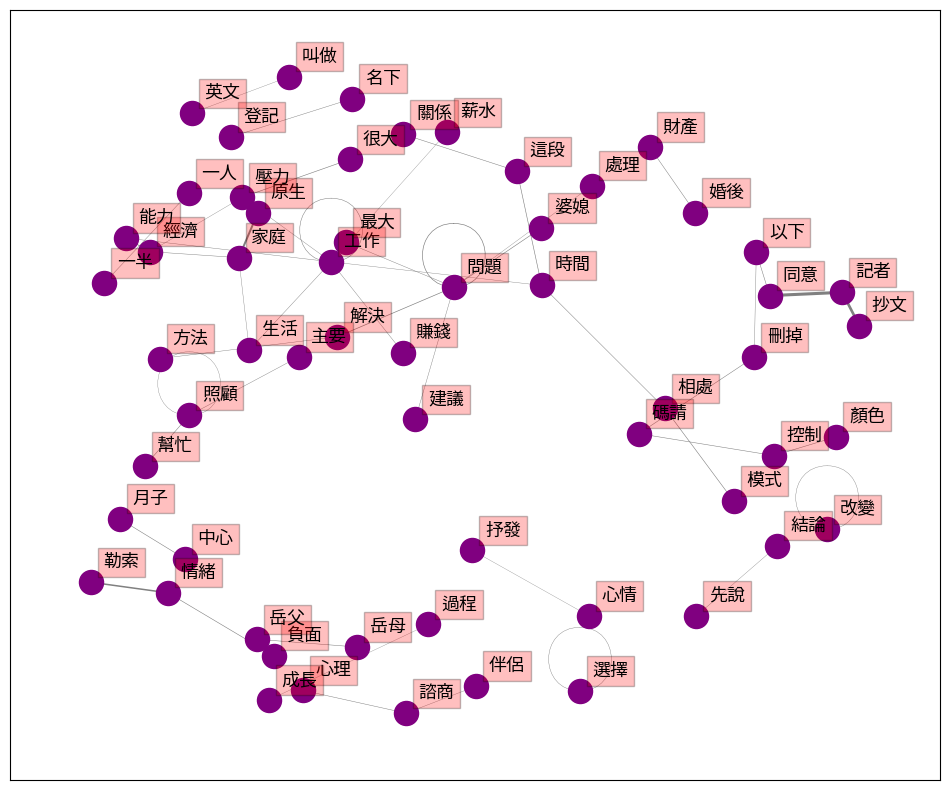

In [30]:
# Ë®≠ÂÆö matplotlib ÂÖ®ÂüüÂ≠óÂûãÔºà‰ª•ÂæÆËªüÊ≠£ÈªëÈ´îÁÇ∫‰æãÔºâ
# plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False  # Ëß£Ê±∫Ë≤†ËôüÈ°ØÁ§∫ÂïèÈ°å
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Â¢ûÂä† labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

‰ª•‰∏äÂúñÂèØ‰ª•ËßÄÂØüÂà∞

üß© ÂïèÈ°åËôïÁêÜËàáÊÉÖÁ∑íË™øÁØÄ
ÈóúÈçµË©ûÔºö„ÄåÂïèÈ°å„Äç„ÄåÊéßÂà∂„Äç„ÄåËôïÁêÜ„Äç„ÄåÂøÉÁêÜ„Äç„ÄåÊÉÖÁ∑í„Äç„ÄåËß£Ê±∫„Äç„ÄåÂª∫Ë≠∞„Äç

Ë™™ÊòéÔºöÂèçÊò†Áï∂‰∫ã‰∫∫Èù¢Â∞çÂ©öÂßªÂïèÈ°åÊôÇÁöÑÊÄùËÄÉËàáÊáâÂ∞çÁ≠ñÁï•ÔºåÂº∑Ë™øÂ¶Ç‰ΩïËôïÁêÜÈóú‰øÇ‰∏≠ÁöÑË°ùÁ™ÅËàáÂ£ìÂäõ„ÄÇ

üí∏ ÁîüÊ¥ªÂ£ìÂäõËàáÁ∂ìÊøüÁèæÂØ¶
ÈóúÈçµË©ûÔºö„ÄåÂ∑•‰Ωú„Äç„ÄåËñ™Ê∞¥„Äç„ÄåËÉΩÂäõ„Äç„ÄåÁ∂ìÊøü„Äç„ÄåË≤†Èù¢„Äç„ÄåÂ£ìÂäõ„Äç

Ë™™ÊòéÔºöÈ°ØÁ§∫Âá∫Á∂ìÊøüÂïèÈ°å„ÄÅË≥∫Èå¢Â£ìÂäõ„ÄÅÂ∑•‰ΩúÂΩ±ÈüøÊòØÈõ¢Â©öÁöÑÈáçË¶ÅËÉåÊôØÂõ†Á¥†‰πã‰∏Ä„ÄÇ

üè† ÂÆ∂Â∫≠ËßíËâ≤ËàáÂéüÁîüÈóú‰øÇ
ÈóúÈçµË©ûÔºö„ÄåÂÆ∂Â∫≠„Äç„ÄåÂéüÁîü„Äç„ÄåÂ≤≥Áà∂„Äç„ÄåÂ≤≥ÊØç„Äç„ÄåÁÖßÈ°ß„Äç„ÄåÂêç‰∏ã„Äç

Ë™™ÊòéÔºöÂ©öÂßª‰∏≠Â∏∏Â∏∏ÁâΩÊ∂âÂà∞Èï∑Ëº©„ÄÅÂÆ∂Â∫≠Áæ©ÂãôËàáËßíËâ≤Ë°ùÁ™ÅÔºåÈÄô‰∫õÂ§ñÂú®Âõ†Á¥†ÂèØËÉΩÂ∞éËá¥Â£ìÂäõÊàñË™§Ëß£„ÄÇ

üíî Â©öÂßªÈóú‰øÇÊú¨Ë∫´ËàáÊú™‰æÜÈÅ∏Êìá
ÈóúÈçµË©ûÔºö„ÄåÂ©öÂæå„Äç„ÄåË≤°Áî¢„Äç„ÄåÈõ¢Â©ö„Äç„Äå‰º¥‰æ∂„Äç„ÄåÈÅ∏Êìá„Äç„ÄåÁµêË´ñ„Äç
Ë™™ÊòéÔºöËÅöÁÑ¶Âú®Â©öÂßªÈóú‰øÇÁöÑËÆäÂåñÁµêÊûúÔºåÂ¶ÇË≤°Áî¢ÂàÜÈÖç„ÄÅÊòØÂê¶Èõ¢Â©ö„ÄÅÊú™‰æÜÁîüÊ¥ªÈÅ∏Êìá


### Pairwise correlation

In [31]:
data_cor = MetaData.copy()

data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                            sentence  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   

                                                word  
0  ÂÅ∑Áúã ÊâãÊ©ü ÊâãÊ©ü ÊãíÁµï ÊãíÁµï ÂøÉË£° ÊúâÈ¨º ÁåúÂøå Êó•Â≠ê Èõ£ÈÅé ÊâãÊ©ü Èö®‰æø ÊèêÂøÉÂêäËÜΩ Â∞èÂøÉ Á∏ΩÊòØ...  
1  Â∑•‰Ωú Á©©ÂÆö ÊàøÊù± ‰∏çËÇØ Âè™Â•Ω ÊâøÁßü ÊÆòÂøç ÁÑ°Á∑£ ËÅ∞Êòé ‰æÜÂà∞ ‰∏ñÈñì Ëã¶Èõ£ ‰∏ç‰æÜ ËÄÉÊÖÆ ‰ø°Ë≤∏ Áî≥...  
2  ÊâãÊ©ü Áµ¶Áúã ÂÖàÂ∏ù ‰∏ÄÈöª ‰∏çÂ§† ÂÖ©Èöª ÂÖ©Èöª ‰∏çÂ§† ‰∏âÈöª ‰∏âÈöª ÂõõÈöª ‰∏çÂ§† ‰∫îÈöª ÂçÅÈöª ÊÄï‰∫∫ Èáç...

In [32]:
vectorizer = CountVectorizer(min_df = 5 , max_features = 200)
X = vectorizer.fit_transform(data_cor['word'])
vocabulary = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

‰∏ÄÂÄãÊúà  ‰∏ÄÂçä  ‰∏ÄÂè•  ‰∏ÄÂ†Ü  ‰∏ÄÂ§©  ‰∏ÄÁ®Æ  ‰∏ÄËº©Â≠ê  ‰∏äÁè≠  ‰∏ã‰æÜ  ‰∏ãÁè≠  ...  ÈáçË¶Å  ÈáçÈªû  Èï∑Â§ß  Èï∑Ëº©  ÈñãÂøÉ  Èóú‰øÇ  \
0       0   0   0   0   0   0    0   0   0   0  ...   0   0   0   0   0   0   
1       0   0   0   0   0   0    0   0   0   0  ...   0   0   0   0   0   0   
2       0   0   0   0   0   0    0   0   0   0  ...   0   2   0   0   0   0   
3       0   0   1   0   0   0    0   0   0   0  ...   0   0   0   0   0   0   
4       0   0   1   0   0   0    0   0   0   0  ...   0   0   0   0   0   0   
...   ...  ..  ..  ..  ..  ..  ...  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
2199    0   0   0   0   0   0    0   0   0   0  ...   0   0   0   0   0   1   
2200    0   0   0   0   0   0    0   0   0   0  ...   0   0   0   0   0   0   
2201    0   1   0   0   0   0    0   0   0   0  ...   0   0   0   0   2   0   
2202    0   0   0   0   0   0    0   0   0   0  ...   3   1   0   1   0   0   
2203    0   0   0   0   0   0    0   0   0   0  ...   0   0   0   0   0   0   

      Èõ¢Èñã  ÈúÄÊ±Ç  Èù¢Â∞ç  È°òÊÑè  
0      0   0   0   0  
1      0   0   0   0  
2      0   0   0   0  
3      0   0   0   0  
4      0   0   0   0  
...   ..  ..  ..  ..  
2199   0   0   0   1  
2200   1   0   0   0  
2201   0   0   1   0  
2202   0   0   1   0  
2203   0   0   0   0  

[2204 rows x 200 columns]

In [33]:
corr_matrix = np.corrcoef(DTM_df.T)

Cor_df = pd.DataFrame(corr_matrix , index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True , drop = True)

Cor_df

word1       ‰∏ÄÂÄãÊúà        ‰∏ÄÂçä        ‰∏ÄÂè•        ‰∏ÄÂ†Ü        ‰∏ÄÂ§©        ‰∏ÄÁ®Æ  \
0     ‰∏ÄÂÄãÊúà  1.000000  0.049886  0.035742  0.017035  0.141114 -0.014822   
1      ‰∏ÄÂçä  0.049886  1.000000  0.154615  0.009311  0.092468  0.006591   
2      ‰∏ÄÂè•  0.035742  0.154615  1.000000  0.036945  0.145448  0.042438   
3      ‰∏ÄÂ†Ü  0.017035  0.009311  0.036945  1.000000  0.012216 -0.004466   
4      ‰∏ÄÂ§©  0.141114  0.092468  0.145448  0.012216  1.000000  0.095938   
..    ...       ...       ...       ...       ...       ...       ...   
195    Èóú‰øÇ  0.010898  0.040255  0.073400 -0.003055  0.174810  0.174831   
196    Èõ¢Èñã  0.111718  0.128884  0.105134  0.025730  0.093230  0.046559   
197    ÈúÄÊ±Ç  0.031368  0.010227  0.035186  0.013979  0.109828  0.181423   
198    Èù¢Â∞ç  0.008316 -0.001220  0.073542  0.014258  0.074169  0.142077   
199    È°òÊÑè  0.158358  0.083292  0.122257  0.005206  0.171107  0.160882   

          ‰∏ÄËº©Â≠ê        ‰∏äÁè≠        ‰∏ã‰æÜ  ...        ÈáçË¶Å        ÈáçÈªû        Èï∑Â§ß  \
0    0.062134  0.200325  0.109059  ... -0.002533  0.003423  0.031082   
1    0.002608  0.079252  0.195133  ...  0.025005  0.034294  0.073403   
2    0.071510  0.060495  0.179276  ...  0.064399  0.106672  0.106535   
3   -0.000129  0.038605  0.021666  ...  0.068042  0.044764  0.021275   
4    0.053808  0.190309  0.104582  ...  0.084258  0.000183  0.084834   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.045732  0.040921  0.055634  ...  0.140125  0.020542  0.124288   
196  0.084628  0.107562  0.210011  ...  0.088287  0.013185  0.104317   
197  0.019131  0.022024  0.064246  ...  0.122705  0.016060  0.004804   
198  0.094248  0.081262  0.088773  ...  0.098563  0.048021  0.084778   
199  0.116335  0.120505  0.144429  ...  0.146490  0.057062  0.142522   

           Èï∑Ëº©        ÈñãÂøÉ        Èóú‰øÇ        Èõ¢Èñã        ÈúÄÊ±Ç        Èù¢Â∞ç        È°òÊÑè  
0    0.027455  0.070612  0.010898  0.111718  0.031368  0.008316  0.158358  
1    0.035901  0.173844  0.040255  0.128884  0.010227 -0.001220  0.083292  
2    0.003158  0.138400  0.073400  0.105134  0.035186  0.073542  0.122257  
3    0.035918  0.077554 -0.003055  0.025730  0.013979  0.014258  0.005206  
4    0.027986  0.111222  0.174810  0.093230  0.109828  0.074169  0.171107  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.040119  0.101790  1.000000  0.112227  0.241709  0.186452  0.161358  
196  0.038212  0.150247  0.112227  1.000000  0.055456  0.132763  0.157834  
197  0.033902  0.078840  0.241709  0.055456  1.000000  0.073603  0.160093  
198  0.061551  0.087956  0.186452  0.132763  0.073603  1.000000  0.221320  
199  0.090636  0.184622  0.161358  0.157834  0.160093  0.221320  1.000000  

[200 rows x 201 columns]

In [34]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2' , value_name = 'cor')

word_cor_df = word_cor_df[word_cor_df['word1'] != word_cor_df['word2']]

word_cor_df.sort_values('cor', ascending =False).head(10)

word1 word2       cor
7961     Ë®òËÄÖ    ÂêåÊÑè  0.550335
32239    ÂêåÊÑè    Ë®òËÄÖ  0.550335
26234    Âä™Âäõ    ÁóõËã¶  0.483483
6931     ÁóõËã¶    Âä™Âäõ  0.483483
6841     ÂëäË®¥    Âä™Âäõ  0.483276
8234     Âä™Âäõ    ÂëäË®¥  0.483276
8331     ÁóõËã¶    ÂëäË®¥  0.474694
26241    ÂëäË®¥    ÁóõËã¶  0.474694
12130    ÁîüÊ¥ª    Â∑•‰Ωú  0.449528
26060    Â∑•‰Ωú    ÁîüÊ¥ª  0.449528

### Âíå „ÄåÊ∫ùÈÄö„Äç, „ÄåÁ∂ìÊøü„Äç Áõ∏ÈóúÊÄßÊúÄÈ´òÁöÑ 10 ÂÄãË©ûÂΩô

In [35]:
div_sum = word_cor_df[(word_cor_df['word1'] == "Ê∫ùÈÄö")].sort_values(by = ['cor'], ascending = False).head(10)
con_sum = word_cor_df[(word_cor_df['word1'] == "Á∂ìÊøü")].sort_values(by = ['cor'], ascending = False).head(10)

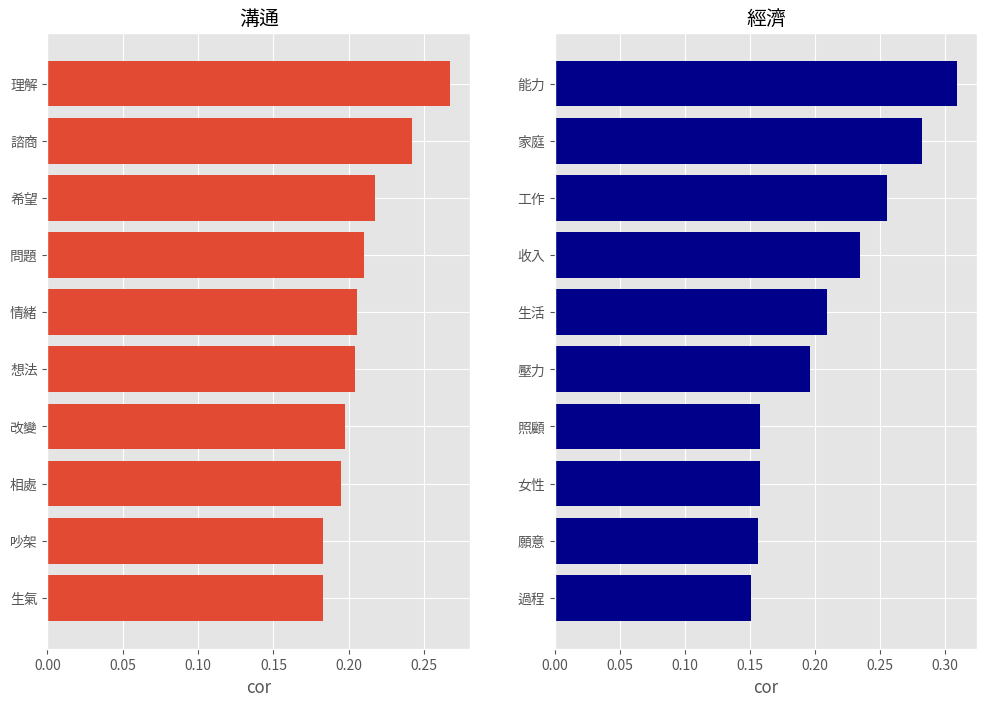

In [36]:
plt.figure(figsize=(12,8))   # È°ØÁ§∫ÂúñÊ°ÜÊû∂Â§ßÂ∞è (ÂØ¨,È´ò)
plt.style.use("ggplot")     # ‰ΩøÁî®ggplot‰∏ªÈ°åÊ®£Âºè

plt.subplot(121)
plt.title('Ê∫ùÈÄö')
plt.xlabel('cor')
plt.barh(div_sum['word2'],div_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('Á∂ìÊøü')
plt.xlabel('cor')
plt.barh(con_sum['word2'],con_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### ‰ΩøÁî®Ë©ûÂΩôÈóú‰øÇÂúñÁï´Âá∫‰ª•Ë©ûÈ†ªÂâç60ÁÇ∫ÁØÄÈªû‰∏îÁõ∏ÈóúÊÄßÈ´òÊñº0.3ÁöÑÁµÑÂêà

In [37]:
#ÈÄèÈÅéDTMÊâæÂá∫Ë©ûÈ†ªÂâç60È´òÁöÑË©ûÂΩô
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [38]:
# ‰øùÁïôÂ≠òÂú®Ë©ûÈ†ªÂâç60È´ò‰πãË©ûÂΩôÁöÑÁµÑÂêà
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# ÁØ©ÈÅ∏Âá∫Áõ∏Èóú‰øÇÊï∏Â§ßÊñº0.3ÁöÑÁµÑÂêà
filtered_df = filtered_df[filtered_df['cor'] >= 0.28]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

word1 word2       cor
0     Èóú‰øÇ    ÂÖ©‰∫∫  0.324178
1     Â∏åÊúõ    Âä™Âäõ  0.381417
2     ÊàëÊúÉ    Âä™Âäõ  0.301851
3     ÊôÇÈñì    Âä™Âäõ  0.310105
4     ÁîüÊ¥ª    Âä™Âäõ  0.287391
..   ...   ...       ...
69    Âä™Âäõ    ÈÅ∏Êìá  0.310424
70    ÂÖ©‰∫∫    Èóú‰øÇ  0.324178
71    Ë´ÆÂïÜ    Èóú‰øÇ  0.341037
72    Âä™Âäõ    È°òÊÑè  0.345643
73    Â∏åÊúõ    È°òÊÑè  0.287000

[74 rows x 3 columns]

In [39]:
# Create network plot 
g = nx.Graph()

# Âª∫Á´ã nodes ÈñìÁöÑÈÄ£Áµê
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# ÂèñÂæóedgeÊ¨äÈáç
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

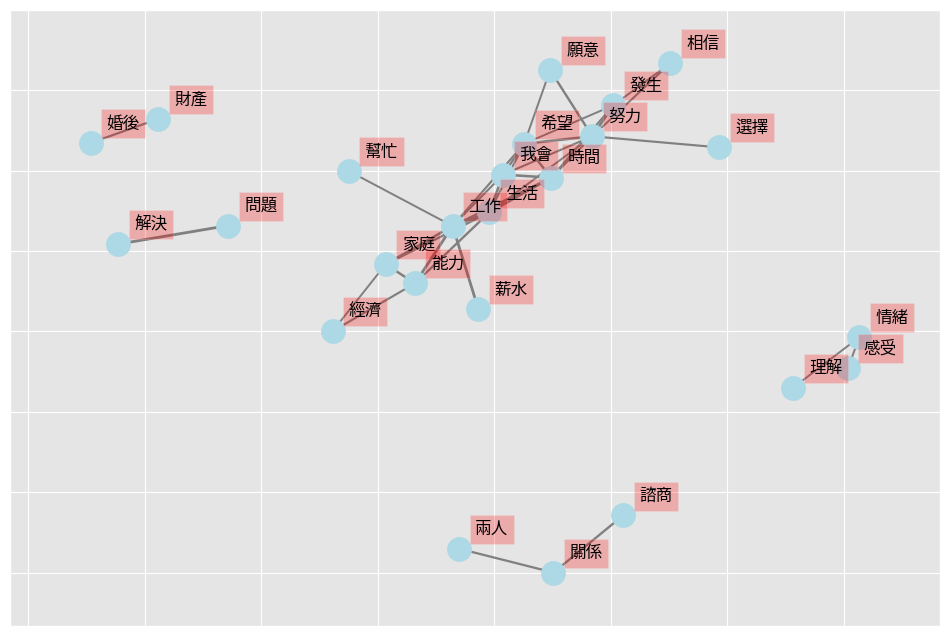

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# Â¢ûÂä† labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

ÈÄôÂºµË©ûÂΩôÈóú‰øÇÂúñÈÄèÈÅéÁ∂≤Áµ°ÁµêÊßãÔºåÂëàÁèæ‰∫ÜÈõ¢Â©öË≠∞È°åË®éË´ñ‰∏≠ÊúÄÂ∏∏Âá∫ÁèæÁöÑÈóúÈçµË©û‰ª•ÂèäÂÆÉÂÄë‰πãÈñìÁöÑÈÄ£Áµê„ÄÇÂæûÂúñ‰∏≠ÂèØ‰ª•ÁúãÂà∞ÂπæÂÄã‰∏ªË¶ÅÁöÑÈóúËÅØÁæ§ÈõÜÔºö

1. Â©öÂßªË≤°Áî¢ËàáÈóú‰øÇÔºàÂ∑¶‰∏äÔºâ

- Â©öÂæåÁöÑË≤°Áî¢ÂïèÈ°åÊúÉÁõ¥Êé•ÂΩ±ÈüøÂ§´Â¶ª‰πãÈñìÁöÑÈóú‰øÇÔºåÁîöËá≥ÂèØËÉΩÊºîËÆäÂà∞ÈúÄË¶ÅÂ∞ãÊ±ÇË´ÆÂïÜÂçîÂä©
- Ë≤°ÂãôÂïèÈ°åÂ∏∏Â∏∏ÊòØÂ©öÂßªË°ùÁ™ÅÁöÑËµ∑Èªû‰πã‰∏Ä

2. ÂïèÈ°åËß£Ê±∫ÔºàÂè≥‰∏äÔºâ

- ÈóúÈçµË©ûÂÉè„ÄåÂïèÈ°å„ÄçÈÄ£Âà∞„ÄåËß£Ê±∫„ÄçÔºåÈ°ØÁ§∫Â§ßÂÆ∂Âú®Â©öÂßª‰∏≠ÂæàÈóúÊ≥®ÊÄéÈ∫ºËôïÁêÜË°ùÁ™ÅÊàñÂõ∞Èõ£

3. ÊÉÖÊÑüÁêÜËß£Áæ§ÈõÜÔºàÂ∑¶‰∏ãÔºâ

- Ë°®ÈÅîÊÉÖÁ∑íÂíåË¢´ÁêÜËß£ÁöÑÈúÄÊ±ÇÔºå‰πüÊòØÁ∂≠ÊåÅÈóú‰øÇÁöÑÊñπÊ≥ï

4. Â∑•‰ΩúÔºçÁîüÊ¥ªÔºçÂÆ∂Â∫≠Ê†∏ÂøÉÁ∂≤Áµ°Ôºà‰∏≠Â§ÆÔºâ

- ‰ª•„ÄåÂ∑•‰Ωú„Äç„ÄÅ„ÄåÂÆ∂Â∫≠„Äç„ÄÅ„ÄåÁîüÊ¥ª„ÄçÁÇ∫‰∏≠ÂøÉÔºåÂª∂‰º∏Âá∫„ÄåËÉΩÂäõ„Äç„ÄÅ„ÄåÁ∂ìÊøü„Äç„ÄÅ„ÄåÂπ´Âøô„ÄçÁ≠âÁõ∏ÈóúË©ûÂΩô
- ÈÄôÂÄãË§áÈõúÁöÑÁ∂≤Áµ°ÂèçÊò†Âá∫Â∑•‰Ωú„ÄÅÂÆ∂Â∫≠ÂíåÁîüÊ¥ª‰πãÈñìÁöÑÁ∑äÂØÜÈÄ£Áµê
- ÂÉè„ÄåÁ∂ìÊøü„ÄçÂêåÊôÇÈÄ£Âà∞„ÄåÂÆ∂Â∫≠„ÄçÂíå„ÄåÂ∑•‰Ωú„ÄçÔºåË™™ÊòéÁ∂ìÊøüÂ£ìÂäõÂú®ÂÆ∂Â∫≠Èóú‰øÇ‰∏≠ÊâÆÊºîËëó‰∏≠‰ªãËßíËâ≤

5. Á©çÊ•µÂä™ÂäõËàáÂ∏åÊúõÁæ§ÈõÜÔºàÂè≥‰∏ãÔºâ

- „ÄåÂä™Âäõ„ÄçÈÄôÂÄãË©ûÈÄ£Âà∞„ÄåÂ∏åÊúõ„Äç„ÄÅ„ÄåÁôºÁîü„Äç„ÄÅ„ÄåÁõ∏‰ø°„Äç„ÄÅ„ÄåÈ°òÊÑè„ÄçÁ≠âË©û
- ÈÄôÁµÑË©ûÂΩô‰ª£Ë°®‰∫ÜÂú®Â©öÂßªÈù¢Ëá®Âõ∞Èõ£ÊôÇÔºåÁ∂≠Áπ´Èóú‰øÇÊâÄÈúÄË¶ÅÁöÑ‰ø°ÂøµÂíåË°åÂãï

---

Á∂úÂêàÂàÜÊûê

Êï¥ÂºµÁ∂≤Áµ°ÂúñÊè≠Á§∫‰∫ÜÂ©öÂßªËàáÈõ¢Â©öË≠∞È°åÁöÑÂ§öÈù¢ÂêëÊÄßÔºå‰∏ªË¶ÅÂèØ‰ª•Ê≠∏Á¥çÁÇ∫‰ª•‰∏ãÂπæÈªûÔºö

- Ë≤°ÂãôËàáË≤°Áî¢ÂïèÈ°åÊòØÊúÄÊ†∏ÂøÉ„ÄÅÊúÄÂÆπÊòìÂºïÁàÜÁà≠Ë≠∞ÁöÑÊ∫êÈ†≠  
- ÊÉÖÊÑüÊ∫ùÈÄöÂíåÁõ∏‰∫íÁêÜËß£ÔºåÊòØÁ∂≠Áπ´Èóú‰øÇÁöÑÊÉÖÊÑüÂü∫Á§é  
- Â∑•‰Ωú„ÄÅÁîüÊ¥ªËàáÂÆ∂Â∫≠ÁöÑÂπ≥Ë°°ÔºåÊòØÂ©öÂßªÊó•Â∏∏‰∏≠ÊúÄÂ∏∏Ë¶ãÁöÑÂ£ìÂäõ‰æÜÊ∫ê  
- ÊúâÊïàÁöÑÂïèÈ°åËß£Ê±∫ËÉΩÂäõÔºå‰ª•ÂèäÁ∂≠ÊåÅ‰∏Ä‰ªΩÁ©çÊ•µÂä™ÂäõÁöÑÊÖãÂ∫¶ÔºåÊòØÁ©©ÂÆöÈóú‰øÇÁöÑÈóúÈçµ


### Ë®àÁÆóÊñáÁ´†Áõ∏‰ººÂ∫¶

In [41]:
data_cos = data_cor.copy()
data_cos.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                            sentence  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   

                                                word  
0  ÂÅ∑Áúã ÊâãÊ©ü ÊâãÊ©ü ÊãíÁµï ÊãíÁµï ÂøÉË£° ÊúâÈ¨º ÁåúÂøå Êó•Â≠ê Èõ£ÈÅé ÊâãÊ©ü Èö®‰æø ÊèêÂøÉÂêäËÜΩ Â∞èÂøÉ Á∏ΩÊòØ...  
1  Â∑•‰Ωú Á©©ÂÆö ÊàøÊù± ‰∏çËÇØ Âè™Â•Ω ÊâøÁßü ÊÆòÂøç ÁÑ°Á∑£ ËÅ∞Êòé ‰æÜÂà∞ ‰∏ñÈñì Ëã¶Èõ£ ‰∏ç‰æÜ ËÄÉÊÖÆ ‰ø°Ë≤∏ Áî≥...  
2  ÊâãÊ©ü Áµ¶Áúã ÂÖàÂ∏ù ‰∏ÄÈöª ‰∏çÂ§† ÂÖ©Èöª ÂÖ©Èöª ‰∏çÂ§† ‰∏âÈöª ‰∏âÈöª ÂõõÈöª ‰∏çÂ§† ‰∫îÈöª ÂçÅÈöª ÊÄï‰∫∫ Èáç...

In [42]:
transformer = TfidfTransformer()
print(transformer)
tfidf = transformer.fit_transform(X)

TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


‰∏ÄÂÄãÊúà        ‰∏ÄÂçä        ‰∏ÄÂè•   ‰∏ÄÂ†Ü   ‰∏ÄÂ§©   ‰∏ÄÁ®Æ  ‰∏ÄËº©Â≠ê   ‰∏äÁè≠   ‰∏ã‰æÜ   ‰∏ãÁè≠  ...  \
0     0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1     0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2     0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3     0.0  0.000000  0.119960  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4     0.0  0.000000  0.389462  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...   ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
2199  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2200  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2201  0.0  0.121818  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2202  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2203  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

           ÈáçË¶Å        ÈáçÈªû   Èï∑Â§ß        Èï∑Ëº©        ÈñãÂøÉ        Èóú‰øÇ       Èõ¢Èñã   ÈúÄÊ±Ç  \
0     0.00000  0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.0   
1     0.00000  0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.0   
2     0.00000  0.471181  0.0  0.000000  0.000000  0.000000  0.00000  0.0   
3     0.00000  0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.0   
4     0.00000  0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.0   
...       ...       ...  ...       ...       ...       ...      ...  ...   
2199  0.00000  0.000000  0.0  0.000000  0.000000  0.272793  0.00000  0.0   
2200  0.00000  0.000000  0.0  0.000000  0.000000  0.000000  0.28496  0.0   
2201  0.00000  0.000000  0.0  0.000000  0.214685  0.000000  0.00000  0.0   
2202  0.45284  0.174411  0.0  0.202036  0.000000  0.000000  0.00000  0.0   
2203  0.00000  0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.0   

            Èù¢Â∞ç        È°òÊÑè  
0     0.000000  0.000000  
1     0.000000  0.000000  
2     0.000000  0.000000  
3     0.000000  0.000000  
4     0.000000  0.000000  
...        ...       ...  
2199  0.000000  0.261035  
2200  0.000000  0.000000  
2201  0.115673  0.000000  
2202  0.176520  0.000000  
2203  0.000000  0.000000  

[2204 rows x 200 columns]

In [43]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

In [44]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

cos_similarity
0           1.000000
1           0.000000
2           0.399737
3           0.092796
4           0.000000
...              ...
2199        0.000000
2200        0.000000
2201        0.000000
2202        0.000000
2203        0.000000

[2204 rows x 1 columns]

In [45]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity               artTitle  \
0           1.000000        [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü   
354         0.818640       Re:[ÂøÉÊÉÖ]‰∏çÊáÇËÄÅÂÖ¨Âú®ÊÉ≥‰ªÄÈ∫ºÔºü   
538         0.728742        [ÈñíËÅä]‰∏ÄÁõ¥ÊªëÊâãÊ©üÊòØÂõ†ÁÇ∫Â§™ÁÑ°ËÅä   
96          0.652961                ÂÖàÁîü‰∏äÁè≠ÊâæÊè¥‰∫§   
932         0.639000              [ÂøÉÊÉÖ]ÊúÄÂæå‰∏ÄÂì©Ë∑Ø   
1139        0.638714         Re:[Ê±ÇÂä©]ÊàëË©≤Ë∑ü‰ªñË´áÂóéÔºü   
1334        0.610310  [Ê±ÇÂä©]ÂÖàÁîü‰ΩøÁî®zenly(ÂÜ∞Ê£íÔºâËøΩËπ§Â•≥Áîü   
533         0.566953       [Ê±ÇÂä©]ÈÄôÊ®£ÁöÑÂ©öÂßªÈÇÑÂÄºÂæóÂ≠òÁ∫åÂóéÔºü   
1531        0.551317      Re:[ÈñíËÅä]‰∏çÊÉ≥ËûçÂÖ•Â©ÜÂÆ∂ÁöÑÂ§ßÂÆ∂Â∫≠   
387         0.536304  Re:[Ê±ÇÂä©]ÈÄôÊ®£Ë©≤Èõ¢Â©öÂóéÔºüÂ∞çÊñπ‰∏çËÇØÊÄéÈ∫ºËæ¶   

                                                 artUrl  
0     https://www.ptt.cc/bbs/marriage/M.1610159827.A...  
354   https://www.ptt.cc/bbs/marriage/M.1626416435.A...  
538   https://www.ptt.cc/bbs/marriage/M.1634023811.A...  
96    https://www.ptt.cc/bbs/marriage/M.1613943928.A...  
932   https://www.ptt.cc/bbs/marriage/M.1651982756.A...  
1139  https://www.ptt.cc/bbs/marriage/M.1658458889.A...  
1334  https://www.ptt.cc/bbs/marriage/M.1670856234.A...  
533   https://www.ptt.cc/bbs/marriage/M.1633611389.A...  
1531  https://www.ptt.cc/bbs/marriage/M.1689042822.A...  
387   https://www.ptt.cc/bbs/marriage/M.1627760110.A...

In [46]:
cos_df_num = pd.DataFrame(cosine_matrix[354], columns=['cos_similarity'])

cos_df_num = cos_df_num.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_num.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity            artTitle  \
354         1.000000    Re:[ÂøÉÊÉÖ]‰∏çÊáÇËÄÅÂÖ¨Âú®ÊÉ≥‰ªÄÈ∫ºÔºü   
538         0.890186     [ÈñíËÅä]‰∏ÄÁõ¥ÊªëÊâãÊ©üÊòØÂõ†ÁÇ∫Â§™ÁÑ°ËÅä   
0           0.818640     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü   
96          0.797617             ÂÖàÁîü‰∏äÁè≠ÊâæÊè¥‰∫§   
1139        0.780213      Re:[Ê±ÇÂä©]ÊàëË©≤Ë∑ü‰ªñË´áÂóéÔºü   
533         0.692554    [Ê±ÇÂä©]ÈÄôÊ®£ÁöÑÂ©öÂßªÈÇÑÂÄºÂæóÂ≠òÁ∫åÂóéÔºü   
1531        0.673455   Re:[ÈñíËÅä]‰∏çÊÉ≥ËûçÂÖ•Â©ÜÂÆ∂ÁöÑÂ§ßÂÆ∂Â∫≠   
1561        0.646286       [Ê±ÇÂä©]ÁÑ°ÊÄßÂ©öÂßªÔºåÈõ¢Â©öË´ãÁõä   
2034        0.641591  Re:[Ê±ÇÂä©]ÊÄéÈ∫ºËÆìËÄÅÂÖ¨ËÆäÂæóÊõ¥Êµ™Êº´Ôºü   
932         0.635770           [ÂøÉÊÉÖ]ÊúÄÂæå‰∏ÄÂì©Ë∑Ø   

                                                 artUrl  
354   https://www.ptt.cc/bbs/marriage/M.1626416435.A...  
538   https://www.ptt.cc/bbs/marriage/M.1634023811.A...  
0     https://www.ptt.cc/bbs/marriage/M.1610159827.A...  
96    https://www.ptt.cc/bbs/marriage/M.1613943928.A...  
1139  https://www.ptt.cc/bbs/marriage/M.1658458889.A...  
533   https://www.ptt.cc/bbs/marriage/M.1633611389.A...  
1531  https://www.ptt.cc/bbs/marriage/M.1689042822.A...  
1561  https://www.ptt.cc/bbs/marriage/M.1691718432.A...  
2034  https://www.ptt.cc/bbs/marriage/M.1721773233.A...  
932   https://www.ptt.cc/bbs/marriage/M.1651982756.A...

### Âª∫Á´ãNgramÈ†êÊ∏¨Ê®°Âûã

In [47]:
data_n = MetaData.copy()
sen_tokens = data_n.sentence.apply(getToken).tolist()

In [48]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # Âä†‰∏äÈñãÈ†≠ÂíåÁµêÂ∞æ tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # Ë®àÁÆóÂàÜÂ≠ê
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # Ë®àÁÆóÂàÜÊØç
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction


In [49]:
bi_prediction = ngram(sen_tokens, N=2)

In [50]:
text = 'Â©öÂæå'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: Ë≤°Áî¢, probability: 0.0852
next word: ÁîüÊ¥ª, probability: 0.0219
next word: Â∑•‰Ωú, probability: 0.017
next word: ÁîüÂ∞èÂ≠©, probability: 0.0146
next word: ÊØèÂπ¥, probability: 0.00973


ÈÄôÈ°ØÁ§∫Âú®Èõ¢Â©öË®éË´ñ‰∏≠ÔºåË≤°Áî¢ÂïèÈ°åÊòØÂ©öÂæåÊúÄË¢´ÈóúÊ≥®ÁöÑÊ†∏ÂøÉË≠∞È°å

In [51]:
text = 'Ë≤°Áî¢'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: ‰∏ÄÂçä, probability: 0.0312
next word: ÂàÜÈñã, probability: 0.0284
next word: ÂÖ±Êúâ, probability: 0.0227
next word: Â∑ÆÈ°ç, probability: 0.0199
next word: Â©öÂæå, probability: 0.017


Èõ¢Â©öË®éË´ñ‰∏≠Ë≤°Áî¢ÂàÜÈÖçÁöÑÁÑ¶ÈªûÂú®ÊñºÂπ≥ÂùáÂàÜÈÖçÂíåÂàÜÈõ¢ÂïèÈ°å

In [52]:
text = 'ÊÉÖÁ∑í'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: ÂãíÁ¥¢, probability: 0.141
next word: ÂÉπÂÄº, probability: 0.0246
next word: ÊéßÁÆ°, probability: 0.0246
next word: Â§±Êéß, probability: 0.022
next word: ÂïèÈ°å, probability: 0.0207


Â©öÂßªÈóú‰øÇ‰∏≠‰∏çÂÅ•Â∫∑ÁöÑÊÉÖÁ∑íÊìçÊéßÂèØËÉΩÊòØÂ∞éËá¥Èõ¢Â©öÁöÑÈóúÈçµÂõ†Á¥†

In [53]:
text = 'Â∑•‰Ωú'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: Â∑•‰Ωú, probability: 0.0195
next word: ÁîüÊ¥ª, probability: 0.0163
next word: Ë≥∫Èå¢, probability: 0.0163
next word: ËÉΩÂäõ, probability: 0.0163
next word: Â£ìÂäõ, probability: 0.0152


ÂèØ‰ª•ÁúãÂá∫Â∑•‰Ωú‰∏çÂè™ÊòØÁ∂ìÊøü‰æÜÊ∫êÔºåÈÇÑËàáÁîüÊ¥ªÂπ≥Ë°°„ÄÅËÉΩÂäõÂíåÂ£ìÂäõÁõ∏ÈÄ£

In [54]:
text = 'ÂÆ∂Â∫≠'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: Á∂ìÊøü, probability: 0.0256
next word: ÁîüÊ¥ª, probability: 0.0216
next word: ÂïèÈ°å, probability: 0.016
next word: Èóú‰øÇ, probability: 0.0144
next word: ÈñãÈä∑, probability: 0.0128


Âú®Â©öÂßªÁîüÊ¥ªÂíåÈõ¢Â©öË´áÂà§‰∏≠ÔºåË≤°Áî¢ÂïèÈ°åÂæÄÂæÄÊòØÂ§ßÂÆ∂ÊúÄÈóúÂøÉÁöÑÁÑ¶Èªû‰πã‰∏Ä„ÄÇ
ËÄåÂú®Êó•Â∏∏Áõ∏ËôïË£°ÔºåÊÉÖÁ∑í‰∫íÂãïÔºåÁâπÂà•ÊòØË≤†Èù¢ÊÉÖÁ∑íÁöÑÊìçÊéßÔºå‰πüÊòØ‰∏ÄÂÄãÂæàÂ§ßÁöÑÊåëÊà∞ÔºåÂ∏∏Â∏∏ÂΩ±ÈüøÂΩºÊ≠§ÁöÑÈóú‰øÇ„ÄÇ
ÂÜçÂä†‰∏äÂ∑•‰ΩúÂ£ìÂäõÂíåÁ∂ìÊøüË≤†ÊìîÔºå‰πüÊúÉÁõ¥Êé•Ë°ùÊìäÂà∞Â©öÂßªÁöÑÁ©©ÂÆöÔºåÈÄô‰∫õÈ¢®Èö™ÁúüÁöÑ‰∏çËÉΩÂøΩË¶ñ„ÄÇ
Â©öÂæåÁîüÊ¥ªÊú¨‰æÜÂ∞±ÂÖÖÊªøÂêÑÁ®ÆË™øÊï¥ËàáÊåëÊà∞ÔºåÁ®ç‰∏çÁïôÊÑèÂ∞±ÂèØËÉΩËÆäÊàêË°ùÁ™ÅÁöÑÂ∞éÁÅ´Á∑ö„ÄÇ

Á∂úÂêà‰æÜÁúãÔºåÁèæ‰ª£Â©öÂßªË¶ÅËµ∞ÂæóÈï∑‰πÖÔºåÊúÄÈáçË¶ÅÁöÑÈÇÑÊòØ‰∏âÂÄãÈóúÈçµÔºöË≤°ÂãôÁÆ°ÁêÜ„ÄÅÊÉÖÁ∑íÂÅ•Â∫∑ÂíåÂ∑•‰ΩúÁîüÊ¥ªÁöÑÂπ≥Ë°°„ÄÇÈÄô‰∏âÂÄãÈù¢Âêë‰πüÊ≠£ÊòØ‰∫∫ÂÄëÂú®ËÄÉÊÖÆÈõ¢Â©öÊôÇÔºåÊúÄÂ∏∏ÊîæÂú®ÂøÉ‰∏äÁöÑÊ†∏ÂøÉÂïèÈ°å„ÄÇ

# Week 7

### Â•ó‰ª∂

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÈ´î

In [ ]:
# Ë®≠ÂÆöÂúñÁöÑ‰∏≠ÊñáÂ≠óÈ´î (ÁÑ°Ê≥ïÈ°ØÁ§∫ÁöÑË©±ÂèØ‰ª•Ë©¶Ë©¶‚ÄòMicrosoft JhengHei‚ÄôÂ≠óÈ´î)
# ‰πüÂèØÂèÉËÄÉÔºöhttps://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #‰ΩøÂúñ‰∏≠‰∏≠ÊñáËÉΩÊ≠£Â∏∏È°ØÁ§∫
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #‰ΩøÂúñ‰∏≠‰∏≠ÊñáËÉΩÊ≠£Â∏∏È°ØÁ§∫
plt.rcParams['axes.unicode_minus'] = False #‰ΩøË≤†ËôüËÉΩÂ§†È°ØÁ§∫

## ÊñáÂ≠óÂâçËôïÁêÜ
`ppt_merged.csv`
- ÁâàÂà•ÔºöÂ©öÂßªÁâà È£üÁâ©Áâà ÈõªÂΩ±Áâà
- ÊôÇÈñìÁØÑÂúçÔºö2025/01/01 ~ 2025/04/01
- Â∑•‰ΩúÊµÅÁ®ãÂπ≥Âè∞ÊêúÂ∞ã/ÊéíÈô§ÈóúÈçµÂ≠óÔºöÁÑ°

È¶ñÂÖàÊàëÂÄëÂÖàÁúãÊñáÈõÜÁöÑÂü∫Êú¨Ë≥áÊñôÔºå‰∏¶ÂÅöÊñáÈõÜÂâçËôïÁêÜ„ÄÇ

In [ ]:
df = pd.read_csv("ppt_merged.csv")  # Â©öÂßªÁâà È£üÁâ©Áâà ÈõªÂΩ±Áâà Âêà‰ΩµÂæåÁöÑÊ™îÊ°à
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...   
1          2  https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...   
2          3  https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...   

              artTitle              artDate   artPoster artCatagory  \
0       [ËΩâËÆì]Êó≠ÈõÜ‰ø°Áæ©1/7‰∏ãÂçàËå∂   2025-01-01 6:15:50      linein        Food   
1  [È£üË®ò]Êñ∞Âåó‰∏≠ÂíåÂçÄÔΩúËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫ó  2025-01-01 14:41:54  roger31311        Food   
2    [È£üË®ò]Ëä±ËìÆÈ§äÈçãÊºÇ‰∫ÆÂ•ΩÂêÉÁöÑÁü≥È†≠ÁÅ´Èçã  2025-01-01 15:37:57    lovecala        Food   

                                          artContent artComment  \
0  È§êÂª≥ÂêçÁ®±ÔºöÊó≠ÈõÜ\nÊôÇÈñìÔºö1/7‰∏ãÂçà14Ôºö30\n‰∫∫Êï∏‰∫å‰Ωç\nË®ÇÈáë1000ÂÖÉ\n\nÁ´ôÂÖß‰ø°ÔºåË¨ùË¨ù\n         []   
1  È§êÂª≥ÂêçÁ®±ÔºöËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ã ÊôØÂÆâÂ∫ó\nÊ∂àË≤ªÊôÇÈñìÔºö2024Âπ¥/12Êúà\nÂú∞ÂùÄÔºöÊñ∞ÂåóÂ∏Ç‰∏≠ÂíåÂçÄÊôØÂπ≥Ë∑Ø4...         []   
2  È§êÂª≥ÂêçÁ®±ÔºöÈ§äÈçã\n   Ê∂àË≤ªÊôÇÈñìÔºö2025Âπ¥/1Êúà\n   Âú∞ÂùÄÔºöËä±ËìÆÂ∏Ç‰∏≠Â±±Ë∑Ø549-1Ëôü\...         []   

             e_ip        insertedDate dataSource  
0   27.240.177.25  2025-01-02 1:04:00        ptt  
1    61.231.20.71  2025-01-02 1:04:00        ptt  
2  114.43.215.209  2025-01-02 1:04:00        ptt

In [ ]:
# ÁúãÁúãÊúâÂπæÁØáÊñáÁ´†
print(f"number of posts: {df.shape[0]}")
print(f"date range: {(df['artDate'].min(), df['artDate'].max())}")
print(f"category: \n{df['artCatagory'].value_counts()}")

number of posts: 6374
date range: ('2025-01-01 0:56:25', '2025-04-01 4:34:16')
category: 
artCatagory
movie       4522
Food        1312
marriage     540
Name: count, dtype: int64


### Ê∏ÖÁêÜ

Âà©Áî®ÂïèËôü„ÄÅÂè•ËôüÊàñÈ©öÂòÜËôüÁ≠âÁ¨¶ËôüÊñ∑Âè•ÔºåÊàñÊòØÂ¶ÇÊûúÂá∫Áèæ‰∏≠ÊñáÊàñÊòØËã±ÊñáÁöÑÁúÅÁï•ËôüÔºåÂÉèÊòØ`...`‰πüÊúÉÊñ∑Âè•ÔºåÊúÄÂæåË®≠ÂÆöÊúÉÂéªÈô§ÁµêÂ∞æÁöÑÁ©∫ÁôΩÁ¨¶Ëôü„ÄÇ

In [ ]:
# ÈÅéÊøæ nan ÁöÑË≥áÊñô
df = df.dropna(subset=['artTitle'])
df = df.dropna(subset=['artContent'])
# ÁßªÈô§Á∂≤ÂùÄÊ†ºÂºè
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...   
1          2  https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...   
2          3  https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...   

           artTitle              artDate   artPoster artCatagory  \
0         ËΩâËÆìÊó≠ÈõÜ‰ø°Áæ©‰∏ãÂçàËå∂   2025-01-01 6:15:50      linein        Food   
1  È£üË®òÊñ∞Âåó‰∏≠ÂíåÂçÄËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫ó  2025-01-01 14:41:54  roger31311        Food   
2   È£üË®òËä±ËìÆÈ§äÈçãÊºÇ‰∫ÆÂ•ΩÂêÉÁöÑÁü≥È†≠ÁÅ´Èçã  2025-01-01 15:37:57    lovecala        Food   

                                          artContent artComment  \
0                             È§êÂª≥ÂêçÁ®±Êó≠ÈõÜÊôÇÈñì‰∏ãÂçà‰∫∫Êï∏‰∫å‰ΩçË®ÇÈáëÂÖÉÁ´ôÂÖß‰ø°Ë¨ùË¨ù         []   
1  È§êÂª≥ÂêçÁ®±ËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫óÊ∂àË≤ªÊôÇÈñìÂπ¥ÊúàÂú∞ÂùÄÊñ∞ÂåóÂ∏Ç‰∏≠ÂíåÂçÄÊôØÂπ≥Ë∑ØËôüÈõªË©±ÁáüÊ•≠ÊôÇÈñìÊØè‰∫∫Âπ≥ÂùáÂÉπ‰ΩçÂ•ΩËÆÄÂúñ...         []   
2  È§êÂª≥ÂêçÁ®±È§äÈçãÊ∂àË≤ªÊôÇÈñìÂπ¥ÊúàÂú∞ÂùÄËä±ËìÆÂ∏Ç‰∏≠Â±±Ë∑ØËôüÈõªË©±ÊØè‰∫∫Âπ≥ÂùáÂÉπ‰ΩçÂúñÊñáÁ∂≤Ë™åÈÄôÈñìÈ§äÈçãÂú®Âè∞ÂåóÊúâÂêÉÈÅéÂç∞Ë±°‰∏ç...         []   

             e_ip        insertedDate dataSource  
0   27.240.177.25  2025-01-02 1:04:00        ptt  
1    61.231.20.71  2025-01-02 1:04:00        ptt  
2  114.43.215.209  2025-01-02 1:04:00        ptt

ÊñáÁ´†ÁöÑÊ®ôÈ°å`artTitle`ÂíåÂÖßÊñá`sentence`ÈÉΩÊúÉÁ¥çÂÖ•ÂàÜÊûêÁöÑÂÖßÂÆπÔºåÊàêÁÇ∫Êñ∞ÁöÑ`content`Ê¨Ñ‰Ωç„ÄÇ

In [ ]:
# Áïô‰∏ã content
df["content"] = df["artTitle"] + df["artContent"]
df = df[["content", "artUrl", "artCatagory"]]  # ÊñáÁ´†ÂÖßÂÆπ ÊñáÁ´†ÈÄ£Áµê
df.head()

content  \
0                    ËΩâËÆìÊó≠ÈõÜ‰ø°Áæ©‰∏ãÂçàËå∂È§êÂª≥ÂêçÁ®±Êó≠ÈõÜÊôÇÈñì‰∏ãÂçà‰∫∫Êï∏‰∫å‰ΩçË®ÇÈáëÂÖÉÁ´ôÂÖß‰ø°Ë¨ùË¨ù   
1  È£üË®òÊñ∞Âåó‰∏≠ÂíåÂçÄËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫óÈ§êÂª≥ÂêçÁ®±ËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫óÊ∂àË≤ªÊôÇÈñìÂπ¥ÊúàÂú∞ÂùÄÊñ∞ÂåóÂ∏Ç‰∏≠ÂíåÂçÄÊôØÂπ≥Ë∑Ø...   
2  È£üË®òËä±ËìÆÈ§äÈçãÊºÇ‰∫ÆÂ•ΩÂêÉÁöÑÁü≥È†≠ÁÅ´ÈçãÈ§êÂª≥ÂêçÁ®±È§äÈçãÊ∂àË≤ªÊôÇÈñìÂπ¥ÊúàÂú∞ÂùÄËä±ËìÆÂ∏Ç‰∏≠Â±±Ë∑ØËôüÈõªË©±ÊØè‰∫∫Âπ≥ÂùáÂÉπ‰ΩçÂúñÊñá...   
3  È£üË®òËãóÊ†óÂæåÈæçÂåóÂ∑ùÂíñÂï°ÈÑâÈñìÂ∞èË∑ØË≥™ÊÑüÂíñÂï°Â∫óÈ§êÂª≥ÂêçÁ®±ÂåóÂ∑ùÂíñÂï°Ê∂àË≤ªÊôÇÈñìÂπ¥ÊúàÈõªË©±Âú∞ÂùÄËãóÊ†óÁ∏£ÂæåÈæçÈéÆÂÖ´ÈÑ∞‰πã...   
4  È£üË®òÊù±‰∫¨‰∫∫ÂΩ¢Áî∫‰ªäÂçäÊù±‰∫¨Á¥ÄÂ∞æ‰∫∫ÂΩ¢Áî∫‰ªäÂçäÊù±‰∫¨Á¥ÄÂ∞æ‰∫ïÁî∫Â∫óÂú∞ÂùÄÊù±‰∫¨ÈÉΩÂçÉ‰ª£Áî∞Âå∫Á¥ÄÂ∞æ‰∫ïÁî∫Êù±‰∫¨Á¥ÄÂ∞æ‰∫ïÁî∫Á¥ÄÂ∞æ...   

                                              artUrl artCatagory  
0  https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...        Food  
1  https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...        Food  
2  https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...        Food  
3  https://www.ptt.cc/bbs/Food/M.1735731925.A.C87...        Food  
4  https://www.ptt.cc/bbs/Food/M.1735738597.A.0CF...        Food

In [ ]:
# ÁúãÁúãÊúâÂπæÁØáÊñáÁ´†
print(f"total docs: {df.shape[0]}")


total docs: 6368


### Êñ∑Ë©û

In [ ]:
# Ë®≠ÂÆöÁπÅÈ´î‰∏≠ÊñáË©ûÂ∫´
jieba.set_dictionary("dict.txt.big")

# Êñ∞Â¢ûstopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tagsÊâçÊúÉ‰ΩúÁî®
with open("stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# Ë®≠ÂÆöÊñ∑Ë©û function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â§ßÊñº1ÁöÑË©ûÂΩô
    return seg_list

In [ ]:
df["words"] = df["content"].apply(getToken).map(" ".join)
df.head()

Building prefix dict from c:\Users\rolya\Desktop\week7\dict.txt.big ...
Loading model from cache C:\Users\rolya\AppData\Local\Temp\jieba.u7b5383afc40a60e5bca88cff9c4ca3dd.cache
Loading model cost 1.368 seconds.
Prefix dict has been built successfully.


content  \
0                    ËΩâËÆìÊó≠ÈõÜ‰ø°Áæ©‰∏ãÂçàËå∂È§êÂª≥ÂêçÁ®±Êó≠ÈõÜÊôÇÈñì‰∏ãÂçà‰∫∫Êï∏‰∫å‰ΩçË®ÇÈáëÂÖÉÁ´ôÂÖß‰ø°Ë¨ùË¨ù   
1  È£üË®òÊñ∞Âåó‰∏≠ÂíåÂçÄËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫óÈ§êÂª≥ÂêçÁ®±ËÄÅÂë≥ÂôåÂ±ÖÈÖíÂ±ãÊôØÂÆâÂ∫óÊ∂àË≤ªÊôÇÈñìÂπ¥ÊúàÂú∞ÂùÄÊñ∞ÂåóÂ∏Ç‰∏≠ÂíåÂçÄÊôØÂπ≥Ë∑Ø...   
2  È£üË®òËä±ËìÆÈ§äÈçãÊºÇ‰∫ÆÂ•ΩÂêÉÁöÑÁü≥È†≠ÁÅ´ÈçãÈ§êÂª≥ÂêçÁ®±È§äÈçãÊ∂àË≤ªÊôÇÈñìÂπ¥ÊúàÂú∞ÂùÄËä±ËìÆÂ∏Ç‰∏≠Â±±Ë∑ØËôüÈõªË©±ÊØè‰∫∫Âπ≥ÂùáÂÉπ‰ΩçÂúñÊñá...   
3  È£üË®òËãóÊ†óÂæåÈæçÂåóÂ∑ùÂíñÂï°ÈÑâÈñìÂ∞èË∑ØË≥™ÊÑüÂíñÂï°Â∫óÈ§êÂª≥ÂêçÁ®±ÂåóÂ∑ùÂíñÂï°Ê∂àË≤ªÊôÇÈñìÂπ¥ÊúàÈõªË©±Âú∞ÂùÄËãóÊ†óÁ∏£ÂæåÈæçÈéÆÂÖ´ÈÑ∞‰πã...   
4  È£üË®òÊù±‰∫¨‰∫∫ÂΩ¢Áî∫‰ªäÂçäÊù±‰∫¨Á¥ÄÂ∞æ‰∫∫ÂΩ¢Áî∫‰ªäÂçäÊù±‰∫¨Á¥ÄÂ∞æ‰∫ïÁî∫Â∫óÂú∞ÂùÄÊù±‰∫¨ÈÉΩÂçÉ‰ª£Áî∞Âå∫Á¥ÄÂ∞æ‰∫ïÁî∫Êù±‰∫¨Á¥ÄÂ∞æ‰∫ïÁî∫Á¥ÄÂ∞æ...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/Food/M.1735683352.A.8CC...        Food   
1  https://www.ptt.cc/bbs/Food/M.1735713718.A.3B1...        Food   
2  https://www.ptt.cc/bbs/Food/M.1735717080.A.B96...        Food   
3  https://www.ptt.cc/bbs/Food/M.1735731925.A.C87...        Food   
4  https://www.ptt.cc/bbs/Food/M.1735738597.A.0CF...        Food   

                                               words  
0            ËΩâËÆì Êó≠ÈõÜ ‰ø°Áæ© ‰∏ãÂçà Ëå∂È§êÂª≥ ÂêçÁ®± Êó≠ÈõÜ ÊôÇÈñì ‰∏ãÂçà ‰∫∫Êï∏ ‰∫å‰Ωç ÈáëÂÖÉ Ë¨ùË¨ù  
1  È£üË®ò Êñ∞Âåó ‰∏≠ÂíåÂçÄ ËÄÅÂë≥ Â±ÖÈÖí Â±ãÊôØÂÆâÂ∫ó È§êÂª≥ ÂêçÁ®± ËÄÅÂë≥ Â±ÖÈÖí Â±ãÊôØÂÆâÂ∫ó Ê∂àË≤ª ÊôÇÈñì Âú∞ÂùÄ...  
2  È£üË®ò Ëä±ËìÆ È§äÈçã ÊºÇ‰∫Æ Â•ΩÂêÉ Áü≥È†≠ÁÅ´Èçã È§êÂª≥ ÂêçÁ®± È§äÈçã Ê∂àË≤ª ÊôÇÈñì Âú∞ÂùÄ Ëä±ËìÆÂ∏Ç ‰∏≠Â±±Ë∑Ø ...  
3  È£üË®ò ËãóÊ†ó ÂåóÂ∑ù ÂíñÂï° ÈÑâÈñì Â∞èË∑Ø Ë≥™ÊÑü ÂíñÂï°Â∫ó È§êÂª≥ ÂêçÁ®± ÂåóÂ∑ù ÂíñÂï° Ê∂àË≤ª ÊôÇÈñì ÈõªË©± ...  
4  È£üË®ò Êù±‰∫¨ ‰∫∫ÂΩ¢ ‰ªäÂçä Êù±‰∫¨ Á¥ÄÂ∞æ ‰∫∫ÂΩ¢ ‰ªäÂçä Êù±‰∫¨ Á¥ÄÂ∞æ‰∫ïÁî∫Â∫ó Âú∞ÂùÄ Êù±‰∫¨ÈÉΩ ÂçÉ‰ª£Áî∞Âå∫ Á¥Ä...

#### Ê™¢Ë¶ñË≥áÊñôÂÖßÂÆπ

In [ ]:
print(f"total posts: {len(df['artUrl'].unique())}")
print(f"category: \n{df['artCatagory'].value_counts()}")


total posts: 3184
category: 
artCatagory
movie       4518
Food        1312
marriage     538
Name: count, dtype: int64


### ÂàÜÈ°ûÊ®°ÂûãÁöÑË®ìÁ∑¥ÊµÅÁ®ã
#### Ê†πÊìö7:3ÁöÑÊØî‰æãÂàáÂàÜË≥áÊñôÈõÜ
Âà©Áî® sklearn ‰∏≠ÁöÑ train_test_split ÂáΩÊï∏Â∞á `raw_data` Èö®Ê©üÂàáÊàê 7:3ÔºåË®≠ÁΩÆ random_state ËÆìÊØèÊ¨°ÂàáÂàÜÁöÑÁµêÊûú‰∏ÄËá¥„ÄÇ`y_train`Âíå`y_test`ÂàÜÂà•ÁÇ∫Ë®ìÁ∑¥Ë≥áÊñôÂíåÊ∏¨Ë©¶Ë≥áÊñôÁöÑÈ†êÊ∏¨ÁõÆÊ®ô„ÄÇ

In [ ]:
data = df
X = data["words"]
y = data["artCatagory"]

# ÊääÊï¥ÂÄãË≥áÊñôÈõÜ‰∏É‰∏âÂàá
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

293     ËΩâËÆì È§êÂª≥ ÂêçÁ®± Âú∞ÂùÄ Âè∞ÂåóÂ∏Ç ‰ø°Áæ© ‰ø°Áæ©Ë∑Ø ‰∫îÊÆµ ËôüÊ®ì Ë®Ç‰Ωç Êó•Êúü ÊôÇÈñì ËΩâËÆì ‰∫∫Êï∏ ÂÉπÊ†º...
2635    Ë≤†Èõ∑ ÂìàÁàæÊø± È§ÉÂ≠ê ÂÖàË¨õ ÂÑ™Èªû Èõ™Âúã Â†¥ÊôØ ÊãçÊîù È¢®ÊôØ ÂæàÊºÇ‰∫Æ Ââ©‰∏ã Áº∫Èªû ÈÄôÊôÇÂÄô Ë∑≥Âá∫ Áº∫...
5471    Â•ΩÈõ∑ Â•áÂπª ÊºÇÊµÅ Èõ∑‰ª• Ê∞¥Èù¢ ÂÄíÊò† ÈªëË≤ì Ëáâ‰Ωú ÈñãÂ†¥ ÊôÇÈñìËª∏ ‰∏çÈï∑ ÊïÖ‰∫ã ÈõªÂΩ± ÊºÇÊµÅ ÊóÖÁ®ã ...
1878    Ë®éË´ñ Èß≠ÂÆ¢ ÂäáÊÉÖ ‰∏çÈåØ ÊØçÈ´î Ëø≠‰ª£ Êû∂ÊßãÂ∏´ Á®ãÂºè Âèñ‰ª£ Ê©üÂô® ÂÖßÊà∞ ÂäáÊÉÖ Ê°ÜÊû∂ ‰∏çÈåØ Â∞ºÊ≠ê ...
1328    È£üË®ò Ê°ÉÂúí ÂÖ´Âæ∑ ÂíïÂöïÂíïÂöï È£üÂ†Ç È§êÂª≥ ÂêçÁ®± ÂíïÂöïÂíïÂöï È£üÂ†Ç Ê∂àË≤ª ÊôÇÈñì Âú∞ÂùÄ Ê°ÉÂúíÂ∏Ç ÂÖ´Âæ∑...
Name: words, dtype: object
293      Food
2635    movie
5471    movie
1878    movie
1328     Food
Name: artCatagory, dtype: object


In [ ]:
# Áúã‰∏Ä‰∏ãÂêÑÂÄãË≥áÊñôÈõÜÂàáÂàÜÁöÑÊØî‰æãÔºåÊáâË©≤Ë¶Å‰∏ÄËá¥
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
movie       70.948492
Food        20.603015
marriage     8.448492
Name: proportion, dtype: float64

train percentage :
artCatagory
movie       70.944582
Food        20.574377
marriage     8.481041
Name: proportion, dtype: float64

test percentage :
artCatagory
movie       70.957614
Food        20.669806
marriage     8.372580
Name: proportion, dtype: float64


### Â∞áÊñáÁ´†ËΩâÁÇ∫ DTM

#### Â•óÂÖ•Ê≠£ÂºèÁöÑË≥áÊñôÈõÜ
+  Ê®°ÂûãË®ìÁ∑¥ÁØÑ‰æã: logistic regression + cv tokenizer

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

293     ËΩâËÆì È§êÂª≥ ÂêçÁ®± Âú∞ÂùÄ Âè∞ÂåóÂ∏Ç ‰ø°Áæ© ‰ø°Áæ©Ë∑Ø ‰∫îÊÆµ ËôüÊ®ì Ë®Ç‰Ωç Êó•Êúü ÊôÇÈñì ËΩâËÆì ‰∫∫Êï∏ ÂÉπÊ†º...
2635    Ë≤†Èõ∑ ÂìàÁàæÊø± È§ÉÂ≠ê ÂÖàË¨õ ÂÑ™Èªû Èõ™Âúã Â†¥ÊôØ ÊãçÊîù È¢®ÊôØ ÂæàÊºÇ‰∫Æ Ââ©‰∏ã Áº∫Èªû ÈÄôÊôÇÂÄô Ë∑≥Âá∫ Áº∫...
5471    Â•ΩÈõ∑ Â•áÂπª ÊºÇÊµÅ Èõ∑‰ª• Ê∞¥Èù¢ ÂÄíÊò† ÈªëË≤ì Ëáâ‰Ωú ÈñãÂ†¥ ÊôÇÈñìËª∏ ‰∏çÈï∑ ÊïÖ‰∫ã ÈõªÂΩ± ÊºÇÊµÅ ÊóÖÁ®ã ...
1878    Ë®éË´ñ Èß≠ÂÆ¢ ÂäáÊÉÖ ‰∏çÈåØ ÊØçÈ´î Ëø≠‰ª£ Êû∂ÊßãÂ∏´ Á®ãÂºè Âèñ‰ª£ Ê©üÂô® ÂÖßÊà∞ ÂäáÊÉÖ Ê°ÜÊû∂ ‰∏çÈåØ Â∞ºÊ≠ê ...
1328    È£üË®ò Ê°ÉÂúí ÂÖ´Âæ∑ ÂíïÂöïÂíïÂöï È£üÂ†Ç È§êÂª≥ ÂêçÁ®± ÂíïÂöïÂíïÂöï È£üÂ†Ç Ê∂àË≤ª ÊôÇÈñì Âú∞ÂùÄ Ê°ÉÂúíÂ∏Ç ÂÖ´Âæ∑...
Name: words, dtype: object

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

‰∏Ä‰∫∫  ‰∏Ä‰Ωç  ‰∏ÄÂçä  ‰∏ÄÂè•  ‰∏ÄÂêå  ‰∏ÄÂêç  ‰∏ÄÂ†Ü  ‰∏ÄÂ†¥  ‰∏ÄÂ§ß  ‰∏ÄÂπï  ...  È≠îÊ≥ï  ÈÆ≠È≠ö  ÈÆÆÁîú  È∫•Âü∫  È∫ªËæ£  Èªë‰∫∫  ÈªëÊöó  \
0      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2      0   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   0   0   0   
3      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
4452   0   0   0   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4453   0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   0   0   0   
4454   0   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4455   0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
4456   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      Èªû‰∫Ü  ÈªûÈ§ê  ÈºìÂãµ  
0      0   0   0  
1      0   0   0  
2      0   0   0  
3      0   0   0  
4      0   0   0  
...   ..  ..  ..  
4452   0   0   1  
4453   0   0   0  
4454   0   0   0  
4455   0   0   0  
4456   0   0   0  

[4457 rows x 1000 columns]

In [ ]:
# ‰∏çÈúÄÈáçÊñ∞ `fit()` dataÔºåÂõ†ÂâçÈù¢Â∑≤Á∂ì `fit()` ÈÅé‰∫Ü
# Âè™ÈúÄÂ∞áÊ∏¨Ë©¶Êï∏Êìö‰ΩøÁî®‰πãÂâçË®ìÁ∑¥Â•ΩÁöÑ vectorizer ËΩâÊèõÁÇ∫Áõ∏ÂêåÁöÑÁâπÂæµË°®Á§∫ÂΩ¢ÂºèÔºåËÄå‰∏çÈúÄË¶ÅÈáçÊñ∞fit„ÄÇ
# Â¶ÇÊûúÂ∞çÊ∏¨Ë©¶Êï∏ÊìöÂÜçÊ¨° fit vectorizerÔºåÂèØËÉΩÊúÉÂ∞éËá¥‰ΩøÁî®‰∫ÜÊ∏¨Ë©¶Êï∏ÊìöÁöÑ‰ø°ÊÅØÔºåÈÄ≤ËÄåÂ∞éËá¥Ê®°ÂûãÁöÑ‰∏çÁ©©ÂÆöÊÄßÂíåÈÅéÂ∫¶Êì¨ÂêàÁöÑÂïèÈ°å„ÄÇ
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(4457, 1000)
(1911, 1000)


In [ ]:
# Âª∫Á´ãÂàÜÈ°ûÂô®Ê®°Âûã
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
clf.classes_

array(['Food', 'marriage', 'movie'], dtype=object)

‰ΩøÁî®train setË®ìÁ∑¥ÂÆåÂæåÔºåÁî®Ê∏¨Ë©¶ÈõÜË©¶Ë©¶ÁúãÊ®°ÂûãÁöÑÂàÜÈ°ûÁµêÊûú

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['movie' 'marriage' 'movie' 'Food' 'movie' 'movie' 'movie' 'movie' 'movie'
 'movie']


ËßÄÂØüÁúãÁúãÊ®°ÂûãËº∏Âá∫ÁöÑÈ°ûÂà•Ê©üÁéá

In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1911, 3)


array([1.65034259e-04, 8.86743695e-04, 9.98948222e-01])

### Ê®°ÂûãË©ï‰º∞

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       395
    marriage       0.99      1.00      0.99       160
       movie       1.00      1.00      1.00      1356

    accuracy                           1.00      1911
   macro avg       0.99      0.99      0.99      1911
weighted avg       1.00      1.00      1.00      1911



+ Ê∑∑Ê∑ÜÁü©Èô£ÔºàConfusion MatrixÔºâÊòØ‰∏ÄÁ®ÆË©ï‰º∞ÂàÜÈ°ûÊ®°ÂûãÊÄßËÉΩÁöÑÂ∑•ÂÖ∑ÔºåÁâπÂà•ÈÅ©Áî®ÊñºÂàÜÈ°ûÂïèÈ°å„ÄÇ‚ÄãÂÆÉ‰ª•Áü©Èô£ÂΩ¢ÂºèÂëàÁèæÊ®°ÂûãÁöÑÈ†êÊ∏¨ÁµêÊûúËàáÂØ¶ÈöõÊ®ôÁ±§‰πãÈñìÁöÑÂ∞çÊØîÔºåÂπ´Âä©Ë≠òÂà•Ê®°ÂûãÂú®ÂêÑÈ°ûÂà•‰∏äÁöÑË°®Áèæ„ÄÇ

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 387,    2,    6],
       [   0,  160,    0],
       [   0,    0, 1356]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Food'), Text(0, 1.5, 'marriage'), Text(0, 2.5, 'movie')])

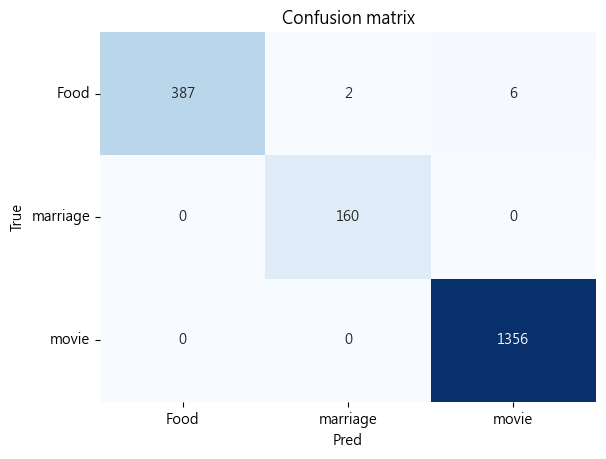

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### TF-IDF

ÊîπË©¶Ë©¶Áúã‰ΩøÁî® TF-IDF ÁöÑ DTM ‰æÜ‰ª£Ë°®ÊñáÁ´†ÔºåË®ìÁ∑¥ÂàÜÈ°ûÊ®°ÂûãÁöÑÊïàÊûú

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

‰∏Ä‰∫∫   ‰∏Ä‰Ωç        ‰∏ÄÂçä   ‰∏ÄÂè•        ‰∏ÄÂêå   ‰∏ÄÂêç        ‰∏ÄÂ†Ü        ‰∏ÄÂ†¥        ‰∏ÄÂ§ß  \
0     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
1     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
2     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.114106  0.000000   
3     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
4     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
...   ...  ...       ...  ...       ...  ...       ...       ...       ...   
4452  0.0  0.0  0.000000  0.0  0.047581  0.0  0.000000  0.000000  0.000000   
4453  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.052985   
4454  0.0  0.0  0.140344  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
4455  0.0  0.0  0.000000  0.0  0.000000  0.0  0.128413  0.000000  0.000000   
4456  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   

       ‰∏ÄÂπï  ...   È≠îÊ≥ï   ÈÆ≠È≠ö   ÈÆÆÁîú   È∫•Âü∫   È∫ªËæ£   Èªë‰∫∫   ÈªëÊöó   Èªû‰∫Ü   ÈªûÈ§ê        ÈºìÂãµ  
0     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
1     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
2     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
3     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
4     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  
4452  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.048422  
4453  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
4454  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
4455  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
4456  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  

[4457 rows x 1000 columns]

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       395
    marriage       1.00      0.99      0.99       160
       movie       0.99      1.00      1.00      1356

    accuracy                           0.99      1911
   macro avg       1.00      0.99      0.99      1911
weighted avg       0.99      0.99      0.99      1911



ÊïàÊûú‰∏ÄÊ®£‰πüÊòØ‰∏çÈåØÔºåÂèØËÉΩÂõ†ÁÇ∫‰∏âÂÄãÁâàÔºàÂ©öÂßª„ÄÅÈ£üÁâ©„ÄÅÈõªÂΩ±ÔºâÁöÑÂÖßÂÆπÊú¨‰æÜÂ∞±ÊúâÂæàÂ§ßÁöÑÂ∑ÆÁï∞ÔºåÁî®Â≠óÈÅ£Ë©ûÊúÉ‰∏çÂêå„ÄÇ

### CV

cross-validation ÊúÉËá™ÂãïÂàáÊàê k ÁµÑ train-test dataset„ÄÇ  
`cross_validate()` ÊúÉÂõûÂÇ≥Á∂ìÈÅé cross-validation ÁöÑÊ®°ÂûãË©ï‰º∞ÁµêÊûú„ÄÇ

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.05484843, 0.04591203, 0.04191947, 0.0478723 , 0.04188871]),
 'score_time': array([0.01991844, 0.01894808, 0.01695299, 0.0169549 , 0.01595688]),
 'test_f1_macro': array([0.98026145, 0.9828497 , 0.97949854, 0.97981554, 0.98895897]),
 'test_precision_macro': array([0.99429756, 0.99480789, 0.9953271 , 0.99481597, 0.9968652 ]),
 'test_recall_macro': array([0.96720061, 0.97158658, 0.9652459 , 0.96604736, 0.98137762])}


`cross_val_predict()` ÂâáÊúÉÂõûÂÇ≥ cv È†êÊ∏¨ÁöÑÈ°ûÂà•„ÄÇ

In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       917
    marriage       1.00      0.93      0.97       378
       movie       0.99      1.00      0.99      3162

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457



### ÊØîËºÉ‰∏çÂêåÊ®°ÂûãÊïàÊûú

In [ ]:
# ÂÆöÁæ©Ê®°ÂûãË®ìÁ∑¥ÁµÑÂêà
## pipeline: Ë≥áÊñôËôïÁêÜ vectorizer + ÂàÜÈ°ûÂô® clf
## Áî±Êñº cross-validation ÊúÉËá™ÂãïÂ∞áË≥áÊñôÂàÜÊàê train/testÔºåÂõ†Ê≠§ input Âè™Ë¶ÅÁµ¶ X, y Âç≥ÂèØ

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       917
    marriage       1.00      0.93      0.97       378
       movie       0.99      1.00      0.99      3162

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457



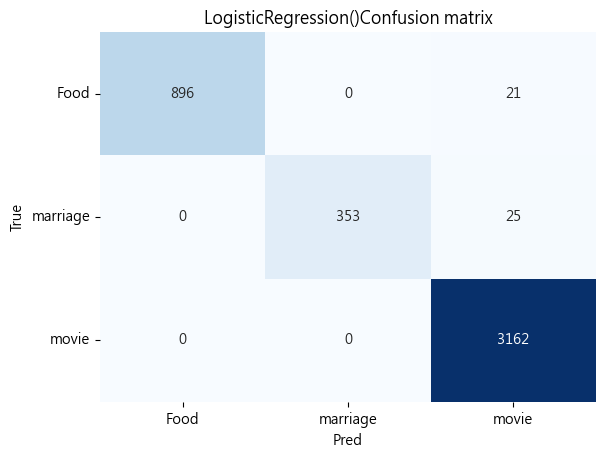

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       917
    marriage       1.00      0.93      0.97       378
       movie       0.99      1.00      0.99      3162

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457

now training: clf_dtree
              precision    recall  f1-score   support

        Food       0.99      0.99      0.99       917
    marriage       0.94      0.95      0.94       378
       movie       0.99      0.99      0.99      3162

    accuracy                           0.99      4457
   macro avg       0.97      0.98      0.98      4457
weighted avg       0.99      0.99      0.99      4457

now training: clf_svm
              precision    recall  f1-score   support

        Food       1.00      0.99      1.00       917
    marriage       1.00      0.97      0.98       378
  

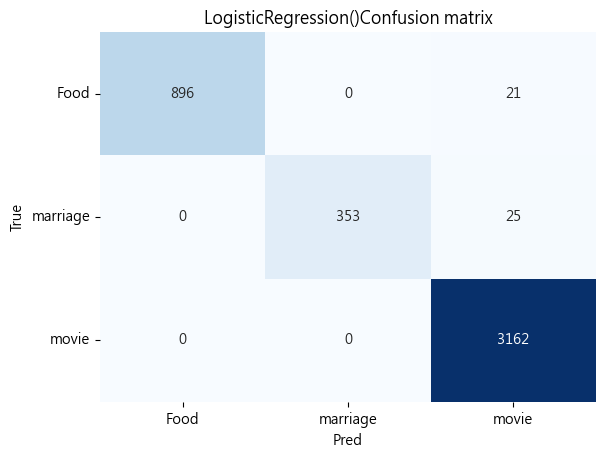

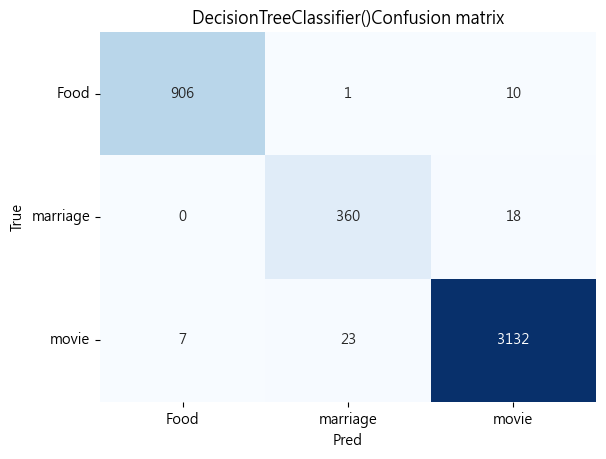

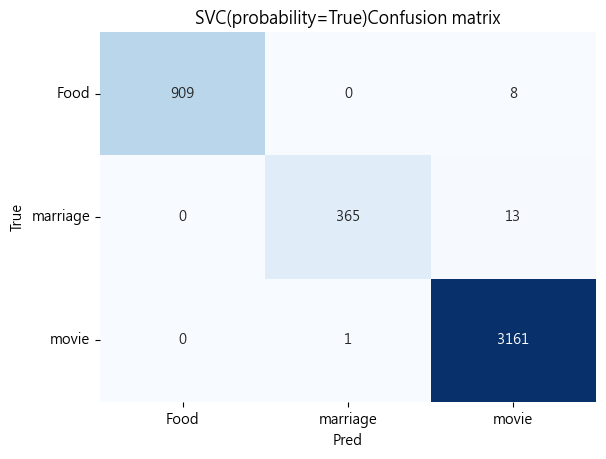

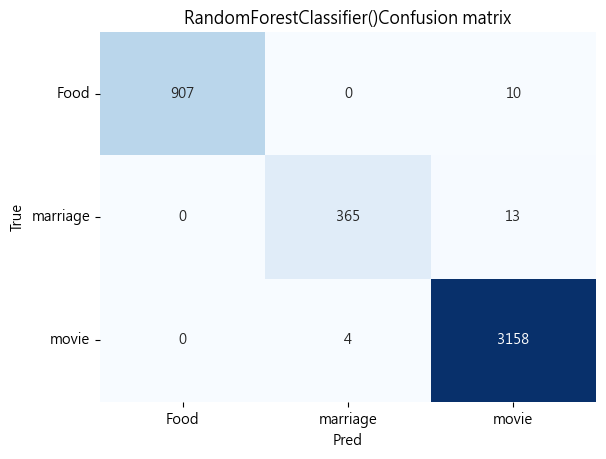

In [ ]:
# Ê∫ñÂÇôË®ìÁ∑¥Ë≥áÊñô
X = data["words"]
y = data["artCatagory"]

# ÊääÊï¥ÂÄãË≥áÊñôÈõÜ‰∏É‰∏âÂàá
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# ÂÆöÁæ©Ê®°ÂûãË®ìÁ∑¥ÁµÑÂêà
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # Ë¶Å‰ΩøÁî®SVMÁöÑpredict_probaÁöÑË©±ÔºåÂøÖÈ†àÂú®Âè´Âá∫SVCÁöÑÊôÇÂÄôÂ∞±Â∞áprobabilityË®≠ÁÇ∫True
model_set['clf_rf'] = RandomForestClassifier()
# ÂÆöÁæ© vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# Â≠òÁµêÊûú
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


ÂàÜÂà•ËßÄÂØüÂêÑÂÄãÂàÜÈ°ûÊ®°ÂûãÂú®‰∏çÂêåÈ°ûÂà•ÁöÑË©ï‰º∞ÊåáÊ®ôË°®ÁèæÂ¶Ç‰Ωï

In [ ]:
result_set['clf_logistic']

{'Food': {'precision': 1.0,
  'recall': 0.9770992366412213,
  'f1-score': 0.9884169884169884,
  'support': 917.0},
 'marriage': {'precision': 1.0,
  'recall': 0.9338624338624338,
  'f1-score': 0.9658002735978112,
  'support': 378.0},
 'movie': {'precision': 0.9856608478802993,
  'recall': 1.0,
  'f1-score': 0.9927786499215071,
  'support': 3162.0},
 'accuracy': 0.9896791563832175,
 'macro avg': {'precision': 0.9952202826267665,
  'recall': 0.9703205568345518,
  'f1-score': 0.9823319706454355,
  'support': 4457.0},
 'weighted avg': {'precision': 0.9898271485298421,
  'recall': 0.9896791563832175,
  'f1-score': 0.9895932180502931,
  'support': 4457.0}}

+ ÊâæÂá∫f1-scoreË°®ÁèæÊúÄÂ•ΩÁöÑÊ®°ÂûãÊòØÂì™ÂÄãÔºå‰ΩúÁÇ∫ÊàëÂÄëÊúÄÁµÇÂæóÂà∞ÁöÑÂàÜÈ°ûÂô®

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'Food': {'f1-score': 0.9956188389923329,
          'precision': 1.0,
          'recall': 0.9912758996728462,
          'support': 917.0},
 'accuracy': 0.9950639443571909,
 'macro avg': {'f1-score': 0.9911112636864932,
               'precision': 0.9968893788947163,
               'recall': 0.9855227032489466,
               'support': 4457.0},
 'marriage': {'f1-score': 0.9811827956989247,
              'precision': 0.9972677595628415,
              'recall': 0.9656084656084656,
              'support': 378.0},
 'movie': {'f1-score': 0.9965321563682219,
           'precision': 0.9934003771213074,
           'recall': 0.9996837444655281,
           'support': 3162.0},
 'weighted avg': {'f1-score': 0.9950424614239354,
                  'precision': 0.9950862027310584,
                  'recall': 0.9950639443571909,
                  'support': 4457.0}}


In [ ]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Food       1.00      0.98      0.99       395
    marriage       1.00      1.00      1.00       160
       movie       0.99      1.00      1.00      1356

    accuracy                           1.00      1911
   macro avg       1.00      0.99      1.00      1911
weighted avg       1.00      1.00      1.00      1911



In [ ]:
model_set['clf_rf'].predict(vectorizer.transform(["Ëè≤ÂæãË≥ì Â§ßÂ≠∏ Ë¶ÅÊ±Ç Â∏∂Èò≤ ‰ΩúÂºä ÊÜ§ÊÄí ÁöÆÂç°‰∏ò ÂêåÂè∞ Êù±Ê£Æ Êñ∞ËÅû Ëè≤ÂæãË≥ì ‰∏ÄÂêç Â§ßÂ≠∏ÊïôÊéà"]).toarray())

array(['movie'], dtype=object)

* ÊúÄ‰Ω≥ÁöÑ model ÁÇ∫ Random ForestÔºåÂÖ∂È§ò model ÔºàLogistic„ÄÅSVM„ÄÅDecision TreeÔºâË°®ÁèæÂ∑Æ‰∏çÂ§ö„ÄÇ

### ÂàÜÊûêÂèØËß£ÈáãÊ®°ÂûãÁöÑÁµêÊûú

#### ÂêÑÂ≠óË©ûÁâπÂæµÁöÑËø¥Ê≠∏‰øÇÊï∏
Â∞çÊñºÁ∑öÊÄßÁöÑÊ®°ÂûãÔºåÂèØ‰ª•ËóâÁî±Áõ∏Èóú‰øÇÊï∏ÔºåÊü•ÁúãË≥áÊñôÁâπÂæµÔºàË©ûÔºâÂ∞çÊñºÂà§Êñ∑ÂàÜÈ°ûÁöÑÂΩ±Èüø
+ Ëø¥Ê≠∏‰øÇÊï∏Ôºàcoefficient estimatesÔºâÂèçÊò†‰∫ÜÊØèÂÄãÁâπÂæµÂ∞çÈ†êÊ∏¨ÁµêÊûúÁöÑÂΩ±ÈüøÁ®ãÂ∫¶ÂíåÊñπÂêë„ÄÇ‚ÄãÁï∂ÂÖ∂‰ªñËÆäÊï∏‰øùÊåÅ‰∏çËÆäÊôÇÔºåÊüê‰∏ÄÁâπÂæµÁöÑÂÄºÂ¢ûÂä†‰∏ÄÂÄãÂñÆ‰ΩçÔºà‰æãÂ¶ÇË©ûÈ†ªÂ¢ûÂä†1ÔºâÔºåÂÖ∂Â∞çÊáâÁöÑËø¥Ê≠∏‰øÇÊï∏Ë°®Á§∫Ë©≤ÁâπÂæµÂ∞ç‰∫ã‰ª∂ÁôºÁîüÊ©üÁéáÁöÑÂΩ±Èüø„ÄÇ
+ Ë®àÁÆóÂæåÂæóÂà∞ÂãùÁÆóÊØîÔºàodds ratioÔºâÔºåÈÄôË°®Á§∫Ë©≤ÁâπÂæµÊØèÂ¢ûÂä†‰∏ÄÂÄãÂñÆ‰ΩçÔºå‰∫ã‰ª∂ÁôºÁîüÁöÑÂãùÁÆóÔºàoddsÔºâÁõ∏Â∞çÊñºÊú™Â¢ûÂä†ÊôÇÁöÑÂÄçÊï∏ËÆäÂåñ„ÄÇ
+ ÈÄôË£°Áî®logistic regression + cv tokenizer 

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # ÈÅ∏Âá∫ÊüêÂÄãÈ°ûÂà•ÁöÑÂâç10Â§ßÂΩ±ÈüøÂäõÂ≠óË©û
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # Ë®≠ÂÆöÈ°èËâ≤

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # Ë®≠ÂÆöÁï´Â∏É
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of „Äå" + label + "„Äç label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

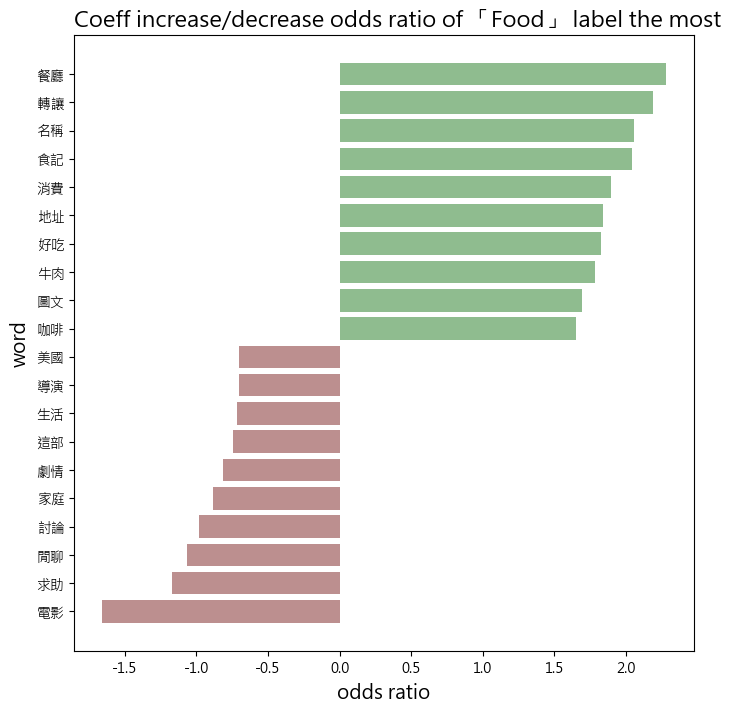

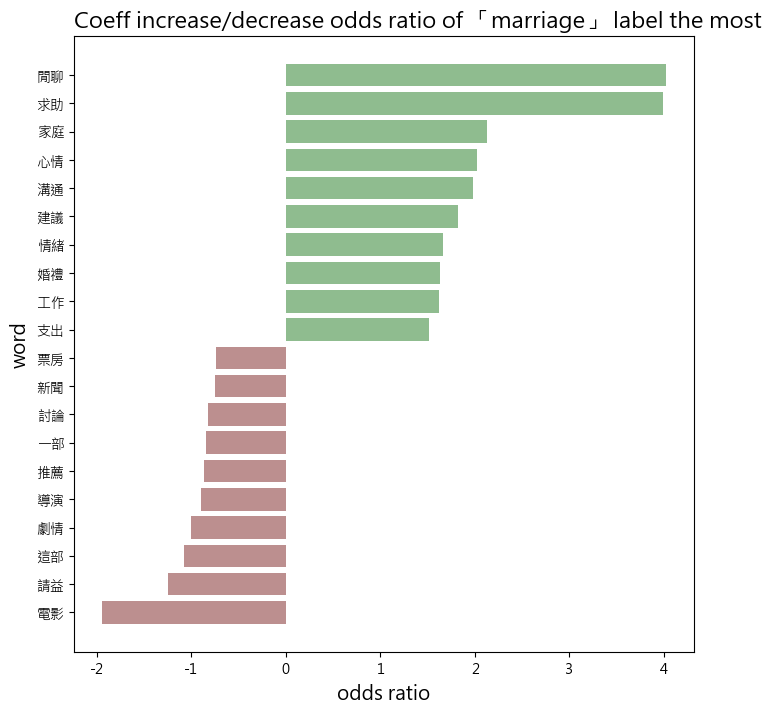

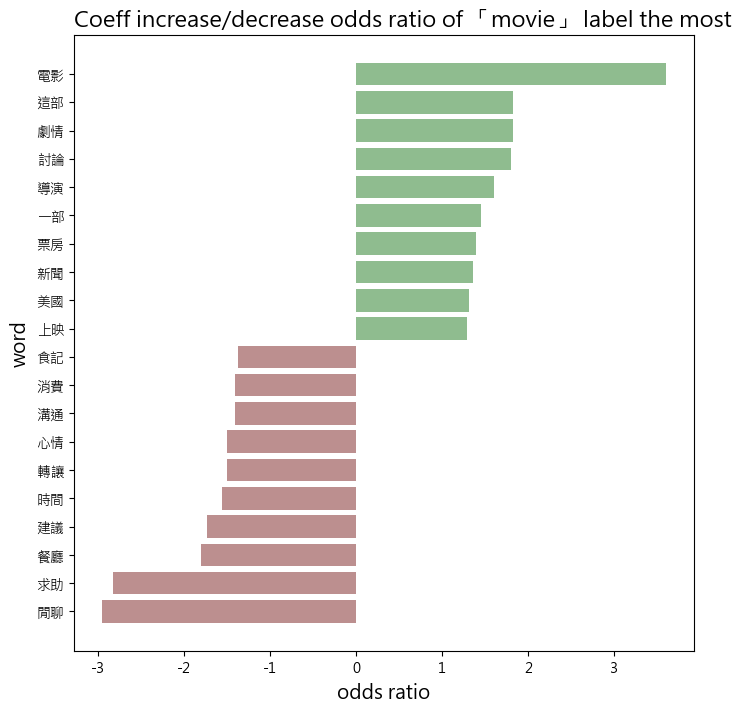

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

È£üÁâ©Áâà‰∏≠Âá∫Áèæ‰∫ÜÈ§êÂª≥„ÄÅÂêçÁ®±„ÄÅÈ£üË®òÁ≠âÈóúÈçµÂ≠óÔºõÂ©öÂßªÁâà‰∏≠È´ò‰øÇÊï∏ÁöÑÂ≠óÊòØÈñíËÅä„ÄÅÊ±ÇÂä©„ÄÅÁµêÂ©öÔºõÈõªÂΩ±ÁâàÂâáÊòØÈõªÂΩ±„ÄÅË®éË´ñ„ÄÅÂäáÊÉÖÁõ∏ÈóúÁöÑÂ≠ó„ÄÇ

# ‰ª•‰∏ãÈÇÑÊ≤íÂÅö(4/13)
 - È†êË®àÊäìÂêåÊ®£ÊùøÂ°ä(‰πüÊòØÈ£üÁâ©„ÄÅÂ©öÂßª„ÄÅÈõªÂΩ±)Ôºå‰∏çÂêåÊôÇÈñìÁöÑË≥áÊñô‰æÜÊ∏¨Ë©¶ÂàÜÈ°ûÁöÑÊïàÊûú

## 6. Áî®Ë®ìÁ∑¥Â•ΩÁöÑÂàÜÈ°ûÂô®‰æÜÈ†êÊ∏¨‰∏çÂêåÊôÇÈñìÁöÑÊñáÁ´†È°ûÂà•

`marriage.csv` ÁÇ∫Â©öÂßªÁâàË≥áÊñô`food.csv` ÁÇ∫È£üÁâ©ÁâàË≥áÊñô`movie.csv` ÁÇ∫ÈõªÂΩ±ÁâàË≥áÊñô
- ÁâàÂà•ÔºöÂ©öÂßªÁâà È£üÁâ©Áâà ÈõªÂΩ±Áâà
- ÊôÇÈñìÁØÑÂúçÔºö2024/07/01 ~ 2024/12/31
- Â∑•‰ΩúÊµÅÁ®ãÂπ≥Âè∞ÊêúÂ∞ã/ÊéíÈô§ÈóúÈçµÂ≠óÔºöÁÑ°

In [ ]:
file_list = ["food.csv", "marriage.csv", "movie.csv"]
dfs = [pd.read_csv(f) for f in file_list]
ct = pd.concat(dfs, ignore_index=True)
ct.dropna(inplace=True)
ct

system_id                                             artUrl  \
0             1  https://www.ptt.cc/bbs/Food/M.1719766782.A.1E8...   
1             2  https://www.ptt.cc/bbs/Food/M.1719798509.A.3E0...   
3             4  https://www.ptt.cc/bbs/Food/M.1719801335.A.E9F...   
4             5  https://www.ptt.cc/bbs/Food/M.1719816351.A.775...   
5             6  https://www.ptt.cc/bbs/Food/M.1719826239.A.56A...   
...         ...                                                ...   
7384       5018  https://www.ptt.cc/bbs/movie/M.1735655285.A.D4...   
7385       5019  https://www.ptt.cc/bbs/movie/M.1735657556.A.1F...   
7386       5020  https://www.ptt.cc/bbs/movie/M.1735657665.A.DC...   
7387       5021  https://www.ptt.cc/bbs/movie/M.1735659247.A.A7...   
7388       5022  https://www.ptt.cc/bbs/movie/M.1735659686.A.04...   

                        artTitle              artDate     artPoster  \
0           [È£üË®ò]Âè∞‰∏≠Ëá≠Â±Å‰ªôËá≠Ë±ÜËÖêÔºåËòøËîîÁ≥ïÊâçÊòØÈáçÈªû  2024-07-01 00:59:39  minglong1985   
1             [ËΩâËÆì]RAW7/1318:302‰Ωç  2024-07-01 09:48:27      F1orance   
3          [È£üË®ò]Ê°ÉÂúí-Êó•ÂºèÁ≤æÁ∑ªÂêÉÂà∞È£Ω-Ê¨£ËëâÊó•ÂºèÊñôÁêÜ  2024-07-01 10:35:31       Guyinkt   
4                           [ËΩâËÆì]  2024-07-01 14:45:49       asewgek   
5        [È£üË®ò]Ë•øÁè≠ÁâôÂ∑¥Â°ûÈöÜÁ¥ç‰∏≠È§êÂª≥-ÊÇÖ‰æÜÂ∞èÈ§®ÁÖéÈ§ÖÊûúÂ≠ê  2024-07-01 17:30:37       vikimsw   
...                          ...                  ...           ...   
7384    [Ë®éË´ñ]2024ÁµêÊùü‰∫ÜÔºå‰ΩÜÈ©öÂ•áÈöäÈï∑ÁöÑËôßÊêçÈÇÑÂú®ÊåÅÁ∫å  2024-12-31 22:28:02      hellofox   
7385              [ÂøÉÂæó]2024ÈÄ≤Â†¥ËßÄÂΩ±ÂõûÈ°ß  2024-12-31 23:05:54      roadrise   
7386  [Â•ΩÈõ∑]ÂîêÈ†ìËéäÂúíDowntonAbbey2019ÈõªÂΩ±  2024-12-31 23:07:43       zzauber   
7387                 [Â•ΩÈõ∑]Áï∂ÂìàÂà©Á¢∞‰∏äËééËéâ  2024-12-31 23:34:05     tilwemeet   
7388    [Êñ∞ËÅû]ÂäõÊå∫ÊõæÂØ∂ÂÑÄ„Ää‰∫§ÊèõÁ¶ÆÁâ©„ÄãÂØ∂Â™Ω3Â∫¶ÁΩπÁôå‰ªçË±ÅÈÅî  2024-12-31 23:41:23    hvariables   

     artCatagory                                         artContent  \
0           Food  È§êÂª≥ÂêçÁ®±ÔºöËá≠Â±Å‰ªôËá≠Ë±ÜËÖê\n   Ê∂àË≤ªÊôÇÈñìÔºö2024Âπ¥/6Êúà\n   Âú∞ÂùÄÔºöÂè∞‰∏≠Â∏ÇÂçóÂçÄÂª∫ÂúãÂçóË∑Ø...   
1           Food  È§êÂª≥ÂêçÁ®±ÔºöRAW Collective Memories\n   Âú∞ÂùÄÔºöÂè∞ÂåóÂ∏Ç‰∏≠Â±±ÂçÄÊ®ÇÁæ§‰∏âË∑Ø...   
3           Food  Ê∂àË≤ªÊôÇÈñìÔºö2024Âπ¥/05Êúà\n\nË™™Âà∞Êó•ÂºèÂêÉÂà∞È£ΩÁèæÂú®Áï∂ÁÑ∂Êó≠ÈõÜÁï∂Á¥Ö\n‰ΩÜÂèØÂà•Âøò‰∫Ü‰πãÂâçÈÇÑÊúâ‰∏ÄÂÆ∂...   
4           Food  È§êÂª≥ÂêçÁ®±ÔºöÊåΩËÇâ„Å®Á±≥\nÂú∞ÂùÄÔºöÂè∞ÂåóÂ∏Ç‰∏≠Â±±ÂçÄÂø†Â≠ùÊù±Ë∑Ø‰∫åÊÆµ9Ëôü\nË®Ç‰ΩçÊó•ÊúüÊôÇÈñìÔºö07/02 13Ôºö...   
5           Food  Âú®Ë•øÁè≠ÁâôÂ∑¥Â°ûÈöÜÁ¥çÊóÖÈÅäÊúüÈñìÔºå\n\nÊÉ≥ÂêÉ‰ªÄÈ∫ºÂ∞±Âú®Ë∞∑Ê≠åÊü•‰ªÄÈ∫ºÔºåÊàñËÄÖÂïèÂïèÁ∂≤ÂèãÊúâÊ≤íÊúâÊé®Ëñ¶ÁöÑÈ§êÂª≥Ôºå\n...   
...          ...                                                ...   
7384       movie  ‰ªäÂ§©ÊòØ2024Âπ¥ÁöÑÊúÄÂæå‰∏ÄÂ§©ÔºåÂ•ΩËêäÂ°¢Á•®Êàø‰∏ãÂçäÂπ¥Âú®Ëø™Â£´Â∞º„ÄäËÖ¶Á≠ã„Äã„ÄÅ„ÄäÊµ∑Ê¥ã„ÄãÁ≠âÂãïÁï´ÁâáÁ∫åÈõÜ\n\nÁöÑ...   
7385       movie  ÔºíÔºêÔºíÔºîÊúÄÂæå‰∏ÄÂ§©ÂÅöÂÄãÂõûÈ°ß\n\n\nÈÄôÂ∑≤Á∂ìÊòØÁ¨¨‰∏âÂπ¥ÂØ´ÂõûÈ°ß‰∫Ü\n\n\nÂéªÂπ¥ÈÄ≤Â†¥Áúã‰∫ÜÔºïÔºíÈÉ®ÁâáÔºà...   
7386       movie  Èõ∑ÊñáÈò≤Èõ∑Ë≥áË®äÈ†Å\n\n‰∏≠ËèØÈõª‰ø°MOD‰∏äÊû∂\n\n„ÄäÂîêÈ†ìËéäÂúí„ÄãÈõªÂΩ±ÁâàÔºåÊèèËø∞20‰∏ñÁ¥ÄÊó©ÊúüÔºåÊìÅÊúâËéä...   
7387       movie  ÂÖàÁ•ùÂ§ßÂÆ∂Êñ∞Âπ¥Âø´Ê®Ç,Â∏åÊúõÂ§ßÂÆ∂Ê∏°ÈÅé‰∫ÜÈñãÂøÉÁöÑ2024\n‰πüÂ∏åÊúõÈõªÂΩ±‰πãÁ•ûÊé•‰∏ã‰æÜ‰øù‰ΩëÊàëÂÄëÈÅ†Èõ¢ÁàõÁâáÊé•ËøëÁ•û...   
7388       movie  https://www.chinatimes.com/newspapers/20241231...   

                                             artComment             e_ip  \
0                                                    []  220.132.134.131   
1                                                    []     42.70.109.51   
3                                                    []     27.51.35.116   
4     [{"cmtStatus": "‚Üí", "cmtPoster": "asewgek", "c...  118.231.185.228   
5                                                    []       1.200.14.6   
...                                                 ...              ...   
7384  [{"cmtStatus": "‚Üí", "cmtPoster": "darkbrigher"...  223.139.253.243   
738

In [ ]:
# ÁßªÈô§Á∂≤ÂùÄÊ†ºÂºè
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# Áïô‰∏ã content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # ÊñáÁ´†ÂÖßÂÆπ ÊñáÁ´†ÈÄ£Áµê

# Ë®≠ÂÆöÊñ∑Ë©û function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â§ßÊñº1ÁöÑË©ûÂΩô
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

content  \
0  [È£üË®ò]Âè∞‰∏≠Ëá≠Â±Å‰ªôËá≠Ë±ÜËÖêÔºåËòøËîîÁ≥ïÊâçÊòØÈáçÈªûÈ§êÂª≥ÂêçÁ®±ÔºöËá≠Â±Å‰ªôËá≠Ë±ÜËÖê\n   Ê∂àË≤ªÊôÇÈñìÔºö2024Âπ¥...   
1  [ËΩâËÆì]RAW7/1318:302‰ΩçÈ§êÂª≥ÂêçÁ®±ÔºöRAW Collective Memories...   
3  [È£üË®ò]Ê°ÉÂúí-Êó•ÂºèÁ≤æÁ∑ªÂêÉÂà∞È£Ω-Ê¨£ËëâÊó•ÂºèÊñôÁêÜÊ∂àË≤ªÊôÇÈñìÔºö2024Âπ¥/05Êúà\n\nË™™Âà∞Êó•ÂºèÂêÉÂà∞È£Ω...   
4  [ËΩâËÆì]È§êÂª≥ÂêçÁ®±ÔºöÊåΩËÇâ„Å®Á±≥\nÂú∞ÂùÄÔºöÂè∞ÂåóÂ∏Ç‰∏≠Â±±ÂçÄÂø†Â≠ùÊù±Ë∑Ø‰∫åÊÆµ9Ëôü\nË®Ç‰ΩçÊó•ÊúüÊôÇÈñìÔºö07/02...   
5  [È£üË®ò]Ë•øÁè≠ÁâôÂ∑¥Â°ûÈöÜÁ¥ç‰∏≠È§êÂª≥-ÊÇÖ‰æÜÂ∞èÈ§®ÁÖéÈ§ÖÊûúÂ≠êÂú®Ë•øÁè≠ÁâôÂ∑¥Â°ûÈöÜÁ¥çÊóÖÈÅäÊúüÈñìÔºå\n\nÊÉ≥ÂêÉ‰ªÄÈ∫ºÂ∞±Âú®...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/Food/M.1719766782.A.1E8...        Food   
1  https://www.ptt.cc/bbs/Food/M.1719798509.A.3E0...        Food   
3  https://www.ptt.cc/bbs/Food/M.1719801335.A.E9F...        Food   
4  https://www.ptt.cc/bbs/Food/M.1719816351.A.775...        Food   
5  https://www.ptt.cc/bbs/Food/M.1719826239.A.56A...        Food   

                                               words  
0  È£üË®ò Ëá≠Â±Å Ëá≠Ë±ÜËÖê ËòøËîî ÈáçÈªû È§êÂª≥ ÂêçÁ®± Ëá≠Â±Å Ëá≠Ë±ÜËÖê Ê∂àË≤ª ÊôÇÈñì 2024 Âú∞ÂùÄ Âè∞‰∏≠Â∏Ç...  
1  ËΩâËÆì RAW7 1318 302 È§êÂª≥ ÂêçÁ®± RAW Collective Memories...  
3  È£üË®ò Ê°ÉÂúí Êó•Âºè Á≤æÁ∑ª Ê¨£Ëëâ Êó•Âºè ÊñôÁêÜ Ê∂àË≤ª ÊôÇÈñì 2024 05 Êó•Âºè Êó≠ÈõÜ Áï∂Á¥Ö Âà•Âøò...  
4  ËΩâËÆì È§êÂª≥ ÂêçÁ®± ÊåΩËÇâ Âú∞ÂùÄ Âè∞ÂåóÂ∏Ç Â±±ÂçÄ Âø†Â≠ùÊù±Ë∑Ø Ë®Ç‰Ωç Êó•Êúü ÊôÇÈñì 07 02 13 0...  
5  È£üË®ò Ë•øÁè≠Áâô Â∑¥Â°ûÈöÜÁ¥ç ‰∏≠È§êÂª≥ ÊÇÖ‰æÜ Â∞èÈ§® ÁÖéÈ§ÖÊûúÂ≠ê Ë•øÁè≠Áâô Â∑¥Â°ûÈöÜÁ¥ç ÊóÖÈÅä ÊúüÈñì Ê≠åÊü• Âïè...

ËßÄÂØü‰∏Ä‰∏ãË≥áÊñôÈõÜÁöÑÂàÜ‰ΩàÁãÄÊ≥Å

In [ ]:
ct['artCatagory'].value_counts()

artCatagory
movie       4958
Food        1650
marriage     684
Name: count, dtype: int64

Â∞áÊù±Ê£ÆÁöÑÊñ∞ËÅûÈ°ûÂà•Áµ¶ÈáçÊñ∞mappingÂà∞ÊàëÂÄëÂàÜÈ°ûÂô®ÁöÑÈ°ûÂà•ÔºåÊé•ËëóÈñãÂßãÈÄ≤Ë°åÂàÜÈ°û‰ªªÂãô

Âõ†ÁÇ∫labelÁõ∏ÂêåÁÑ°È†àÈáçÊñ∞mapping

In [ ]:
X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))



              precision    recall  f1-score   support

        Food       1.00      0.98      0.99      1650
    marriage       0.97      0.86      0.91       684
       movie       0.98      1.00      0.99      4958

    accuracy                           0.98      7292
   macro avg       0.98      0.95      0.96      7292
weighted avg       0.98      0.98      0.98      7292



Âæûclassification reportÂèØ‰ª•ÁôºÁèæÔºåÂú®Êù±Ê£ÆÊñ∞ËÅûÁöÑË≥áÊñôÈõÜ‰∏äÔºåÂâçÈù¢Ë®ìÁ∑¥ÂæóÂà∞ÁöÑÂàÜÈ°ûÂô®Âú®ÈÄôÈÇäË°®Áèæ‰∏¶‰∏çÂ•Ω

Êé•ËëóÈÄ≤‰∏ÄÊ≠•Á†îÁ©∂ÂàÜÈ°ûÁöÑÁµêÊûúÔºåÂòóË©¶ÊâæÂá∫ÂïèÈ°åÁöÑÂéüÂõ†

In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

words artCatagory   pred
0     È£üË®ò Ëá≠Â±Å Ëá≠Ë±ÜËÖê ËòøËîî ÈáçÈªû È§êÂª≥ ÂêçÁ®± Ëá≠Â±Å Ëá≠Ë±ÜËÖê Ê∂àË≤ª ÊôÇÈñì 2024 Âú∞ÂùÄ Âè∞‰∏≠Â∏Ç...        Food   Food
1     ËΩâËÆì RAW7 1318 302 È§êÂª≥ ÂêçÁ®± RAW Collective Memories...        Food   Food
3     È£üË®ò Ê°ÉÂúí Êó•Âºè Á≤æÁ∑ª Ê¨£Ëëâ Êó•Âºè ÊñôÁêÜ Ê∂àË≤ª ÊôÇÈñì 2024 05 Êó•Âºè Êó≠ÈõÜ Áï∂Á¥Ö Âà•Âøò...        Food   Food
4     ËΩâËÆì È§êÂª≥ ÂêçÁ®± ÊåΩËÇâ Âú∞ÂùÄ Âè∞ÂåóÂ∏Ç Â±±ÂçÄ Âø†Â≠ùÊù±Ë∑Ø Ë®Ç‰Ωç Êó•Êúü ÊôÇÈñì 07 02 13 0...        Food   Food
5     È£üË®ò Ë•øÁè≠Áâô Â∑¥Â°ûÈöÜÁ¥ç ‰∏≠È§êÂª≥ ÊÇÖ‰æÜ Â∞èÈ§® ÁÖéÈ§ÖÊûúÂ≠ê Ë•øÁè≠Áâô Â∑¥Â°ûÈöÜÁ¥ç ÊóÖÈÅä ÊúüÈñì Ê≠åÊü• Âïè...        Food   Food
...                                                 ...         ...    ...
7384  Ë®éË´ñ 2024 ÁµêÊùü È©öÂ•á ÈöäÈï∑ ËôßÊêç ÈÇÑÂú® ÊåÅÁ∫å 2024 Â•ΩËêäÂ°¢ Á•®Êàø ‰∏ãÂçäÂπ¥ Ëø™Â£´Â∞º ...       movie  movie
7385  ÂøÉÂæó 2024 ÈÄ≤Â†¥ ËßÄÂΩ± ÂõûÈ°ß ÂÅöÂÄã ÂõûÈ°ß Á¨¨‰∏âÂπ¥ ÂõûÈ°ß ÂéªÂπ¥ ÈÄ≤Â†¥ ÈÉ®Áâá ‰∏ÄÂà∑ ÈÄ±Êú´ Ë°å...       movie  movie
7386  Â•ΩÈõ∑ ÂîêÈ†ì ËéäÂúí DowntonAbbey2019 ÈõªÂΩ± Èõ∑Êñá Èò≤Èõ∑ Ë≥áË®ä ‰∏≠ËèØÈõª‰ø° MOD...       movie  movie
7387  Â•ΩÈõ∑ ÂìàÂà© Á¢∞‰∏ä ËééËéâ ÂÖàÁ•ù Êñ∞Âπ¥Âø´Ê®Ç Â∏åÊúõ Ê∏°ÈÅé ÈñãÂøÉ 2024 Â∏åÊúõ ÈõªÂΩ± ‰πãÁ•û ‰øù‰Ωë ...       movie  movie
7388  Êñ∞ËÅû ÂäõÊå∫ ÊõæÂØ∂ÂÑÄ ‰∫§Êèõ Á¶ÆÁâ© ÂØ∂Â™Ω ÁΩπÁôå Ë±ÅÈÅî https www chinatimes ...       movie  movie

[7292 rows x 3 columns]

Â∞áÈåØË™§ÂàÜÈ°ûÁöÑÁµêÊûúÁØ©ÈÅ∏Âá∫‰æÜ

In [ ]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

words artCatagory      pred
6     Ë´ãÁõä ÈõôÂåóÊúâ Ë™øÂë≥ Êó•Âºè ÁáíËÇâ ‰∫ãÂÖà Ë™øÂë≥ ÈπΩÈÜ¨ ÈÜ¨Ê±Å ÁöÑÁáí ËÇâÂ∫ó ÂñÆÈªû ÈõôÂåó ÂøÖÂ°´ Êñ∞Âè∞Âπ£...        Food     movie
47    Âª£ÂÆ£ Êñ∞Á´π Á´πÂåó NextStop È¶ôÊ∏Ø Êâã‰Ωú ÊñôÁêÜÂ∫ó Next Stop È¶ôÊ∏Ø Êâã‰Ωú ÊñôÁêÜ...        Food     movie
113                       Âæµ‰∫∫ 20 ‰∏≠Âçà ÂêõÊÇÖ ÊºÇ‰∫Æ Âª£Âºè È§êÂª≥ ‰Ωç‰∏Ä ÊÑèÈ°ò Ë®äÊÅØ        Food     movie
170   Ë´ãÁõä Ê£ÆÊ£Æ ÁáíËÇâ vs ËÄÅ‰∫ï ÂÉπ‰Ωç ÊúçÂãô Âë≥ÈÅì ÁáíÁÉ§ Ê£ÆÊ£Æ vs ËÄÅ‰∫ï Ë´ãÂïè Êé®Ëñ¶ ÂÉπ‰Ωç Â∑Æ...        Food     movie
173   Âæµ‰∫∫ Â§©Êú¨ 363 Â§©Êú¨ 363 ÁÜüÂÆ¢ ÂæåÁ∫å ÈñãÊîæ Ë®Ç‰Ωç ÁßÅË®ä ÂêåÊçÜ 12 00 ÂÑ™ÂÖà ÁßÅË®ä ÂëäÁü•        Food     movie
...                                                 ...         ...       ...
5840  Fw ÈñíËÅä ËêäÊÅ© Èõ∑Ë´æ Â•≥Êµ©ÂÖã ÈáëÂâõ Êà≤‰ªΩ Á†çÂÖâ ‰ΩúËÄÖ kimisawa Ê•äÂõû Chat Èñí...       movie  marriage
6296  Re ÈñíËÅä ËêäÊÅ© Èõ∑Ë´æ Â•≥Êµ©ÂÖã ÈáëÂâõ Êà≤‰ªΩ Á†çÂÖâ Ê∂àÊÅØ ‰∏≤ÊµÅ Â∞ÅÈù¢ Ê≠ª‰æç Â•≥Êµ©ÂÖã ÂúñÁâá Âèñ‰ª£...       movie  marriage
6362  ÊôÆÈõ∑ Áü≠Áâá Êî∂Êî§ Èõ≤Á´Ø Ê∂àÈò≤Èöä ÂæàËøë ÂæàÈÅ† Â∑•‰Ωú ÂÆ∂Â∫≠ Ë°°Èáè ‰πãÈáç ‰∫ãÂ∞ë Èõ¢ÂÆ∂Ëøë Â∑•‰Ωú Â§¢Âπª...       movie  marriage
6803  Fw ÈñíËÅä ËÆäÁ®Æ Â§©Ë≥¶ Â•≥‰∏ªËâæÁë™ ÊùúËíô ÊÄßÂà• ‰ΩúËÄÖ s24066774 JJ Chat ÈñíËÅä...       movie  marriage
7137  Re ÈáëÂ≠´ Êö¥ÂØå ÊîªÁï• ÁúºÊ∑ö ÁúºÁú∂ Èò≤Èõ∑ Èõ£Áúã ÂèØÁúã ÁîüÊ∞£ ÈòøÂ¨§ ÊòéÊòé ÈáçÁî∑ËºïÂ•≥ ÂÆ∂Â∫≠ Èï∑Â§ß...       movie  marriage

[141 rows x 3 columns]

ËßÄÂØüÁúãÁúãÂ©öÂßªÁâàÁöÑÊñáÁ´†ÔºåÊ®°ÂûãÁµ¶Âá∫ÁöÑÂàÜÈ°ûÁµêÊûúÊÄéÈ∫ºÊ®£

In [ ]:
false_pred.loc[false_pred['artCatagory']=='marriage', :].head(20)

words artCatagory   pred
1694  ÊîøË¶ã RuRu0421 ÂÄã‰∫∫Ë≥áÊñô Êü•Ë©¢ Á∂≤Âèã Êö±Á®± RuRu0421 Â∞èÊ∑µÊæ§Â†± ‰ºÅÈµù Á∂ìÊøü ...    marriage  movie
1702  ÊîøË¶ã amilkamilk ÂÄã‰∫∫Ë≥áÊñô Êö±Á®± amilkamilk ÊàëË¶Å ÂππË©± Á∂ìÊøü Â∞èÂ∫∑ Áôª...    marriage  movie
1715  ÊîøË¶ã charles6416 ÂÄã‰∫∫Ë≥áÊñô Êö±Á®± charles6416 0.0 Á∂ìÊøü Â∞èÂ∫∑ Áôª...    marriage  movie
1716  Re Ê±ÇÂä© Ë™øÈÅ© ÈõôËñ™ ÂæåÊè¥ ÂùêÁâ¢ 41Y 38Y ÊôÇ‰∫∫ Ëøé‰æÜ ÂØ∂Ë≤ùÂ•≥ÂÖí Áî¢ÂÅá ËÇ≤Â¨∞ ÁïôÂÅú ...    marriage  movie
1732  Re Ê±ÇÂä© Â≤≥Áà∂ Â≤≥ÊØç Ë∫´ÂøÉ ÈöúÁ§ô ÊúÄ‰Ω≥Ëß£ Â§ñÂãû ÁæéÂúã ÂßäÂßä ÁèæÂØ¶ ÊôÇÈñì Ë´á‰∏çÊîè ÂßäÂßä Âá∫Èªû...    marriage  movie
1743  Re Á§æ‰∫§ Á∫åÁìú Ê≠£Â∏∏‰∫∫ Â∞éÊ≠£ ÊÄùÊÉ≥ Ê≤íÊÉ≥Âà∞ Ê≠™Ê®ì Á∞°ÂñÆ Á∂≤Âèã È¢®Âêë Á∂≤Âèã ÈªûÂ§ö Áù°Ë¶∫ ÂõûÊñá...    marriage  movie
1744  Re Á§æ‰∫§ Á∫åÁìú ÊæÑÊ∏Ö Âù¶Ëï©Ëï© Ë≥™Áñë ‰∫∫Ê†º ÂÅöÊ≥ï ‰Ω†ÈÇÑ ‰πæËÑÜ Â§ßÊñπ Âá∫Ëªå Áï∂Êàê Áµ¶‰Ω† Â†±Âæ© ...    marriage  movie
1747  Re Á§æ‰∫§ Á∫åÁìú Ê¥óÊæ° Áì¶ÊñØ Êãø‰æÜ ÁÖÆÈ£Ø ÂÖ©Ê°∂ Áì¶ÊñØ ‰∏ÄÊ°∂ ‰∏ÄÊ°∂ ÂÖàÈ†Ç ËëóÁî® ‰ªòÂá∫ Ë∂ÖÂá∫ ÂàÜ...    marriage  movie
1753  Re Ê±ÇÂä© ËÆäÂæó Êµ™Êº´ Êµ™Êº´ Â∏∂‰Ω†Âéª ÂèÉÂä† ÁêÉÂúò ËÅöÈ§ê ÈÇÑ‰∏çÂøò ÁõõÊπØ Â§æËèú È†≠È´Æ Á®±ËÆö È´ÆÂûã...    marriage  movie
1754  Re Ê±ÇÂä© ËÆäÂæó Êµ™Êº´ ÂøÉÁêÜÂ≠∏ Ë™≤Êú¨ Êµ™Êº´ ËÇâÈ´î Èï∑‰πÖ Ë±°Âæµ Ê∫´Êöñ ÈóúÊá∑ Âèã‰º¥ Èï∑‰πÖ ‰∏àÂ§´ ...    marriage  movie
1759  Re Ê±ÇÂä© ËÆäÂæó Êµ™Êº´ ÂÖàË™™ ÁµêË´ñ ÈÜíÈÜí ÈÄô‰Ωç Â©öÂæå ÁØÄÊó• Ê≤íÈÄÅ ÈÅéÁ¶Æ Âú®Â§ñ ÁâΩÊâã Â§öÂπ¥ Âßã...    marriage  movie
1760  Re Ê±ÇÂä© ËÆäÂæó Êµ™Êº´ Êµ™Êº´ ËßíÂ∫¶ Á¶ÆÁâ© Êî∂Á©´ ‰ªòÂá∫ Êµ™Êº´ Êî∂Á©´ Êµ™Êº´ ÂÖ©‰∫∫ ‰ªòÂá∫ Â¶≥ÊòØ Êµ™...    marriage  movie
1766  Re ÂøÉÊÉÖ ÁôºÁöÑÊñá ÂØ´Áµ¶ Â∞è‰∏â‰ø° Ê®°Ê®£ ÁèçÊÉú ÊÑõË≠∑ Âü∑Ëëó È´îÊúÉ ÁêÜËß£ ÊïÖ‰∏çÂ§ö Ê∂àÂ§± ÂÜ∑Êà∞ Âª∫...    marriage  movie
1770  Re ÂøÉÊÉÖ ÊñáÂè™ È¢±È¢®Â§© ÁßªËªä ÂØ¶Âú® È®éËªäÂà∞ ËªäÁ´ô ‰∏çÂêàÁêÜ ‰∏äÁè≠ È†ÜË∑Ø ÂÖ¨Âè∏ ËªäÂ≠ê ‰øùË≠∑ È†Ü...    marriage  movie
1778  Re ÈÇÑÊúÉÁµê ‰ΩéÁ´Ø Ëø∑‰ø° ‰∫∫Âè£ Â©öÊúü Â∞è‰∫ã Êó•Âæå ‰∏ÄÂ†Ü È¢®Ê∞¥ ‰∫ãÊ•≠ Áîü‰∏çÂá∫ È†≠‰∏ä Áî∑Âèã Âò¥Áîü...    marriage  movie
1779             Re ÈÇÑÊúÉÁµê Áî∑Âèã ‰∏çÂù¶ Â§ßÂ´Ç ËààÈ¢®‰ΩúÊµ™ Áµê‰∫Ü Âêû‰∏ãÂéª ËÖ¶Â≠ê Â©öÂæå PttX    marriage  movie
1785  ÁôªË®ò Â•≥Âèã ÊÑèÂ§ñ Êá∑Â≠ï Â•≥Âèã Ë°®ÈÅî Â•≥Âèã Ë¶ÅÁîü Ë¶ÅÁï∂ ÂñÆË¶™ Ë¶ÅÁîü ÂÆ∂Èï∑ Â∏åÊúõ Âø´Âéª ÁôªË®ò Â•≥...    marriage  movie
1787  Re ÁôªË®ò Âº∑ÁÉàÂª∫Ë≠∞ ÁôªË®ò line ÊîªÊìä Â∞á‰æÜ Á¢∫Ë™ç Ë¶™Â≠ê Ë®¥Ë®ü Èò≤Á¶¶ ÊâãÊÆµ Â∞á‰æÜ ÊãíÁµï ...    marriage  movie
1789  Re ÈÇÑÊúÉÁµê ÊÉÖÂΩ¢ ‰πüË®± ÂèÉËÄÉ Ëß£Ê≥ï ÂêàÂÆå ÂÖ´Â≠ó ÂÅáÊó• Â•ΩÊó•Â≠ê ËÄÅÂ∏´ Ê≤íÈóú‰øÇ Ë®ÇÂ©ö ËøéÂ®∂ Âπ≥...    marriage  movie
1792  Re ÂøÉÊÉÖ ÁôºÁöÑÊñá ÂæåÁ∫å Êè≠Èú≤ ÈóúÈçµ Ë≥áË®ä ÂÖ¨Âè∏ ÁßüÂ±ã ËôïÊâç 500 ÂÖ¨Â∞∫ Ë†ªÁÅ´ Êï¥‰ª∂‰∫ã Èõ£...    marriage  movie

ÊåëÈÅ∏‰∏ÄÁØáÂ©öÂßªÁâàÁöÑÊñáÁ´†ËßÄÂØüÁúãÁúãÂÖßÂÆπÔºåÁÇ∫‰ΩïÊ®°ÂûãÊúÉÂ∞áÂÖ∂ÂàÜÈ°ûÊàêÈõªÂΩ±ÁâàÁöÑÊñáÁ´†

In [ ]:
pprint(false_pred['words'][1754])

('Re Ê±ÇÂä© ËÆäÂæó Êµ™Êº´ ÂøÉÁêÜÂ≠∏ Ë™≤Êú¨ Êµ™Êº´ ËÇâÈ´î Èï∑‰πÖ Ë±°Âæµ Ê∫´Êöñ ÈóúÊá∑ Âèã‰º¥ Èï∑‰πÖ ‰∏àÂ§´ Ê∫ùÈÄö ÊòéË™™ ÁîüÊÇ∂Ê∞£ ÊÆ∫Êâã Âä†Ê≤π Âä†Ê≤π Âèã‰º¥ ÊÑõÁÇ∫ Êµ™Êº´ ÊÑõÁÇ∫ '
 'Âä†Ê≤π Âä†Ê≤π')


ÈÄôÁØáÊñáÁ´†ÂØ¶ÈöõÂú®Ë®éË´ñ‰º¥‰æ∂Èóú‰øÇ‰∏≠ÁöÑÊÉÖÊÑüÂïèÈ°åÔºåÂ¶Ç„Äå‰∏àÂ§´„Äç„ÄåÂ§•‰º¥„Äç„ÄåÊ∫ùÈÄö„Äç„ÄåÈóúÊá∑„Äç„ÄåÈï∑‰πÖ„ÄçÁ≠âË©ûÈÉΩËàáÂ©öÂßªÊúâÈóú„ÄÇ‰ΩÜÊ®°ÂûãÂõ†ÁÇ∫ÁúãÂà∞ÂÉè„ÄåÊµ™Êº´„Äç„ÄåÂøÉÁêÜÂ≠∏„Äç„ÄåË±°Âæµ„Äç„ÄåÊÆ∫Êâã„ÄçÈÄô‰∫õË©ûÔºåÂÆπÊòìËÅØÊÉ≥Âà∞ÊÑõÊÉÖÈõªÂΩ±„ÄÅÂäáÊÉÖÂàÜÊûêÊàñËßíËâ≤Ë®≠ÂÆöÔºåÂõ†Ê≠§Ë™§‰ª•ÁÇ∫ÊòØ movie È°ûÊñáÁ´†„ÄÇÊ®°ÂûãÁº∫‰πèÂ∞çË™ûÂ¢ÉÁöÑÁêÜËß£ÔºåÂè™Ê†πÊìöË©ûÈ†ªËàáÈóúÈçµÂ≠óÈÄ≤Ë°åÂà§Êñ∑ÔºåÂ∞éËá¥ÂàÜÈ°ûÂ§±Ê∫ñ„ÄÇ

## Á¨¨‰πùÈÄ±Ôºö‰∏ªÈ°åÊ®°ÂûãÔºà‰∏≠ÊñáÔºâ <br>

Êú¨ÈÄ±Ë™≤Á®ãÁÇ∫ **‰∏ªÈ°åÊ®°Âûã** ÔºåÂ≠∏ÁøíÂ¶Ç‰ΩïÂ∞áÊñáÊú¨ÈÄ≤Ë°å‰∏ªÈ°åÊ®°ÂûãÂàÜÊûê„ÄÇ<br>
Êñá‰ª∂‰∏ªÈ°åÊ®°ÂûãÊé°Áî®ÈùûÁõ£Áù£ÂºèÂ≠∏ÁøíÁöÑÊñπÂºèÔºå‰∏ç‰∫ãÂÖà‰∫∫ÁÇ∫ÂÅöÊ®ôÁ±§ËàáË®ªËß£ÔºåË®ìÁ∑¥ÁöÑË≥áÊñôÊòØÂæûË≥áÊñôÊñáÊú¨Âæó‰æÜÔºåËÆìÊàëÂÄëÂèØ‰ª•Ë¶èÊ®°ÂåñÁµ¶‰∫àÂ§ßÈáèÊñáÊú¨ÔºåËÄåË®ìÁ∑¥Âá∫‰∏ªÈ°åÊ®°ÂûãÔºåÂÖ∂‰∏≠ÊúÄÁÇ∫Áü•ÂêçÁÇ∫LDAÊ®°ÂûãÔºå‰πüÊòØÊú¨Ê¨°Ë™≤Á®ã‰∏ªË¶ÅÁöÑÊïôÂ≠∏ÁõÆÊ®ôÔºåÊú¨ jupyter notebook ÊòØ‰ª•‰∏≠ÊñáÊñáÊú¨ÁÇ∫Á§∫ÁØÑ„ÄÇ<br>
ÈÄôÊ¨°Ë™≤Á®ãÂàÜÁÇ∫ÂπæÂÄãÈÉ®ÂàÜÔºö
1. Â∞áË≥áÊñôÈÄ≤Ë°åÂâçËôïÁêÜ 
2. lexicon-based ÁöÑ‰∏ªÈ°åÊ®°Âûã
3. LDA ‰∏ªÈ°åÊ®°Âûã 
4. Ë¶ñË¶∫Âåñ‰∏ªÈ°åÊ®°Âûã 
5. GuidedLDA
6. ‰∏ªÈ°åÊ®°ÂûãÁöÑÊáâÁî®

## 1. Â•ó‰ª∂Ë™™Êòé
Êú¨Ê¨°ÂØ¶‰ΩúÈÅéÁ®ã‰∏≠‰ΩøÁî®Âà∞ÁöÑÁõ∏ÈóúÂ•ó‰ª∂ÔºåÂú®Ë™≤Â†Ç‰∏≠ÊàëÂÄëÂ∞áÊúÉÁ∞°ÂñÆÁöÑÂ±ïÁ§∫ÈÄô‰∫õÂ•ó‰ª∂ÁöÑ‰ΩøÁî®ÊñπÂºèÔºåÈóúÊñºÂêÑÂÄãÂ•ó‰ª∂ÁöÑÈÄ≤Èöé‰ΩøÁî®Ë´ãÂêåÂ≠∏ÂèÉÁÖßÂÖ∂ÂÆòÁ∂≤ÁöÑË™™Êòé„ÄÇ
+ gensim: ‰∏ªÈ°åÊ®°ÂûãÂáΩÂºèÂ∫´
+ pyLDAvis: ‰∫íÂãïÂºèLDAË¶ñË¶∫ÂåñÂ•ó‰ª∂

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÈ´î
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #‰ΩøÂúñ‰∏≠‰∏≠ÊñáËÉΩÊ≠£Â∏∏È°ØÁ§∫
plt.rcParams['axes.unicode_minus'] = False #‰ΩøË≤†ËôüËÉΩÂ§†È°ØÁ§∫

## 2. Ë≥áÊñôÂâçËôïÁêÜ

In [ ]:
udn = pd.read_csv("raw_data/text.csv")  # ÂåØË≥áÊñô
udn.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/marriage/M.1610159827.A...   
1          2  https://www.ptt.cc/bbs/marriage/M.1610162736.A...   
2          3  https://www.ptt.cc/bbs/marriage/M.1610190309.A...   

             artTitle              artDate artPoster artCatagory  \
0     [Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 10:37:05  safelove    marriage   
1          Re:ËÄÅÂÖ¨Â∑•‰Ωú‰∏çÁ©©ÂÆö  2021-01-09 11:25:34     mayko    marriage   
2  Re:[Ê±ÇÂä©]ÁúüÁöÑÂèØ‰ª•‰∏çÁµ¶ÁúãÊâãÊ©üÂóéÔºü  2021-01-09 19:05:00    loser1    marriage   

                                          artContent  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÔºåÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑÔºå\n‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÔºåÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÔºå\nÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÔºü\...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆö,ÊàøÊù±Êâç‰∏çËÇØÁßü,Âè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßü,Â∞çÂêß\nÂæàÊÆòÂøçÁöÑË™™...ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé,...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÔºÅ\nÂÖàÂ∏ùÁà∫‰∏çÊòØË™™Ôºå\n‰∏ÄÈöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÔºü\nÂÖ©Èöª‰∏çÂ§†Ôºå‰∏çËÉΩËæ¶‰∏âÈöªÂóéÔºü...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "Êé®", "cmtPoster": "FlyOncidium"...  114.137.169.105   
1                                                 []    36.229.84.229   
2  [{"cmtStatus": "Âôì", "cmtPoster": "mark0204", "...  118.170.238.138   

          insertedDate dataSource  
0  2021-01-10 01:20:56        ptt  
1  2021-01-10 01:20:56        ptt  
2  2021-01-10 01:20:56        ptt

In [ ]:
# ÁßªÈô§Á∂≤ÂùÄÊ†ºÂºè
# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # ÊñáÁ´†ÂÖßÂÆπ ÊñáÁ´†ÈÄ£Áµê
udn.head(3)

content  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/marriage/M.1610159827.A...    marriage   
1  https://www.ptt.cc/bbs/marriage/M.1610162736.A...    marriage   
2  https://www.ptt.cc/bbs/marriage/M.1610190309.A...    marriage   

              artDate  
0 2021-01-09 10:37:05  
1 2021-01-09 11:25:34  
2 2021-01-09 19:05:00

In [ ]:
# Ë®≠ÂÆöÁπÅÈ´î‰∏≠ÊñáË©ûÂ∫´
jieba.set_dictionary("./dict/dict.txt.big")

# Êñ∞Â¢ûstopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tagsÊâçÊúÉ‰ΩúÁî®
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

stopWords.extend(["Ë¶∫Âæó", "ÁúüÁöÑ", "ÁèæÂú®", "ÂïèÈ°å", "Áü•ÈÅì", "‰∫ãÊÉÖ", "ÊáâË©≤", "ÈúÄË¶Å", "ÊØîËºÉ", "Â∑•‰Ωú"])
# Ë®≠ÂÆöÊñ∑Ë©û function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â§ßÊñº1ÁöÑË©ûÂΩô
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /Users/hank/Desktop/SMA_2025S/week09/dict/dict.txt.big ...
2025-04-15 23:33:50,630 : DEBUG : Building prefix dict from /Users/hank/Desktop/SMA_2025S/week09/dict/dict.txt.big ...
Loading model from cache /var/folders/8v/d43rjw7s49s8tg2qbw5vxr1h0000gn/T/jieba.u4d327844f04abaf5ca9f6002d061e27b.cache
2025-04-15 23:33:50,633 : DEBUG : Loading model from cache /var/folders/8v/d43rjw7s49s8tg2qbw5vxr1h0000gn/T/jieba.u4d327844f04abaf5ca9f6002d061e27b.cache
Loading model cost 0.417 seconds.
2025-04-15 23:33:51,049 : DEBUG : Loading model cost 0.417 seconds.
Prefix dict has been built successfully.
2025-04-15 23:33:51,050 : DEBUG : Prefix dict has been built successfully.


content  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   
3  ÂÖ∂ÂØ¶ÈÉΩÊòØÂ∞è‰∫ã‰ΩÜÈÉΩÂèØ‰ª•ÂêµÂà∞Èõ¢Â©öÂèØËÉΩÊàëÂÄëÂ∞±ÊòØÂπæÊ≠≤ÁöÑÂ∞èÂ≠©Êò®Êôö‰∏äÂ∫äÁù°Ë¶∫Âæå‰∏ÄÁõ¥Ë¶∫ÂæóÂæàÂÜ∑ËÄÅÂÖ¨‰πüÂñäÂÜ∑ÊÉ≥Ë™™Áù°...   
4  ÊääÊ£âË¢´ÁøªÂ•ΩÊ≠£Èù¢ÂóØÂóØÊúâÂóØÈÇ£‰Ω†ÂππÂòõÊä±ÊÄ®‰Ω†ËÄÅÂÖ¨‰∏çÊòØË™∞‰∏äÂ∫äÁù°Ë¶∫ÈÇÑÊúÉÊ™¢Êü•Ê£âË¢´Ê≠£ÂèçÁöÑÂóéÊàëÊàë‰πüË¶∫Âæó‰Ω†ÂçäÂ§úÂè´...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/marriage/M.1610159827.A...    marriage   
1  https://www.ptt.cc/bbs/marriage/M.1610162736.A...    marriage   
2  https://www.ptt.cc/bbs/marriage/M.1610190309.A...    marriage   
3  https://www.ptt.cc/bbs/marriage/M.1610193770.A...    marriage   
4  https://www.ptt.cc/bbs/marriage/M.1610203445.A...    marriage   

              artDate                                              words  
0 2021-01-09 10:37:05  [ÂÅ∑Áúã, ÊâãÊ©ü, Â∑≤Á∂ì, ÁµêÂ©ö, Â§™Â§™, ÊâãÊ©ü, ÊãíÁµï, ÊÑüË¶∫, ÊãíÁµï, ÂøÉË£°, ÊúâÈ¨º, Â§™...  
1 2021-01-09 11:25:34  [Áî∑Êñπ, Á©©ÂÆö, ÊàøÊù±, ‰∏çËÇØ, Âè™Â•Ω, Â•≥Áîü, ÊâøÁßü, ÊÆòÂøç, ÁÑ°Á∑£, Â≠©Â≠ê, ËÅ∞Êòé, ‰æÜ...  
2 2021-01-09 19:05:00  [ÊâãÊ©ü, Áµ¶Áúã, ÂÖàÂ∏ù, ‰∏ÄÈöª, ‰∏çÂ§†, ÂÖ©Èöª, ÂÖ©Èöª, ‰∏çÂ§†, ‰∏âÈöª, ‰∏âÈöª, ÂõõÈöª, ‰∏ç...  
3 2021-01-09 20:02:46  [Â∞è‰∫ã, ÂêµÂà∞, Èõ¢Â©ö, ÂπæÊ≠≤, Â∞èÂ≠©, Êò®Êôö, ‰∏äÂ∫ä, Áù°Ë¶∫, ‰∏ÄÁõ¥, ËÄÅÂÖ¨, ÂÜ∑ÊÉ≥, Ê∫´...  
4 2021-01-09 22:44:03  [Ê£âË¢´, Ê≠£Èù¢, ÂππÂòõ, Êä±ÊÄ®, ËÄÅÂÖ¨, ‰∏äÂ∫ä, Áù°Ë¶∫, ÈÇÑÊúÉ, Ê™¢Êü•, Ê£âË¢´, Ê≠£Âèç, Âçä...

## 3. Lexicon-based / ‰∫∫Â∑•Áµ¶ÂÆö‰∏ªÈ°åÁöÑ‰∏ªÈ°åÊ®°Âûã

In [ ]:
udn['artCatagory'].unique()

array(['marriage'], dtype=object)

#### Áî®ÂêÑÂÄã‰∏ªÈ°åÂ∏∏Ë¶ãÁöÑË©û‰æÜ‰ΩúÁÇ∫‰∏ªÈ°åÁöÑ‰ª£Ë°®Ë©û

In [ ]:
## ÂÆöÁæ©‰∏ªÈ°å
cnt = udn.loc[udn['artCatagory'] == 'marriage',:]['words'].explode().value_counts().head(100)
cnt.index

Index(['Â∞èÂ≠©', 'Èõ¢Â©ö', 'ËÄÅÂ©Ü', 'ËÄÅÂÖ¨', 'ÂÖàÁîü', 'Â≠©Â≠ê', 'Â©öÂßª', 'ÁµêÂ©ö', 'Â∞çÊñπ', 'Â§™Â§™', '‰∏ÄËµ∑', 'Â∑≤Á∂ì',
       'ÁîüÊ¥ª', 'ÂÆ∂Â∫≠', 'ÊôÇÈñì', 'Â™ΩÂ™Ω', 'ÊÉ≥Ë¶Å', 'Âª∫Ë≠∞', '‰∏ÄÁõ¥', '‰∏çÊÉ≥', 'Â∏åÊúõ', '‰∏Ä‰∏ã', 'Â©ÜÂ©Ü', 'ÂÖ©ÂÄã',
       '‰∏ÄÂÆö', 'Áà∂ÊØç', 'Ê∫ùÈÄö', 'ÊúÄÂæå', 'ÁÖßÈ°ß', 'È°òÊÑè', 'ÊàøÂ≠ê', 'Áõ¥Êé•', '‰πãÂæå', 'ÊÉÖÁ∑í', 'ÁúãÂà∞', '‰∏ÄÈªû',
       'ÊúãÂèã', 'ÁÑ°Ê≥ï', 'Ëæ¶Ê≥ï', 'Â•≥Êñπ', 'Â§´Â¶ª', 'Èóú‰øÇ', '‰∏çÁî®', 'ÂñúÊ≠°', 'Â•ΩÂ•Ω', 'ÂÆåÂÖ®', 'Áà∏Â™Ω', 'Êé•Âèó',
       '‰∏ÄÊ¨°', 'ÈÅ∏Êìá', 'ÊÑüË¶∫', 'Ë™çÁÇ∫', 'Áî∑Êñπ', 'Êù±Ë•ø', 'ÊîπËÆä', 'Ë¶ÅÊ±Ç', 'Âè™ËÉΩ', 'ÂêµÊû∂', 'ËôïÁêÜ', 'Áà∏Áà∏',
       'ÊàëÂ™Ω', 'Ë®éË´ñ', 'Ê†πÊú¨', 'ÂõûÂÆ∂', '‰∏Ä‰∫õ', 'ÁôºÁèæ', 'ÊòØÂê¶', 'ÊÉ≥Ê≥ï', 'ÁãÄÊ≥Å', '‰∫∫Áîü', 'ÁπºÁ∫å', 'ÈõôÊñπ',
       '‰∏çÂ•Ω', 'ÊÑüÊÉÖ', 'Âπ´Âøô', 'Â•≥Áîü', '‰æÜË™™', 'ÊñπÂºè', 'ÂÖ¨Â©Ü', 'ÈÇÑË¶Å', 'ÈáçË¶Å', 'Áõ∏Ëôï', 'ÁõÆÂâç', '‰πãÂâç',
       'Áî∑‰∫∫', 'Âä™Âäõ', 'Â•≥ÂÖí', 'Ê±∫ÂÆö', 'ÂÖíÂ≠ê', 'ÈÄôÊòØ', 'ÊØèÂ§©', 'Â£ìÂäõ', 'ËÉΩÂäõ', 'Âú®ÂÆ∂', 'Â©Ü

In [ ]:
custom_topic_word = {
    "Â§ñÈÅá": [
        "Â∞è‰∏â", "Âá∫Ëªå", "ÂÅ∑ÂêÉ", "ÂäàËÖø", "Â§ñÈÅá" , "Â∞èÁéã", "Â∞è‰∏â", "ÊäìÂß¶", "ÂÅ∑ÊÉÖ", "ÈÄöÂß¶", "ÊÑüÊÉÖ", "ÊõñÊòß", "ÂäàËÖø", "Âá∫Ëªå", "Â©öÂ§ñÊÉÖ", 
        "ËÉåÂèõ", "Á≤æÁ•ûÂá∫Ëªå", "ËÇâÈ´îÂá∫Ëªå", "ÈÖíÂ∫ó", "ÊÄßÊÑõ", "ÊÉÖ‰∫∫", "Ê°ÉËâ≤", "ÂÅ∑ÂêÉ", "ÊÄßÈóú‰øÇ","ÂÅ∑Áúã"
        "Â§úÊ≠∏", "Áï∞ÊÄßÊúãÂèã", "‰∏çÂÄ´ÊàÄ", "ÂØÜÊúÉ", "ÁßÅË®ä", "ËÅäÂ§©Á¥ÄÈåÑ", "ÊâãÊ©üÂØÜÁ¢º", "ËªüÈ´î‰∫§Âèã", "ÊõñÊòßË®äÊÅØ", "Á†¥Ë£Ç"
    ],
    "Â∞èÂ≠©": [
        "Êí´È§äÊ¨ä", "Êé¢Ë¶ñ", "Â≠©Â≠ê", "ÊïôËÇ≤Ë≤ª", "Êú™ÊàêÂπ¥"
    ],
    "ÂÖ¨Â©Ü": [
        "Â©ÜÂ©Ü", "ÂÖ¨ÂÖ¨", "ÂÆ∂Â∫≠Á≥æÁ¥õ", "Âπ≤Ê∂â", "Èï∑Ëº©"
    ],
    "ÈáëÈå¢": [
        "Ë≤°Áî¢", "Ë¥çÈ§äË≤ª", "ÁôªË®ò", "Êî∂ÂÖ•", "ÊàøË≤∏"
    ]
}



Âæû custom_topic_word ÁöÑÊâÄÊúâÂÄº‰∏≠ÔºåÊï¥ÁêÜÂá∫‰∏çÈáçË§áÁöÑË©ûÂΩôÔºàvocabulariesÔºâÔºå‰∏¶‰ª• NumPy Èô£ÂàóÁöÑÂΩ¢ÂºèÂÑ≤Â≠ò„ÄÇ

In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['‰∏çÂÄ´ÊàÄ', 'ÂÅ∑ÂêÉ', 'ÂÅ∑ÊÉÖ', 'ÂÅ∑ÁúãÂ§úÊ≠∏', 'ÂÖ¨ÂÖ¨', 'Âá∫Ëªå', 'ÂäàËÖø', 'Â§ñÈÅá', 'Â©ÜÂ©Ü', 'Â©öÂ§ñÊÉÖ',
       'Â≠©Â≠ê', 'ÂÆ∂Â∫≠Á≥æÁ¥õ', 'ÂØÜÊúÉ', 'Â∞è‰∏â', 'Â∞èÁéã', 'Âπ≤Ê∂â', 'ÊÄßÊÑõ', 'ÊÄßÈóú‰øÇ', 'ÊÉÖ‰∫∫', 'ÊÑüÊÉÖ',
       'ÊàøË≤∏', 'ÊâãÊ©üÂØÜÁ¢º', 'ÊäìÂß¶', 'Êé¢Ë¶ñ', 'Êí´È§äÊ¨ä', 'Êî∂ÂÖ•', 'ÊïôËÇ≤Ë≤ª', 'ÊõñÊòß', 'ÊõñÊòßË®äÊÅØ', 'Êú™ÊàêÂπ¥',
       'Ê°ÉËâ≤', 'Áï∞ÊÄßÊúãÂèã', 'ÁôªË®ò', 'Á†¥Ë£Ç', 'ÁßÅË®ä', 'Á≤æÁ•ûÂá∫Ëªå', 'ËÅäÂ§©Á¥ÄÈåÑ', 'ËÇâÈ´îÂá∫Ëªå', 'ËÉåÂèõ', 'Ë≤°Áî¢',
       'Ë¥çÈ§äË≤ª', 'ËªüÈ´î‰∫§Âèã', 'ÈÄöÂß¶', 'ÈÖíÂ∫ó', 'Èï∑Ëº©'], dtype='<U4')

Âà©Áî® CountVectorizer ÁöÑ vocabulary ÂèÉÊï∏‰æÜÁØ©ÈÅ∏„ÄÅË£Ω‰Ωú DTM

In [ ]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = udn_matrix)
DTM_df

‰∏çÂÄ´ÊàÄ  ÂÅ∑ÂêÉ  ÂÅ∑ÊÉÖ  ÂÅ∑ÁúãÂ§úÊ≠∏  ÂÖ¨ÂÖ¨  Âá∫Ëªå  ÂäàËÖø  Â§ñÈÅá  Â©ÜÂ©Ü  Â©öÂ§ñÊÉÖ  ...  Á≤æÁ•ûÂá∫Ëªå  ËÅäÂ§©Á¥ÄÈåÑ  ËÇâÈ´îÂá∫Ëªå  ËÉåÂèõ  \
0       0   0   0     0   0   2   0   0   0    0  ...     0     0     0   0   
1       0   0   0     0   0   0   0   0   0    0  ...     0     0     0   0   
2       0   0   0     0   0   0   0   0   0    0  ...     0     0     0   0   
3       0   0   0     0   0   0   0   0   0    0  ...     0     0     0   0   
4       0   0   0     0   0   0   0   0   0    0  ...     0     0     0   0   
...   ...  ..  ..   ...  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...  ..   
2199    0   0   0     0   0   0   0   1   0    0  ...     0     0     0   0   
2200    0   0   0     0   0   0   0   0   0    0  ...     0     0     0   0   
2201    0   0   0     0   0   0   0   0  13    0  ...     0     0     0   0   
2202    0   0   0     0   0   0   0   0   3    0  ...     0     0     0   0   
2203    0   0   0     0   0   0   0   0   3    0  ...     0     0     0   0   

      Ë≤°Áî¢  Ë¥çÈ§äË≤ª  ËªüÈ´î‰∫§Âèã  ÈÄöÂß¶  ÈÖíÂ∫ó  Èï∑Ëº©  
0      0    0     0   0   0   0  
1      0    0     0   0   0   0  
2      0    0     0   0   0   0  
3      0    0     0   0   0   0  
4      0    0     0   0   0   0  
...   ..  ...   ...  ..  ..  ..  
2199   0    0     0   0   0   0  
2200   0    0     0   0   0   0  
2201   0    0     0   0   0   0  
2202   0    0     0   0   0   1  
2203   0    0     0   0   0   0  

[2204 rows x 45 columns]

ÈáùÂ∞çÊØèÂÄã„ÄåËá™ÂÆöÁæ©‰∏ªÈ°å„ÄçÔºåÁµ±Ë®àÊØèÁØáÊñáÁ´†Âú®Ë©≤‰∏ªÈ°å‰∏ãÂá∫ÁèæÁöÑË©ûÂΩôÁ∏ΩÊ¨°Êï∏ÔºåÊï¥ÁêÜÊàê‰∏ÄÂÄãDataFrame

In [ ]:
df_count = pd.DataFrame({})

# k ÊòØ‰∏ªÈ°åÂêçÁ®±Ôºåv ÊòØÈÄôÂÄã‰∏ªÈ°å‰∏ãÁöÑË©ûÂΩôlist
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

topic_Â§ñÈÅá  topic_Â∞èÂ≠©  topic_ÂÖ¨Â©Ü  topic_ÈáëÈå¢
0            2         0         0         0
1            0         3         0         0
2            0         0         0         0
3            0         0         0         0
4            0         0         0         0
...        ...       ...       ...       ...
2199         1         0         0         0
2200         0         0         0         0
2201         0         0        13         0
2202         0         0         4         0
2203         0         0         3         0

[2204 rows x 4 columns]

ÊääÊØèÁØáÊñáÁ´†Âú®ÂêÑÂÄã‰∏ªÈ°åÁöÑÂá∫ÁèæÊ¨°Êï∏ËΩâÊèõÊàê‰∏ªÈ°åÂàÜ‰ΩàÊ©üÁéáÔºàÊØî‰æãÔºâÔºå‰πüÂ∞±ÊòØ ÊØèÁØáÊñáÁ´†Â±¨ÊñºÂêÑÂÄã‰∏ªÈ°åÁöÑÁõ∏Â∞çÊ¨äÈáçÔºàtheta ÂêëÈáèÔºâ

In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas

topic_Â§ñÈÅá  topic_Â∞èÂ≠©  topic_ÂÖ¨Â©Ü  topic_ÈáëÈå¢
0          1.0       0.0       0.0       0.0
1          0.0       1.0       0.0       0.0
2          NaN       NaN       NaN       NaN
3          NaN       NaN       NaN       NaN
4          NaN       NaN       NaN       NaN
...        ...       ...       ...       ...
2199       1.0       0.0       0.0       0.0
2200       NaN       NaN       NaN       NaN
2201       0.0       0.0       1.0       0.0
2202       0.0       0.0       1.0       0.0
2203       0.0       0.0       1.0       0.0

[2204 rows x 4 columns]

## 4. LDA ‰∏ªÈ°åÊ®°Âûã
Latent Dirichlet allocation Á∞°Á®± LDAÔºåÊòØ‰∏ÄÁ®Æ‰∏ªÈ°åÊ®°ÂûãÔºå‰ªñÂèØ‰ª•Â∞áË≥áÊñôÈõÜ‰∏≠ÊØèÁØáÊñáÊ™îÁöÑ‰∏ªÈ°åÊåâÁÖßÊ©üÁéáÂàÜ‰ΩàÔºå‰ªñÊòØÁÑ°Áõ£Áù£Â≠∏ÁøíÊ≥ïÔºåË®ìÁ∑¥ÊôÇ‰∏çÈúÄË¶ÅÊâãÂãïÊ®ôË®ªÔºåÂè™ÈúÄË¶ÅÁµ¶ÊñáÊ™îÈõÜ„ÄÅ‰∏ªÈ°åÊï∏Ôºå‰πüÂèØ‰ª•Ê†πÊìö‰∏Ä‰∫õÂèÉÊï∏(alpha„ÄÅBeta)‰æÜÊîπËÆäÊ®°ÂûãË®ìÁ∑¥ÁöÑÁµêÊûúÔºå‰ª•‰∏ã‰ΩøÁî® gensim Â•ó‰ª∂‰æÜÁ§∫ÁØÑÂ¶Ç‰ΩïË®ìÁ∑¥ LDA Ê®°Âûã„ÄÇ

Á∞°ÂñÆÁöÑÁØÑ‰æãË™™Êòé `gensim` bag of word ÁöÑÊñπÂºè

### **4.1 Ê≠£ÂºèËôïÁêÜÈõ¢Â©ö**

Â∞áÊñ∑Ë©ûÂæåÁöÑ`doc['words']`ËΩâÊèõÊàêlist

In [ ]:
docs = udn['words'].to_list()
docs[0]

['ÂÅ∑Áúã',
 'ÊâãÊ©ü',
 'Â∑≤Á∂ì',
 'ÁµêÂ©ö',
 'Â§™Â§™',
 'ÊâãÊ©ü',
 'ÊãíÁµï',
 'ÊÑüË¶∫',
 'ÊãíÁµï',
 'ÂøÉË£°',
 'ÊúâÈ¨º',
 'Â§™Â§™',
 'ÁåúÂøå',
 'Êó•Â≠ê',
 'Èõ£ÈÅé',
 'ÊâãÊ©ü',
 'Èö®‰æø',
 'Â§™Â§™',
 'ÊØèÊ¨°',
 'ÊèêÂøÉÂêäËÜΩ',
 'Â∑≤Á∂ì',
 'Â∞èÂøÉ',
 'Á∏ΩÊòØ',
 'ÁñèÂøΩ',
 'Â§™Â§™',
 'ÁúãÂà∞',
 'ÊÉ≥Ë¶Å',
 'Èõ¢Â©ö',
 'Ë≠âÊìö',
 'ÁâπÂà•',
 '‰πãÂâç',
 'ÈªûÂà∞',
 'Ê≠¢ÂÉÖ',
 'Ê≠¢Êñº',
 'ËÇâÈ´î',
 'Âá∫Ëªå',
 'ÊúÄËøë',
 'ÈÅáÂà∞',
 'ÂñúÊ≠°',
 'Â∞çË±°',
 'Â∑≤Á∂ì',
 'ÁôºÂ±ï',
 'Á≤æÁ•û',
 'Âá∫Ëªå',
 'ÈÇÑË¶Å',
 'Ë∫≤Ë∫≤ËóèËóè',
 'ÂæàÁ¥Ø',
 'ÂïèÂïè',
 'Ë™™Êúç',
 'Âè¶‰∏ÄÂçä',
 '‰øùÊúâ',
 'Èö±ÁßÅ',
 'Â∞çÊñπ',
 'ÊâãÊ©ü']

Âª∫Á´ã‰∏¶ÈÅéÊøæË©ûÂΩôË°®ÔºàdictionaryÔºâÔºåÂè™‰øùÁïôÁâπÂÆöÊ¢ù‰ª∂ÁöÑË©ûÂΩô

In [ ]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-15 23:38:15,799 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-15 23:38:15,953 : INFO : built Dictionary<39978 unique tokens: ['‰πãÂâç', '‰øùÊúâ', 'ÂÅ∑Áúã', 'Âá∫Ëªå', 'Âè¶‰∏ÄÂçä']...> from 2204 documents (total 380070 corpus positions)
2025-04-15 23:38:15,954 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<39978 unique tokens: ['‰πãÂâç', '‰øùÊúâ', 'ÂÅ∑Áúã', 'Âá∫Ëªå', 'Âè¶‰∏ÄÂçä']...> from 2204 documents (total 380070 corpus positions)", 'datetime': '2025-04-15T23:38:15.953994', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-15.3.2-arm64-arm-64bit', 'event': 'created'}
2025-04-15 23:38:15,965 : INFO : discarding 32254 tokens: [('ÊèêÂøÉÂêäËÜΩ', 4), ('Ê≠¢ÂÉÖ', 1), ('Ê≠¢Êñº', 4), ('Ë∫≤Ë∫≤ËóèËóè', 1), ('ÈªûÂà∞', 3), ('‰∏çÊîæ', 4), ('Â§ñÂ≠∏', 1), ('Â§ßÂ∏´', 2), ('Êâæ‰∏çÂá∫', 2), ('ÊâøÁßü', 2)]...
2025-04-15 23:38:15,965 : INFO : keeping 7724 tokens which were in no le

Dictionary<7724 unique tokens: ['‰πãÂâç', '‰øùÊúâ', 'ÂÅ∑Áúã', 'Âá∫Ëªå', 'Âè¶‰∏ÄÂçä']...>


ÂèÉÊï∏Ë™™ÊòéÔºö
- no_below=5	Âá∫ÁèæÂú®Â∞ëÊñº 5 ÁØáÊñáÁ´†‰∏≠ÁöÑË©ûÊúÉË¢´ÁßªÈô§
- no_above=0.99	Âá∫ÁèæÂú®Ë∂ÖÈÅé 99% Êñá‰ª∂‰∏≠ÁöÑË©ûÊúÉË¢´ÁßªÈô§

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

‰πãÂâç: 0
‰øùÊúâ: 1
ÂÅ∑Áúã: 2
Âá∫Ëªå: 3
Âè¶‰∏ÄÂçä: 4
ÂïèÂïè: 5
ÂñúÊ≠°: 6
Â§™Â§™: 7
Â∞çÊñπ: 8
Â∞çË±°: 9
Â∞èÂøÉ: 10
Â∑≤Á∂ì: 11


Â∞áÊñ∑Ë©ûÁµêÊûúÂª∫ÊßãË™ûÊñôÂ∫´(corpus)‰πãÂæåÔºåÂà©Áî®Ë™ûÊñôÂ∫´ÊääÊØèÁØáÊñáÁ´†Êï∏Â≠óÂåñ„ÄÇ<br>
ÊØèÂÄãË©ûÂΩôÈÉΩË¢´Ë≥¶‰∫à‰∏ÄÂÄã ID ÂèäÈ†ªÁéá(word_idÔºåword_frequency)„ÄÇ<br>

Ëàâ‰æã‰æÜË™™Ôºö<br>
Á¨¨‰∏ÄÁØáÊñáÁ´†Êï∏Â≠óÂåñÁµêÊûúÁÇ∫Ôºöcorpus[600]:[(2, 2), (6, 1), (20, 2), .... ]Ôºåelement ÁÇ∫ÊñáÁ´†‰∏≠ÊØèÂÄãË©ûÂΩôÁöÑ id ÂíåÈ†ªÁéá„ÄÇ<br>
‰ª£Ë°®Ôºö'‰∏ñÁïå'Âá∫Áèæ2Ê¨°„ÄÅ'‰πãÊà∞'Âá∫Áèæ‰∏ÄÊ¨°...‰ª•Ê≠§È°ûÊé®

In [ ]:
pprint(" ".join(udn['words'].iloc[610]))


('È°èËâ≤ ÊéßÂà∂ Á¢ºË´ã Âà™Êéâ Â∞èË™ø Ëá™Ë™ç Áõ°Âäõ ËÄÅÂ©Ü Â∏∏Â´å Âú∞Êùø Êì¶‰πæÊ∑® ‰øÆÊ≠£ ËÄÅÂ©Ü Ê∏ÖÊΩî Ë¶ÅÊ±Ç ÂêµËµ∑‰æÜ Ê≤íÂÆåÊ≤í‰∫Ü ÂÆ∂‰∫ã ÈÉ®ÂàÜ Ê∫ùÈÄö Ëß£Ê±∫ Âª∫Ë≠∞ ÂÆ∂‰∫ã ÂàÜÈÖç '
 'Â¶•Áï∂ ‰∏çÁü• ÂéüÊúâ ÈõôÊñπ ÁúãÂà∞ ÈÄöÂ∏∏ Êá∂ÊÉ∞ ‰∏ÄÊñπ Âè¶‰∏ÄÊñπ Âè¶‰∏ÄÊñπ ÂÅöÂ§™Â§ö ÁàÜÊ∞£ Âêå‰∏ä ÂÑ™Âåñ ËôïÁêÜ ÂÑ™Âåñ ÁãÄÊÖã ËÄÅÂ©Ü Ë®éË´ñ Âú∞Êùø ‰πæÊ∑® ÂÖàÊì¶Áµ¶ ‰πãÂæå Â≠∏Áøí '
 'ÈÅ∫ÊÜæ ‰∏ÄËº©Â≠ê ÊÉ≥ÊÉ≥Áúã ËÄÅÂ©Ü Ê∫ùÈÄö Ëá™Êàë ÊîπËÆä Âª∂Á∫å ‰∏ÄÈªû ÊâÄË¨Ç ÂÆåÊï¥ ÊôÇÈñì ÈóúÈÄ≤ ÊàøÈñì Âè™ÁÆ° ËÆÄÊõ∏ Âú®ÂÆ∂ Âæû‰æÜ‰∏ç ÂÆåÊï¥ ÊôÇÈñì ÂòóË©¶ ËÄÉË©¶ ÂøÉÊÖã ËÄÉË©¶ '
 'ÊôÇÈñì Á∏´Èöô Âî∏Êõ∏ ÊèêÈ´ò Ëñ™Ê∞¥ ÊúâÁõäÊñº ÂÆ∂Â∫≠Êî∂ÂÖ• ËÄÅÂ©Ü È´îË´í ÁÑ°Ëß£ Êî∂ÂÖ• Ëß£Â•ó ‰∏ÄÁõ¥ Â≠©Â≠ê ÊòØÁ®Æ ÂÇ∑ÂÆ≥ Â§´Â¶ªÈñì ÂÜ∑Êº† ‰ª•ÂæÖ ÂΩ±Èüø Â≠©Â≠ê ÁôºÂ±ï ‰∏äÁ®Æ ‰∏äËø∞ '
 'Áü≠ÊôÇÈñì ÁÑ°Ê≥ï ÊèêÂçá ÁπºÁ∫å ‰∏ãÂéª Èõ¢Â©ö ‰∫í‰∏ç ÈÄÄËÆì ÈõôÊñπ Ëæ¶Ê≥ï ÊîπÂñÑ ÂÆ∂‰∫ã Êî∂ÂÖ• ÂàÜ‰∫´ ‰∏Ä‰∏ã ÂÆ∂‰∫ã Âü∑Ë°å Êî∂ÂÖ• ÂàÜÈÖç ÊÉ≥Ë¶Å ‰∏ÄËµ∑ Ë®éË´ñ Ê∏ÖÊ•ö ‰∏ÄÈªû ÁúãÂà∞ '
 '‰∏ÄÁõ¥ ÂÆ∂‰∫ã Èóú‰øÇ ÂºïÁàÜ ËÄÅÂ©Ü ÁöÑÈªû ÂÆ∂‰∫ã ‰∏çÊñ∑ Âêå‰∫ã ËÄÅÂÖ¨ Â§öÂ•Ω ÈÄôÈÉ®

Á¨¨600ÁØáÊñáÁ´†ÁöÑÂâçÂçÅÂÄãË©ûÂΩôÁöÑË™ûÊñôÂ∫´IDÂíåÈ†ªÁéá

In [ ]:
dictionary.doc2bow(udn['words'].iloc[610])[:10]

[(14, 2),
 (25, 1),
 (26, 2),
 (35, 1),
 (37, 1),
 (52, 2),
 (82, 2),
 (86, 1),
 (112, 1),
 (136, 2)]

#### Â∞ádocsËΩâÊèõÊàêBOWÂΩ¢Âºè
- ÊääÊØèÁØáÊñá‰ª∂ÁöÑ token list ËΩâÊèõÊàê‰∏ÄÁµÑ (token_id, count) ÁöÑ list

In [ ]:
# Âª∫Á´ã Bag-of-words ‰ΩúÁÇ∫ÊñáÁ´†ÁöÑÁâπÂæµË°®Á§∫
# Áî® gensim ldamodel input ÈúÄË¶ÅÂ∞áÊñáÁ´†ËΩâÊèõÊàê bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### **4.2 ÈñãÂßãË®ìÁ∑¥ LDA topic model**

+ ÂèÉÊï∏Ë™™ÊòéÔºö
    + corpus = ÊñáÊ™îË™ûÊñôÂ∫´
    + id2word = Ë©ûÂΩôÂ≠óÂÖ∏
    + num_topics = ÁîüÊàêÂπæÂÄã‰∏ªÈ°åÊï∏
    + random_state = Âõ∫ÂÆö‰∫ÇÊï∏ÂÄºÔºåÊØèÊ¨°ÁöÑÊ®°ÂûãÁµêÊûúÊúÉ‰∏ÄÊ®£
    + iteration = ÊØèÂÄãÊñáÁ´†Ë®ìÁ∑¥ÁöÑÊ¨°Êï∏ÔºåÂèØ‰ª•Ë®≠ÂÆöÈ´ò‰∏ÄÈªûËÆìÊ®°ÂûãÊî∂ÊñÇ
    + passes(epoch) = Êï¥ÂÄã corpus Ë®ìÁ∑¥Ê®°ÂûãÁöÑÊ¨°Êï∏
    + alpha = ÊñáÁ´†‰∏ªÈ°åÂàÜ‰Ωà
    + eta = ‰∏ªÈ°åÂ≠óÂàÜ‰Ωà

Ê®°ÂûãÂèÉÊï∏Ê≤íÊúâ‰∏ÄÂÄãÁµïÂ∞çÁöÑÁ≠îÊ°àÔºåÂêåÂ≠∏ÂÄëÊáâË©≤**‰ΩøÁî®Áõ∏ÂêåÁöÑË≥áÊñô**ÔºåÂòóË©¶ÂÅöÂèÉÊï∏‰∏äÁöÑË™øÊï¥ÔºåÈÄ≤ËÄåÊØîËºÉÂá∫ËºÉ‰Ω≥ÁöÑÊ®°ÂûãÁµêÊûú„ÄÇ

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # Â≠óÂÖ∏
    num_topics=4, # ÁîüÊàêÂπæÂÄã‰∏ªÈ°åÊï∏
    random_state=2024, # ‰∫ÇÊï∏
)

2025-04-15 23:44:18,336 : INFO : using symmetric alpha at 0.25
2025-04-15 23:44:18,338 : INFO : using symmetric eta at 0.25
2025-04-15 23:44:18,341 : INFO : using serial LDA version on this node
2025-04-15 23:44:18,344 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-15 23:44:18,345 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-15 23:44:18,346 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-15 23:44:18,710 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-15 23:44:18,711 : INFO : topic #0 (0.250): 0.021*"Â∞èÂ≠©" + 0.008*"ÂÖàÁîü" + 0.008*"Èõ¢Â©ö" + 0.006*"Â§™Â§™" + 0.005*"ËÄÅÂ©Ü" + 0.005*"ËÄÅÂÖ¨" + 0.005*"Âª∫Ë≠∞" + 0.005*"ÊôÇÈñì" + 0.004*"

### **4.3 Êü•Áúã LDA ‰∏ªÈ°å‰ª£Ë°®Â≠ó** <br>

Áï∂ LDA Ê®°ÂûãË®ìÁ∑¥Â•Ω‰πãÂæåÔºåÊàëÂÄëÂèØ‰ª•Êü•ÁúãÊØèÂÄã‰∏ªÈ°åÁöÑÂñÆË©ûÂàÜ‰Ωà„ÄÇ<br>
num_words = ÈÅ∏ÊìáË¶ÅÊü•ÁúãÊØèÂÄã‰∏ªÈ°åÂâçÂπæÂÄãÂ≠ó„ÄÇ<br>

Ëàâ‰æã‰æÜË™™Ôºö<br>
`'0.020*"Á∂ìÂÖ∏Ë≥Ω" + 0.014*"‰∏≠ËèØÈöä" + 0.011*"‰ªäÂ§©" + 0.009*"ÊØîË≥Ω" + 0.009*"Êó•Êú¨" + 0.007*"Ê£íÁêÉ" + 0.007*"‰∏ñÁïå" + 0.007*"ÊäïÊâã" + 0.006*"ÂÖàÁôº" + 0.005*"ÁêÉÈöä"'`  

In [ ]:
ldamodel.print_topics()

2025-04-15 23:45:26,603 : INFO : topic #0 (0.250): 0.027*"Â∞èÂ≠©" + 0.012*"ÂÖàÁîü" + 0.009*"ÂÆ∂Â∫≠" + 0.008*"Â§™Â§™" + 0.006*"ÊôÇÈñì" + 0.005*"Èõ¢Â©ö" + 0.005*"Â™ΩÂ™Ω" + 0.005*"ÊàëÂ™Ω" + 0.004*"ÂÖ©ÂÄã" + 0.004*"‰∏ÄÂÆö"
2025-04-15 23:45:26,605 : INFO : topic #1 (0.250): 0.011*"Â∞èÂ≠©" + 0.009*"Èõ¢Â©ö" + 0.009*"ËÄÅÂ©Ü" + 0.008*"ËÄÅÂÖ¨" + 0.007*"Â§™Â§™" + 0.006*"Â©öÂßª" + 0.006*"ÂÆ∂Â∫≠" + 0.006*"ÁµêÂ©ö" + 0.005*"Â∞çÊñπ" + 0.004*"Â™ΩÂ™Ω"
2025-04-15 23:45:26,606 : INFO : topic #2 (0.250): 0.015*"Â∞èÂ≠©" + 0.012*"Èõ¢Â©ö" + 0.011*"Â≠©Â≠ê" + 0.009*"ËÄÅÂÖ¨" + 0.005*"Â™ΩÂ™Ω" + 0.005*"ÂÖàÁîü" + 0.005*"Â∞çÊñπ" + 0.005*"Â∑≤Á∂ì" + 0.005*"ËÄÅÂ©Ü" + 0.005*"ÊàøÂ≠ê"
2025-04-15 23:45:26,606 : INFO : topic #3 (0.250): 0.016*"ËÄÅÂ©Ü" + 0.015*"Â∞èÂ≠©" + 0.013*"Èõ¢Â©ö" + 0.010*"ÂÖàÁîü" + 0.007*"Â≠©Â≠ê" + 0.006*"ÂÆ∂Â∫≠" + 0.006*"‰∏ÄËµ∑" + 0.006*"Â•≥Êñπ" + 0.006*"ËÄÅÂÖ¨" + 0.005*"Â™ΩÂ™Ω"


[(0,
  '0.027*"Â∞èÂ≠©" + 0.012*"ÂÖàÁîü" + 0.009*"ÂÆ∂Â∫≠" + 0.008*"Â§™Â§™" + 0.006*"ÊôÇÈñì" + 0.005*"Èõ¢Â©ö" + 0.005*"Â™ΩÂ™Ω" + 0.005*"ÊàëÂ™Ω" + 0.004*"ÂÖ©ÂÄã" + 0.004*"‰∏ÄÂÆö"'),
 (1,
  '0.011*"Â∞èÂ≠©" + 0.009*"Èõ¢Â©ö" + 0.009*"ËÄÅÂ©Ü" + 0.008*"ËÄÅÂÖ¨" + 0.007*"Â§™Â§™" + 0.006*"Â©öÂßª" + 0.006*"ÂÆ∂Â∫≠" + 0.006*"ÁµêÂ©ö" + 0.005*"Â∞çÊñπ" + 0.004*"Â™ΩÂ™Ω"'),
 (2,
  '0.015*"Â∞èÂ≠©" + 0.012*"Èõ¢Â©ö" + 0.011*"Â≠©Â≠ê" + 0.009*"ËÄÅÂÖ¨" + 0.005*"Â™ΩÂ™Ω" + 0.005*"ÂÖàÁîü" + 0.005*"Â∞çÊñπ" + 0.005*"Â∑≤Á∂ì" + 0.005*"ËÄÅÂ©Ü" + 0.005*"ÊàøÂ≠ê"'),
 (3,
  '0.016*"ËÄÅÂ©Ü" + 0.015*"Â∞èÂ≠©" + 0.013*"Èõ¢Â©ö" + 0.010*"ÂÖàÁîü" + 0.007*"Â≠©Â≠ê" + 0.006*"ÂÆ∂Â∫≠" + 0.006*"‰∏ÄËµ∑" + 0.006*"Â•≥Êñπ" + 0.006*"ËÄÅÂÖ¨" + 0.005*"Â™ΩÂ™Ω"')]

‰πüÂèØ‰ª•‰ΩøÁî® `get_document_topics()` ÂõûÂéªÁúãÊØèÁØáÊñáÁ´†ÁöÑ‰∏ªÈ°åÂàÜ‰Ωà (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(3, 0.28148574), (9, 0.70308477)]

ÈÄôÈÇäÂèØ‰ª•ÁúãÂà∞corpus[0]ÈÄôÁØáÊñáÁ´†ÊòØÁî±Â§öÂÄã‰∏ªÈ°åÊ∑∑ÂêàÁµÑÊàêÔºåÊØèÂÄã‰∏ªÈ°åÈÉΩÊúâÂÖ∂Ê©üÁéáÔºàÊ¨äÈáçÔºâ
ÂÖ∂‰∏≠‰∏ªÈ°å4ÁöÑ‰ΩîÊØîÊúÄÈ´ò(0.77)

### **4.4 Êü•Áúã LDA Ê®°ÂûãÊåáÊ®ô**
+ **Pointwise Mutual Information (PMI)** : <br>
Ëá™ÁÑ∂Ë™ûË®ÄËôïÁêÜ‰∏≠ÔºåÊÉ≥Ë¶ÅÊé¢Ë®éÂÖ©ÂÄãÂ≠ó‰πãÈñìÊòØÂê¶Â≠òÂú®ÊüêÁ®ÆÈóú‰øÇ„ÄÇ<br>
‰æãÂ¶ÇÔºöÊüê‰∫õÂ≠óÊúÉ‰∏ÄËµ∑Âá∫ÁèæÔºåÂèØËÉΩÂ∏∂ÊúâÊüê‰∫õË®äÊÅØÔºåÂõ†Ê≠§ÈÄôÂÄãÂèØ‰ª•Áî® PMI ‰æÜË®àÁÆóÔºåÊï∏Â≠óË∂äÂ§ßË∂äÂ•Ω„ÄÇ
+ **perplexity** :<br>
perplexity ‰πüÊòØË©ï‰º∞ÁöÑÊåáÊ®ô‰πã‰∏ÄÔºåÂª£Ê≥õÁî®ÊñºË™ûË®ÄÊ®°ÂûãÁöÑË©ï‰º∞ÔºåÊÑèÊÄùÁÇ∫Ë§áÈõúÂ∫¶ÔºåÂõ†Ê≠§Êï∏Â≠óË¶ÅË∂äÂ∞èË∂äÂ•Ω„ÄÇ

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-15 23:28:07,653 : INFO : -8.085 per-word bound, 271.5 perplexity estimate based on a held-out corpus of 2204 documents with 346189 words


-8.084902593513718

Â∞á Â∞çÊï∏ perplexity ÂÄºËΩâÂõûÂéüÂßãÁöÑ perplexity ÂÄº

In [ ]:
np.exp2(-perplexity)

271.5177291003625

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('ÈÄôÂÄã‰∏ªÈ°åÊ®°ÂûãÁöÑ PMI score: ', NPMI_lda)

2025-04-15 23:28:07,664 : INFO : using ParallelWordOccurrenceAccumulator<processes=9, batch_size=64> to estimate probabilities from sliding windows
/Users/hank/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hank/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hank/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hank/Library/Python/3.9/lib/pyth

ÈÄôÂÄã‰∏ªÈ°åÊ®°ÂûãÁöÑ PMI score:  -0.012717552338231334


‰πüÂèØ‰ª•ÂàóÂá∫‰∏ªÈ°åÊ®°Âûã‰∏≠ÔºåÊØèÂÄã‰∏ªÈ°åË©ûË™û‰πãÈñìÁöÑPMI score

In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.024061666081922724,
 -0.01281621409326362,
 -0.004486795612168821,
 -0.010484843832570005,
 -0.009870863144836633,
 -0.008319880593692416,
 -0.027773252269809173,
 -0.008165420859028442,
 -0.01401537135124594,
 -0.0071812155437755544]

`NPMI` ÁöÑÂÄºÂüüÊòØ[-1,1]Ôºå-1 ‰ª£Ë°®ÂÖ©ÂÄãÂ≠óÊ≤í‰∏ÄËµ∑Âá∫ÁèæÈÅéÔºå0 ‰ª£Ë°®ÂÖ©ÂÄãÂ≠ó‰πãÈñìÁç®Á´ãÔºå1 ‰ª£Ë°®ÂÖ©ÂÄãÂ≠óÂÆåÂÖ®Áõ∏Èóú

### **4.5 ÈÄèÈÅéÊåáÊ®ôÊâæÂá∫ÊúÄ‰Ω≥‰∏ªÈ°åÊï∏**

ÈÄèÈÅéÂª∫Á´ã‰∏çÂêå‰∏ªÈ°åÊï∏ÁöÑÊ®°ÂûãÔºå‰∏¶‰ª•‰∏äËø∞ÊâÄË™™ÁöÑ**Âà§Êñ∑ÊåáÊ®ô**‰æÜÊâæÂá∫ÊúÄ‰Ω≥ÁöÑ‰∏ªÈ°åÊï∏„ÄÇ<br>
ÈÄôË£°ÊàëÂÄëÈÅ∏Êìá‰∏ªÈ°åÊï∏ 2~10 ‰æÜÂÅöÂàÜÊûê„ÄÇ

**ÂÜçÊ¨°Âº∑Ë™ø**Ôºö‰∏ªÈ°åÊï∏ÂèäÂèÉÊï∏Ê≤íÊúâ‰∏ÄÂÄãÁµïÂ∞çÊ≠£Á¢∫ÁöÑÁ≠îÊ°àÔºåÂêåÂ≠∏ÂÄëÊáâË©≤**‰ΩøÁî®Áõ∏ÂêåÁöÑË≥áÊñô**ÔºåÂòóË©¶ÂÅöÂèÉÊï∏‰∏äÁöÑË™øÊï¥„ÄÅ‰∏ªÈ°åÊï∏ÁöÑË™øÊï¥ÔºåÈÄ≤ËÄåÊØîËºÉÂá∫ËºÉ‰Ω≥ÁöÑÊ®°ÂûãÁµêÊûú„ÄÇ

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # Ë®ìÁ∑¥Ê¨°Êï∏
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"Ëä±Ë≤ªÊôÇÈñì: {time.time() - t0} sec")


2025-04-15 23:28:12,605 : INFO : using symmetric alpha at 0.5
2025-04-15 23:28:12,605 : INFO : using symmetric eta at 0.5
2025-04-15 23:28:12,607 : INFO : using serial LDA version on this node
2025-04-15 23:28:12,608 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-15 23:28:12,608 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-15 23:28:12,609 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-15 23:28:13,008 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-15 23:28:13,009 : INFO : topic #0 (0.500): 0.022*"Â∞èÂ≠©" + 0.012*"Èõ¢Â©ö" + 0.009*"Ë¶∫Âæó" + 0.009*"ËÄÅÂÖ¨" + 0.009*"ËÄÅÂ©Ü" + 0.008*"ÁúüÁöÑ" + 0.007*"ÂïèÈ°å" + 0.007*"ÂÖàÁîü" + 0.006*"Áü•

Ëä±Ë≤ªÊôÇÈñì: 61.0603928565979 sec


Ë®ìÁ∑¥Ë¶ÅËä±‰∏ÄÈªûÊôÇÈñìÔºåÂêåÂ≠∏ÂèØ‰ª•Á†îÁ©∂ÁúãÁúãÂπ≥Ë°åÈÅãÁÆóÁöÑ `gensim.models.ldamulticore.LdaMulticore()` class ÊàñÊòØÂÖ∂‰ªñÊñπÊ≥ï

In [ ]:
result = pd.DataFrame(result)
result

topic_num   perplexity       pmi
0          2  2370.501647 -0.014425
1          3  2434.517755 -0.012754
2          4  2449.934849 -0.011682
3          5  2499.459067 -0.009877
4          6  2533.537519 -0.007903
5          7  2569.179636 -0.007042
6          8  2574.666482 -0.010552
7          9  2595.188680 -0.016099

<Axes: xlabel='topic_num'>

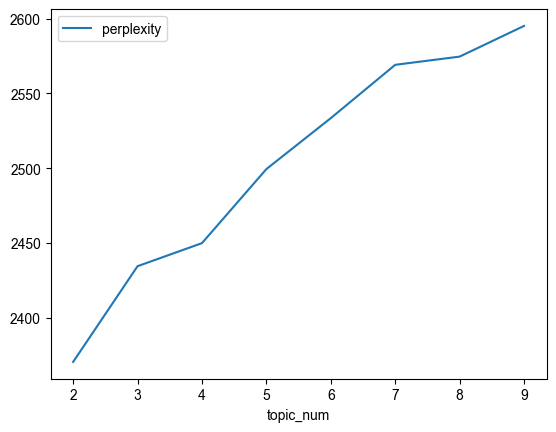

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

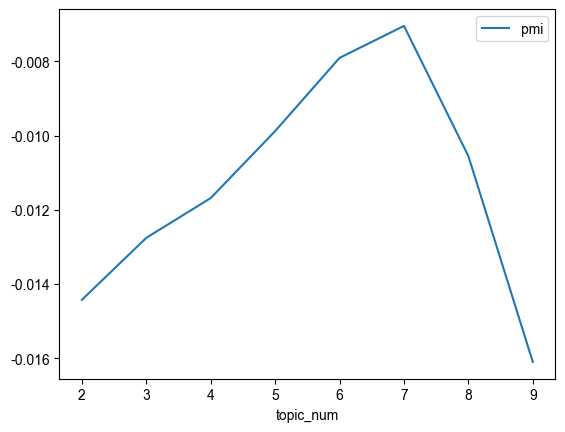

In [ ]:
result.plot.line(x='topic_num', y='pmi')

Â∞±Ë®ìÁ∑¥ÁµêÊûú‰æÜÁúãÔºåperplexity Âú® 5 ‰πãÂæåÈÉΩ‰∏çÈåØÔºåcoherence ÊúÄÈ´òÂâáÊòØ 8

## 5. Ë¶ñË¶∫ÂåñÂëàÁèæ

LDAvis ÊòØÊàëÂÄëÁ∂ìÂ∏∏ÊúÉ‰ΩøÁî®ÁöÑË¶ñË¶∫ÂåñÂ∑•ÂÖ∑ÔºåÁõÆÁöÑÁÇ∫Âπ´Âä©ÊàëÂÄëËß£Èáã‰∏ªÈ°åÊ®°Âûã‰∏≠ÔºåÂú®ÊàëÂÄëÂª∫ÊßãÂ•Ω‰∏ªÈ°åÊ®°ÂûãÂæóÂà∞ Œ∏(Êñá‰ª∂ÁöÑ‰∏ªÈ°åÂàÜ‰Ωà) Ë∑ü œÜ(‰∏ªÈ°åÁöÑÂ≠óÂàÜ‰Ωà)ÔºåÈÄèÈÅé pyLDAvis Â∞á‰∏ªÈ°åÈôçÁ∂≠Êàê‰∫åÁ∂≠Ôºå‰ª•Á∂≤È†ÅÁöÑÂΩ¢Âºè‰æõÊàëÂÄëÊü•Áúã„ÄÇ

+ ÂúìÂúàÊï∏Èáè‰ª£Ë°®‰∏ªÈ°åÊï∏ÈáèÔºåÊúâÂπæÂÄã‰∏ªÈ°åÂ∞±ÊúÉÊúâÂπæÂÄãÂúìÂúà
+ ÂúìË∂äÂ§ß‰ª£Ë°® document Ë∂äÂ§ß
+ Âè≥ÈÇäÂèØ‰ª•ÁúãÂà∞‰∏ªÈ°åÁöÑÂ≠óÂàÜ‰Ωà
+ Âè≥‰∏äÂπ´Êúâ‰∏ÄÂÄã bar Ë™øÊï¥ lambdaÔºöÁï∂ lambda=1 ‰πüÂ∞±ÊòØ‰ª£Ë°®Êú¨‰æÜÁöÑÂ≠óÂàÜ‰Ωà œÜÔºåÂ∞á lambda Á∏ÆË∂äÂ∞èÂèØ‰ª•ÁúãÂà∞Ë∂äÂîØ‰∏ÄÁöÑÂ≠óÔºåÂ•ΩÁöÑÂàÜ‰ΩàÊòØ œÜ È´ò‰∏îÂîØ‰∏ÄÔºåÂõ†Ê≠§ÊàëÂÄëË¶ÅÂú®ÈÄôÂÖ©ËÄÖÈñìÂèñÂπ≥Ë°°
+ ÂúìÂøÉË∂äÁõ∏ËøëÔºå‰ª£Ë°®‰∏ªÈ°åÊúÉË∂äÁõ∏‰ººÔºõÂèç‰πãÔºåÂúìÂøÉÂàÜË∂äÈñã‰ª£Ë°®‰∏ªÈ°åÊúâÂîØ‰∏ÄÊÄß<br>
  --> ÂÅáË®≠Ë©ûÂΩôÊú¨‰æÜÊúâ 100 Â≠óÔºåÁ∂≠Â∫¶ÊáâË©≤ÊòØ 100ÔºåÂÅáÂ¶ÇÊú¨‰æÜÁ∂≠Â∫¶Êé•Ëøë(Áõ∏Ëøë)ÁöÑË©±ÔºåÈôçÁ∂≠Âæå‰πüÊúÉÊé•Ëøë(Áõ∏Ëøë)

‰ª•‰∏ãÁî®‰∏ªÈ°åÊï∏ 8 ‰æÜÂÅö LDAvis ÁöÑÁµêÊûúÁØÑ‰æã

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # Ë®ìÁ∑¥Ê¨°Êï∏
    )

2025-04-16 00:17:51,257 : INFO : using symmetric alpha at 0.25
2025-04-16 00:17:51,258 : INFO : using symmetric eta at 0.25
2025-04-16 00:17:51,261 : INFO : using serial LDA version on this node
2025-04-16 00:17:51,266 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 00:17:51,266 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-16 00:17:51,269 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-16 00:17:51,626 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-16 00:17:51,627 : INFO : topic #0 (0.250): 0.020*"Â∞èÂ≠©" + 0.013*"ËÄÅÂÖ¨" + 0.012*"ËÄÅÂ©Ü" + 0.008*"Èõ¢Â©ö" + 0.007*"Â∞çÊñπ" + 0.005*"ÊÉ≥Ë¶Å" + 0.005*"ÁµêÂ©ö" + 0.004*"Â©öÂßª" + 0.004*"‰

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.020435  0.129892       1        1  31.296326
3      0.040550 -0.043206       2        1  28.688654
1     -0.121714 -0.059170       3        1  21.632619
2      0.101599 -0.027515       4        1  18.382401, topic_info=     Term         Freq        Total Category  logprob  loglift
295    ËÄÅÂ©Ü  3177.000000  3177.000000  Default  30.0000  30.0000
1031   Â•≥Êñπ  1014.000000  1014.000000  Default  29.0000  29.0000
7      Â§™Â§™  1348.000000  1348.000000  Default  28.0000  28.0000
66     Áî∑Êñπ   813.000000   813.000000  Default  27.0000  27.0000
200    ÂÖàÁîü  2176.000000  2176.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
250    Êé•Âèó   170.963650   731.960825   Topic4  -5.8596   0.2395
945    ‰∏ÄËµ∑   198.224287  1554.980298   Topic4  -5.7116  -0.3660
234    Âª∫Ë≠∞   171.464911   857.077279   Topic4  -5.8567   0.0846
14     ÊÉ≥Ë¶Å   174.716747  1081.121558   Topic4  -5.8379  -0.1288
665    ÁîüÊ¥ª   169.525008  1195.159203   Topic4  -5.8680  -0.2593

[387 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.353041   ‰∏Ä‰∏ã
381       2  0.206852   ‰∏Ä‰∏ã
381       3  0.154145   ‰∏Ä‰∏ã
381       4  0.285416   ‰∏Ä‰∏ã
5049      1  0.047200  ‰∏ÄÂÖ©Âπ¥
...     ...       ...  ...
5502      1  0.973019   È§Ö‰πæ
1294      1  0.789544   È§êÂª≥
1294      2  0.102176   È§êÂª≥
1294      3  0.083599   È§êÂª≥
1294      4  0.027866   È§êÂª≥

[848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

ÂèØ‰ª•ÁúãÂà∞(7,8)„ÄÅ(3,6)Âíå(2,5)ÂæàÁõ∏ËøëÔºåË©¶Ë©¶ÁúãË∑ë5ÂÄã‰∏ªÈ°å

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # Ë®ìÁ∑¥Ê¨°Êï∏
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-16 00:32:54,177 : INFO : using symmetric alpha at 0.3333333333333333
2025-04-16 00:32:54,178 : INFO : using symmetric eta at 0.3333333333333333
2025-04-16 00:32:54,179 : INFO : using serial LDA version on this node
2025-04-16 00:32:54,182 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 2204 documents, updating model once every 2000 documents, evaluating perplexity every 2204 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 00:32:54,182 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-16 00:32:54,183 : INFO : PROGRESS: pass 0, at document #2000/2204
2025-04-16 00:32:54,563 : INFO : merging changes from 2000 documents into a model of 2204 documents
2025-04-16 00:32:54,564 : INFO : topic #0 (0.333): 0.021*"Â∞èÂ≠©" + 0.012*"ËÄÅÂÖ¨" + 0.010*"ËÄÅÂ©Ü" + 0.008*"Èõ¢Â©ö" + 0.007*"Â∞çÊñπ" + 0.005*"Â©öÂßª" + 0.005*"ÁµêÂ©ö"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057088  0.087101       1        1  39.117001
2     -0.049137 -0.091559       2        1  31.127273
1      0.106225  0.004458       3        1  29.755726, topic_info=     Term         Freq        Total Category  logprob  loglift
1031   Â•≥Êñπ   985.000000   985.000000  Default  30.0000  30.0000
7      Â§™Â§™  1363.000000  1363.000000  Default  29.0000  29.0000
66     Áî∑Êñπ   793.000000   793.000000  Default  28.0000  28.0000
52     Â≠©Â≠ê  1685.000000  1685.000000  Default  27.0000  27.0000
589    ÊàøÂ≠ê   912.000000   912.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
11     Â∑≤Á∂ì   322.373860  1314.593268   Topic3  -5.7069  -0.1934
14     ÊÉ≥Ë¶Å   305.045373  1057.983206   Topic3  -5.7622  -0.0315
628    ÊôÇÈñì   297.982054  1346.489082   Topic3  -5.7856  -0.2961
1133   ÊúãÂèã   268.538633   722.416766   Topic3  -5.8897   0.2225
234    Âª∫Ë≠∞   268.797615   854.849252   Topic3  -5.8887   0.0552

[306 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.412409   ‰∏Ä‰∏ã
381       2  0.378539   ‰∏Ä‰∏ã
381       3  0.208197   ‰∏Ä‰∏ã
444       1  0.332497   ‰∏ÄÂÆö
444       2  0.318298   ‰∏ÄÂÆö
...     ...       ...  ...
6217      1  0.992875   È£ØÂ∫ó
6217      3  0.007465   È£ØÂ∫ó
1294      1  0.866475   È§êÂª≥
1294      2  0.043324   È§êÂª≥
1294      3  0.091461   È§êÂª≥

[614 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

ÊõøÊèõ‰∏ªÈ°åÊï∏Ë∑ëÁúãÁúãÔºåÂèØ‰ª•ÁúãÂá∫ÊúÄ‰Ω≥ÂèÉÊï∏ÁöÑÊï∏Â≠óÂíå‰∫∫È°ûÂà§Êñ∑ÁöÑ‰∏ç‰∏ÄÂÆöÊúÉÁõ∏Á¨¶ÔºåÊâÄ‰ª•ÁÇ∫‰∫ÜÊõ¥Â•ΩÁöÑËßÄÂØüÊñáÊú¨‰∏≠ÁöÑË≥áË®äÔºåÈÄêÊ≠•„ÄÅÂæ™Áí∞ÁöÑË™øÊï¥ÊòØÂæàÈáçË¶ÅÁöÑ

lambda ÁöÑÊÑèÁæ©: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- ÂéüÂßãÂ•ó‰ª∂: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab ÂÆ∂Èäò‰øÆÊîπÁâàÊú¨: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

ÂÆâË£ùÊñπÂºè:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
Á∂ìÊ∏¨Ë©¶ÔºåÂú® `python3.7~3.11.0` ÂèØÊ≠£Â∏∏Âü∑Ë°å

In [ ]:
import guidedlda

In [ ]:
word2id = dictionary.token2id
print(dictionary)

Dictionary<7724 unique tokens: ['‰πãÂâç', '‰øùÊúâ', 'ÂÅ∑Áúã', 'Âá∫Ëªå', 'Âè¶‰∏ÄÂçä']...>


In [ ]:
seed_topic_list = [
    # Â§ñÈÅáÔºàÂá∫Ëªå„ÄÅÊÉÖÊÑüËÉåÂèõÔºâ
    ["Âá∫Ëªå", "Â∞è‰∏â", "ÂÅ∑ÂêÉ", "ÈÄöÂß¶", "ÊõñÊòß", "Â§ñÈÅá", "Á∂†Ëå∂", "Â∞èÁéã"],

    # Â∞èÂ≠©ÔºàÊïôÈ§ä„ÄÅË¶™Ê¨äÁà≠Â•™Ôºâ
    ["Â∞èÂ≠©", "Â≠©Â≠ê", "Êí´È§ä", "Áõ£Ë≠∑Ê¨ä", "Êâ∂È§äË≤ª", "ÊïôËÇ≤Ë≤ª", "Êé¢Ë¶ñ"],

    # ÂÖ¨Â©ÜÔºàÂÆ∂Â∫≠Èóú‰øÇ„ÄÅÈï∑Ëº©Âπ≤Ê∂âÔºâ
    ["Â©ÜÂ©Ü",  "Èï∑Ëº©", "Âπ≤Ê∂â", "Â©ÜÂ™≥", "Â≤≥ÊØç", "ÂÖ¨ÂÖ¨", "Â®òÂÆ∂", "Â§´ÂÆ∂"],

    # ÈáëÈå¢ÔºàË≤°Áî¢ÂàÜÈÖç„ÄÅÁ∂ìÊøüÂ£ìÂäõÔºâ
    ["Ë≤°Áî¢", "Ë¥çÈ§äË≤ª", "ÊàøË≤∏", "Ë≤∏Ê¨æ", "Êî∂ÂÖ•", "ÁôªË®ò", "Ë≤°Âãô", "ÈáëÊµÅ"]
]


In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda ÈúÄË¶Å DTM Ê†ºÂºè‰ΩúÁÇ∫ inputÔºåÂõ†Ê≠§ÈÄôÈÇäÂà©Áî® corpus2dense() ÊñπÊ≥ïÈÄ≤Ë°åËΩâÊèõ
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-16 00:02:15,053 : INFO : n_documents: 2204
2025-04-16 00:02:15,055 : INFO : vocab_size: 7724
2025-04-16 00:02:15,056 : INFO : n_words: 326051
2025-04-16 00:02:15,056 : INFO : n_topics: 4
2025-04-16 00:02:15,056 : INFO : n_iter: 100
2025-04-16 00:02:15,862 : INFO : <0> log likelihood: -3113218
2025-04-16 00:02:16,024 : INFO : <20> log likelihood: -2747314
2025-04-16 00:02:16,185 : INFO : <40> log likelihood: -2722854
2025-04-16 00:02:16,347 : INFO : <60> log likelihood: -2711267
2025-04-16 00:02:16,506 : INFO : <80> log likelihood: -2705684
2025-04-16 00:02:16,664 : INFO : <99> log likelihood: -2700037


In [ ]:
# Êï¥ÁêÜÔºèÈ°ØÁ§∫‰∏ªÈ°åÊ®°ÂûãÁµêÊûú
n_top_words = 10
topic_word = model.topic_word_
vocab = [dictionary[i] for i in range(len(dictionary))]

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # Êñá‰ª∂-‰∏ªÈ°å ÂàÜ‰Ωà
term_freq = tuple(dictionary.cfs.values()) # ÊØèÂÄãË©ûÂú®Êï¥ÂÄãË™ûÊñô‰∏≠Âá∫ÁèæÁöÑÁ∏ΩÊ¨°Êï∏
doc_len = [sum(v for k, v in doc) for doc in corpus] # ÊØèÁØáÊñáÁ´†ÁöÑÈï∑Â∫¶

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: Èõ¢Â©ö Â©öÂßª Â∞çÊñπ ËÄÅÂÖ¨ Â§™Â§™ ÂÖàÁîü Èóú‰øÇ ÊÉÖÁ∑í ÊÉ≥Ë¶Å Ê∫ùÈÄö
Topic 1: Â∞èÂ≠© Â≠©Â≠ê ËÄÅÂ©Ü ËÄÅÂÖ¨ ÊôÇÈñì Â™ΩÂ™Ω ÁÖßÈ°ß Èõ¢Â©ö ÁîüÊ¥ª ‰∏ÄËµ∑
Topic 2: ÂÖàÁîü ËÄÅÂ©Ü Â©ÜÂ©Ü ËÄÅÂÖ¨ ÊàëÂ™Ω Áà∏Â™Ω ÁµêÂ©ö Â©ÜÂÆ∂ Áõ¥Êé• ÂÖ¨Â©Ü
Topic 3: Èõ¢Â©ö ËÄÅÂ©Ü Â∞èÂ≠© ÊàøÂ≠ê Â•≥Êñπ ÁµêÂ©ö Áî∑Êñπ ÂÖàÁîü ËÄÅÂÖ¨ ÂÆ∂Â∫≠


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140889  0.131270       1        1  35.040175
1     -0.091180 -0.247579       2        1  23.787704
3      0.187059 -0.031925       3        1  21.237859
2     -0.236768  0.148233       4        1  19.934261, topic_info=     Term         Freq        Total Category  logprob  loglift
112    Â∞èÂ≠©  5282.000000  5282.000000  Default  30.0000  30.0000
52     Â≠©Â≠ê  1849.000000  1849.000000  Default  29.0000  29.0000
295    ËÄÅÂ©Ü  3433.000000  3433.000000  Default  28.0000  28.0000
1779   Â©ÜÂ©Ü   934.000000   934.000000  Default  27.0000  27.0000
200    ÂÖàÁîü  2254.000000  2254.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
40     ‰∏çÊÉ≥   282.699521   977.112540   Topic4  -5.4377   0.3725
11     Â∑≤Á∂ì   303.676482  1302.814685   Topic4  -5.3661   0.1564
37     Èõ¢Â©ö   364.609561  4150.061658   Topic4  -5.1833  -0.8193
26     ÁúãÂà∞   254.730238   769.327245   Topic4  -5.5419   0.5074
945    ‰∏ÄËµ∑   244.741209  1335.778260   Topic4  -5.5819  -0.0843

[313 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.247641   ‰∏Ä‰∏ã
381       2  0.363690   ‰∏Ä‰∏ã
381       3  0.190653   ‰∏Ä‰∏ã
381       4  0.198942   ‰∏Ä‰∏ã
444       1  0.509171   ‰∏ÄÂÆö
...     ...       ...  ...
332       4  0.178257   È°òÊÑè
6217      4  1.000408   È£ØÂ∫ó
175       4  1.000431   È£≤Êñô
1294      3  0.011772   È§êÂª≥
1294      4  0.988855   È§êÂª≥

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [ ]:
seed_topic_list = [
    # Â§ñÈÅáÔºàÂá∫Ëªå„ÄÅÊÉÖÊÑüËÉåÂèõÔºâ
    ["Âá∫Ëªå", "Â∞è‰∏â", "ÂÅ∑ÂêÉ", "ÈÄöÂß¶", "ÊõñÊòß", "Â§ñÈÅá", "Á∂†Ëå∂", "Â∞èÁéã"],

    # Â∞èÂ≠©ÔºàÊïôÈ§ä„ÄÅË¶™Ê¨äÁà≠Â•™Ôºâ
    ["Â∞èÂ≠©", "Â≠©Â≠ê", "Êí´È§ä", "Áõ£Ë≠∑Ê¨ä", "Êâ∂È§äË≤ª", "ÊïôËÇ≤Ë≤ª", "Êé¢Ë¶ñ"],

    # ÂÖ¨Â©ÜÔºàÂÆ∂Â∫≠Èóú‰øÇ„ÄÅÈï∑Ëº©Âπ≤Ê∂âÔºâ
    ["Â©ÜÂ©Ü",  "Èï∑Ëº©", "Âπ≤Ê∂â", "Â©ÜÂ™≥", "Â≤≥ÊØç", "ÂÖ¨ÂÖ¨", "Â®òÂÆ∂", "Â§´ÂÆ∂"],

    # ÈáëÈå¢ÔºàË≤°Áî¢ÂàÜÈÖç„ÄÅÁ∂ìÊøüÂ£ìÂäõÔºâ
    ["Ë≤°Áî¢", "Ë¥çÈ§äË≤ª", "ÊàøË≤∏", "Ë≤∏Ê¨æ", "Êî∂ÂÖ•", "ÁôªË®ò", "Ë≤°Âãô", "ÈáëÊµÅ"]
]


seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-16 00:04:08,790 : INFO : n_documents: 2204
2025-04-16 00:04:08,791 : INFO : vocab_size: 7724
2025-04-16 00:04:08,791 : INFO : n_words: 326051
2025-04-16 00:04:08,792 : INFO : n_topics: 4
2025-04-16 00:04:08,792 : INFO : n_iter: 100
2025-04-16 00:04:09,624 : INFO : <0> log likelihood: -3113218
2025-04-16 00:04:09,791 : INFO : <20> log likelihood: -2747314
2025-04-16 00:04:09,952 : INFO : <40> log likelihood: -2722854
2025-04-16 00:04:10,112 : INFO : <60> log likelihood: -2711267
2025-04-16 00:04:10,271 : INFO : <80> log likelihood: -2705684
2025-04-16 00:04:10,430 : INFO : <99> log likelihood: -2700037


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: Èõ¢Â©ö Â©öÂßª Â∞çÊñπ ËÄÅÂÖ¨ Â§™Â§™ ÂÖàÁîü Èóú‰øÇ ÊÉÖÁ∑í ÊÉ≥Ë¶Å Ê∫ùÈÄö
Topic 1: Â∞èÂ≠© Â≠©Â≠ê ËÄÅÂ©Ü ËÄÅÂÖ¨ ÊôÇÈñì Â™ΩÂ™Ω ÁÖßÈ°ß Èõ¢Â©ö ÁîüÊ¥ª ‰∏ÄËµ∑
Topic 2: ÂÖàÁîü ËÄÅÂ©Ü Â©ÜÂ©Ü ËÄÅÂÖ¨ ÊàëÂ™Ω Áà∏Â™Ω ÁµêÂ©ö Â©ÜÂÆ∂ Áõ¥Êé• ÂÖ¨Â©Ü
Topic 3: Èõ¢Â©ö ËÄÅÂ©Ü Â∞èÂ≠© ÊàøÂ≠ê Â•≥Êñπ ÁµêÂ©ö Áî∑Êñπ ÂÖàÁîü ËÄÅÂÖ¨ ÂÆ∂Â∫≠


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140889  0.131270       1        1  35.040175
1     -0.091180 -0.247579       2        1  23.787704
3      0.187059 -0.031925       3        1  21.237859
2     -0.236768  0.148233       4        1  19.934261, topic_info=     Term         Freq        Total Category  logprob  loglift
112    Â∞èÂ≠©  5282.000000  5282.000000  Default  30.0000  30.0000
52     Â≠©Â≠ê  1849.000000  1849.000000  Default  29.0000  29.0000
295    ËÄÅÂ©Ü  3433.000000  3433.000000  Default  28.0000  28.0000
1779   Â©ÜÂ©Ü   934.000000   934.000000  Default  27.0000  27.0000
200    ÂÖàÁîü  2254.000000  2254.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
40     ‰∏çÊÉ≥   282.699521   977.112540   Topic4  -5.4377   0.3725
11     Â∑≤Á∂ì   303.676482  1302.814685   Topic4  -5.3661   0.1564
37     Èõ¢Â©ö   364.609561  4150.061658   Topic4  -5.1833  -0.8193
26     ÁúãÂà∞   254.730238   769.327245   Topic4  -5.5419   0.5074
945    ‰∏ÄËµ∑   244.741209  1335.778260   Topic4  -5.5819  -0.0843

[313 rows x 6 columns], token_table=      Topic      Freq Term
term                      
381       1  0.247641   ‰∏Ä‰∏ã
381       2  0.363690   ‰∏Ä‰∏ã
381       3  0.190653   ‰∏Ä‰∏ã
381       4  0.198942   ‰∏Ä‰∏ã
444       1  0.509171   ‰∏ÄÂÆö
...     ...       ...  ...
332       4  0.178257   È°òÊÑè
6217      4  1.000408   È£ØÂ∫ó
175       4  1.000431   È£≤Êñô
1294      3  0.011772   È§êÂª≥
1294      4  0.988855   È§êÂª≥

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

## 7. ‰∏ªÈ°åÂàÜ‰ΩàÁöÑÊáâÁî®ÔºåÊê≠ÈÖçÂÖ∂‰ªñÊñáÁ´†Ë≥áË®ä

Ë®ìÁ∑¥ÂÆåLDAÊ®°ÂûãÂæåÔºåÊàëÂÄëÂèØ‰ª•ÂòóË©¶Â∞áË®ìÁ∑¥Â•ΩÁöÑÊ®°ÂûãÊáâÁî®ÊñºË≥áÊñôÈõÜ‰∏äÔºåËßÄÂØüÊØèÂ§©‰∏ªÈ°åÊñáÁ´†ÁöÑ‰ΩîÊØîËÆäÂåñ

In [ ]:
# ÂèñÂæóÊØèÊ¢ùÊñ∞ËÅûÁöÑ‰∏ªÈ°åÂàÜ‰Ωà
topics_doc = model_5.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.5605979), (1, 0.23947774), (2, 0.19992433)]

#### Â∞á LDA Ê®°ÂûãÊé®Ë´ñÂæåÁöÑÊØèÁØáÊñá‰ª∂ÁöÑ ‰∏ªÈ°åÂàÜÂ∏ÉÔºà‰πüÂ∞±ÊòØ ùúÉÔºâËΩâÊèõÊàê‰∏ÄÂÄã NumPy Áü©Èô£ÔºàarrayÔºâ

In [ ]:
# Êää gensim ÁöÑÁ®ÄÁñèË°®Á§∫Ê≥ïËΩâÊàêÁ®ÄÁñèÁü©Èô£
m_theta = corpus2csc(topics_doc).T.toarray() # ÂÄíÁΩÆËÆìshapeËÆäÁÇ∫(num_docs, num_topics)
m_theta

array([[0.62762403, 0.        , 0.36388329],
       [0.07755699, 0.64984453, 0.27259848],
       [0.40168506, 0.57119024, 0.0271247 ],
       ...,
       [0.99608099, 0.        , 0.        ],
       [0.77657616, 0.        , 0.21992192],
       [0.98283869, 0.        , 0.        ]])

In [ ]:
# Â∞á‰∏ªÈ°åÁöÑÊ©üÁéáÂàÜÂ∏ÉËΩâÊèõÊàê‰∏ªÈ°åÊ®ôÁ±§
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### Áµ±Ë®à‰∏Ä‰∏ãÂêÑÂÄã‰∏ªÈ°åÁöÑÊï∏Èáè

In [ ]:
udn['topic_label'].value_counts()

topic_label
1    875
2    750
3    579
Name: count, dtype: int64

In [ ]:
udn.head()

content  \
0  Â∏∏Â∏∏ÁúãÂ§ßÂÆ∂Ë™™ÂÅ∑ÁúãÊâãÊ©üÊòØ‰∏çÂ∞çÁöÑ‰ΩÜÂ¶ÇÊûúÂ∑≤Á∂ìÁµêÂ©ö‰∫ÜÂ§™Â§™ÊÉ≥Áúã‰Ω†ÊâãÊ©üÁúüÁöÑÂèØ‰ª•ÊãíÁµïÂóéÊÑüË¶∫‰Ω†ÊãíÁµïÂ∞±ÊòØÂøÉË£°Êúâ...   
1  Âõ†ÁÇ∫Áî∑ÊñπÂ∑•‰Ωú‰∏çÁ©©ÂÆöÊàøÊù±Êâç‰∏çËÇØÁßüÂè™Â•ΩÊèõÂ•≥ÁîüÊâøÁßüÂ∞çÂêßÂæàÊÆòÂøçÁöÑË™™ÈÄôÁÑ°Á∑£ÁöÑÂ≠©Â≠êËÅ∞Êòé‰æÜÂà∞ÈÄô‰∏ñÈñìÂè™ÊòØËã¶Èõ£...   
2  ÊâãÊ©üË¶ÅÁúãÂ∞±Áµ¶ÁúãÂïäÂÖàÂ∏ùÁà∫‰∏çÊòØË™™‰∏ÄÈöª‰∏çÂ§†‰∏çËÉΩËæ¶ÂÖ©ÈöªÂóéÂÖ©Èöª‰∏çÂ§†‰∏çËÉΩËæ¶‰∏âÈöªÂóé‰∏âÈöªÂõõÈöª‰∏çÂ§†ÂèØ‰ª•Ëæ¶‰∫îÈöªÂçÅ...   
3  ÂÖ∂ÂØ¶ÈÉΩÊòØÂ∞è‰∫ã‰ΩÜÈÉΩÂèØ‰ª•ÂêµÂà∞Èõ¢Â©öÂèØËÉΩÊàëÂÄëÂ∞±ÊòØÂπæÊ≠≤ÁöÑÂ∞èÂ≠©Êò®Êôö‰∏äÂ∫äÁù°Ë¶∫Âæå‰∏ÄÁõ¥Ë¶∫ÂæóÂæàÂÜ∑ËÄÅÂÖ¨‰πüÂñäÂÜ∑ÊÉ≥Ë™™Áù°...   
4  ÊääÊ£âË¢´ÁøªÂ•ΩÊ≠£Èù¢ÂóØÂóØÊúâÂóØÈÇ£‰Ω†ÂππÂòõÊä±ÊÄ®‰Ω†ËÄÅÂÖ¨‰∏çÊòØË™∞‰∏äÂ∫äÁù°Ë¶∫ÈÇÑÊúÉÊ™¢Êü•Ê£âË¢´Ê≠£ÂèçÁöÑÂóéÊàëÊàë‰πüË¶∫Âæó‰Ω†ÂçäÂ§úÂè´...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/marriage/M.1610159827.A...    marriage   
1  https://www.ptt.cc/bbs/marriage/M.1610162736.A...    marriage   
2  https://www.ptt.cc/bbs/marriage/M.1610190309.A...    marriage   
3  https://www.ptt.cc/bbs/marriage/M.1610193770.A...    marriage   
4  https://www.ptt.cc/bbs/marriage/M.1610203445.A...    marriage   

              artDate                                              words  \
0 2021-01-09 10:37:05  [ÂÅ∑Áúã, ÊâãÊ©ü, Â∑≤Á∂ì, ÁµêÂ©ö, Â§™Â§™, ÊâãÊ©ü, ÊãíÁµï, ÊÑüË¶∫, ÊãíÁµï, ÂøÉË£°, ÊúâÈ¨º, Â§™...   
1 2021-01-09 11:25:34  [Áî∑Êñπ, Á©©ÂÆö, ÊàøÊù±, ‰∏çËÇØ, Âè™Â•Ω, Â•≥Áîü, ÊâøÁßü, ÊÆòÂøç, ÁÑ°Á∑£, Â≠©Â≠ê, ËÅ∞Êòé, ‰æÜ...   
2 2021-01-09 19:05:00  [ÊâãÊ©ü, Áµ¶Áúã, ÂÖàÂ∏ù, ‰∏ÄÈöª, ‰∏çÂ§†, ÂÖ©Èöª, ÂÖ©Èöª, ‰∏çÂ§†, ‰∏âÈöª, ‰∏âÈöª, ÂõõÈöª, ‰∏ç...   
3 2021-01-09 20:02:46  [Â∞è‰∫ã, ÂêµÂà∞, Èõ¢Â©ö, ÂπæÊ≠≤, Â∞èÂ≠©, Êò®Êôö, ‰∏äÂ∫ä, Áù°Ë¶∫, ‰∏ÄÁõ¥, ËÄÅÂÖ¨, ÂÜ∑ÊÉ≥, Ê∫´...   
4 2021-01-09 22:44:03  [Ê£âË¢´, Ê≠£Èù¢, ÂππÂòõ, Êä±ÊÄ®, ËÄÅÂÖ¨, ‰∏äÂ∫ä, Áù°Ë¶∫, ÈÇÑÊúÉ, Ê™¢Êü•, Ê£âË¢´, Ê≠£Âèç, Âçä...   

   topic_label  
0            1  
1            2  
2            2  
3            1  
4            1

#### Êü•ÁúãÊØèÂ§©ÊØèÂÄã‰∏ªÈ°åÁöÑÊñáÁ´†Áõ∏Â∞çÊØî‰æãÔºàÂç†ÊØîÔºâ

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)


artDate     topic_label
2021-01-09  1              0.571429
            4              0.285714
            3              0.142857
2021-01-10  1              0.428571
            2              0.285714
                             ...   
2024-12-30  1              0.750000
            2              0.250000
2024-12-31  1              0.500000
            2              0.250000
            4              0.250000
Name: proportion, Length: 1383, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label         1         2         3
artDate                                  
2021-01-09   0.571429  0.285714  0.142857
2021-01-10   0.571429  0.285714  0.142857
2021-01-11        NaN       NaN  1.000000
2021-01-12        NaN  1.000000       NaN
2021-01-13   0.500000  0.500000       NaN

#### Ë¶ñË¶∫ÂåñÂëàÁèæ‰∏ªÈ°åÊñáÁ´†Ë∂®Âã¢ËÆäÂåñ

/var/folders/8v/d43rjw7s49s8tg2qbw5vxr1h0000gn/T/ipykernel_48197/4047522323.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = date_topic.resample('M').mean()


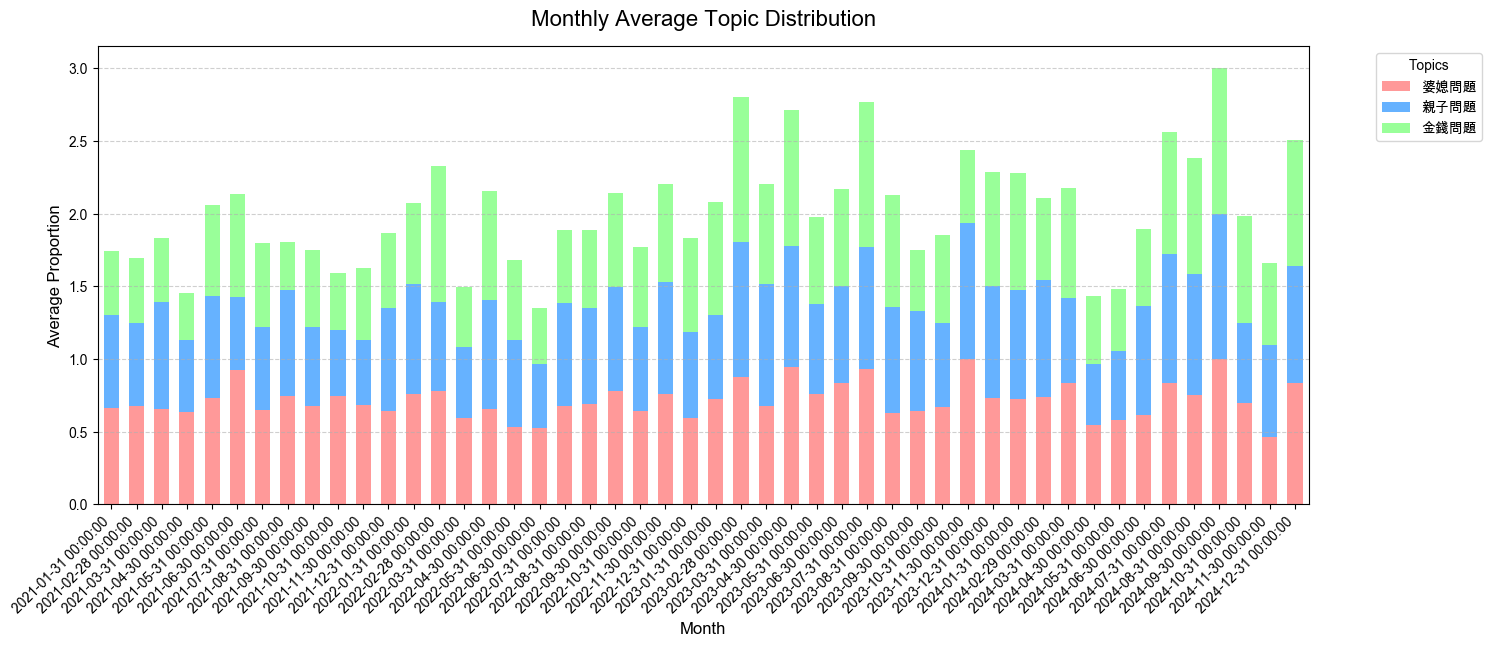

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Á¢∫‰øù index ÊòØ datetime
date_topic.index = pd.to_datetime(date_topic.index)

# ‰æùÊúà‰ªΩÂèñÂπ≥ÂùáÔºàÊúÉËá™ÂãïÊåâÊØèÊúàÂàÜÁµÑÔºâ
monthly_avg = date_topic.resample('M').mean()

# Áï´ÂúñÔºàÂ†ÜÁñä barÔºâ
plt.figure(figsize=(15, 6))
ax = plt.gca()

monthly_avg.plot.bar(
    ax=ax,
    stacked=True,
    color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'],
    width=0.6
)

# Ê®ôÈ°åËàáÊ†ºÂºèË®≠ÂÆö
plt.title('Monthly Average Topic Distribution', fontsize=16, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Proportion', fontsize=12)

# Ë™øÊï¥Âúñ‰æã
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), 
           labels=['Â©ÜÂ™≥ÂïèÈ°å', 'Ë¶™Â≠êÂïèÈ°å', 'ÈáëÈå¢ÂïèÈ°å'])

# ÁæéÂåñ
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


ÂèØ‰ª•ÁúãÂà∞‰∏ªÈ°å3Ôºà‰∏≠ÂúãÂêÑÁî¢Ê•≠Â∏ÇÂ†¥ÔºâÂú® 2/15„ÄÅ2/16 Ë¢´Ë®éË´ñÁöÑÊØî‰æãÂæàÈ´òÔºåÂèØ‰ª•‰ΩúÁÇ∫ÂæåÁ∫åÊé¢Á¥¢ÁöÑÁõÆÊ®ôÔºå<br>
Â§ßÂÆ∂ÂèØ‰ª•ÂÉèÈÄôÊ®£ÔºåÈÄèÈÅéÊê≠ÈÖçÊñáÁ´†ÁöÑË≥áË®äÔºà‰æãÂ¶ÇÊó•ÊúüÁ≠âÔºâÔºåËÆì‰∏ªÈ°åÊ®°ÂûãÁöÑÁµêÊûúÂÅöÂá∫Êõ¥Â§öÁöÑÂàÜÊûêÊáâÁî®„ÄÇ